# EDA Decision Analysis Pipeline

This notebook contains the EDA signal processing pipeline designed by Lorenzo del Puppo. It includes all the necessary steps for analyzing the signals.
- Remove noise and outliers 
- Decompose the signal into SCR and SCL components. 
- Separating into decision phases (e.g, pre-decision, during-decision, ....).

## 1. SETUP & IMPORTS —  (multi-format ready)

In [1]:

# 1) Env to stabilize BLAS/OpenMP on macOS
import os
os.environ["MKL_THREADING_LAYER"] = "SEQUENTIAL"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# 2) Imports
import sys, glob, json, re
from pathlib import Path
import numpy as np
import pandas as pd
import neurokit2 as nk
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 3) Verify libs (pyxdf and h5py may be optional depending on the session format)
import scipy, platform
print(platform.platform())
print("NumPy", np.__version__, "| SciPy", scipy.__version__, "| Pandas", pd.__version__)

try:
    import pyxdf
    print("pyxdf", pyxdf.__version__)
except Exception as e:
    pyxdf = None
    print("pyxdf not available:", e)

try:
    import h5py
    print("h5py available")
except Exception as e:
    h5py = None
    print("h5py not available:", e)

# ===== General parameters (aligned with working notebook standards) =====
# NOTE: ROOT_DIR should point to the top-level folder that contains session folders.
ROOT_DIR = "/Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions"
opensignals_fs = 1000  # OpenSignals hardware sampling rate (Hz)

# Always discover pre-LSL sessions from the filesystem
sessions_prelsl = sorted([d for d in os.listdir(ROOT_DIR) if "(pre LSL)" in d])
print(f"Found pre-LSL sessions (from ROOT_DIR): {len(sessions_prelsl)} → {sessions_prelsl}")

# Multi-format support
SUPPORTED_DATA_EXTS = [".xdf", ".h5", ".txt"]
PRELSL_HEP_SUBFOLDER = "HEP"      # pre-LSL sessions may include an inner "HEP" folder with per-subject H5/TXT (and EEG-only XDF)
XDF_EEG_ONLY_HINT = "_HEP"        # LSL sessions: EEG-only XDFs are typically marked with "_HEP" in filename

# Analysis windows configuration
WINDOW_DURS = [3, 5, 10]  # Window durations in seconds
WINDOW_TYPES = ["pre_decision", "during_decision", "post_decision", "post_feedback", "during_feedback"]
BASELINE_DUR_MIN = 5  # Baseline duration in minutes

# I/O format preferences (for pre-LSL sessions)
USE_H5_ONLY = True        # Use H5 for non-XDF sessions
DISABLE_TXT = True        # Do not read TXT mirrors (duplicated content)

# Quality control thresholds
QUALITY_THRESH_STD = 1e-5  # Minimum signal variability (flat signal detection)
MIN_VALID_WINDOW_SEC = 2   # Minimum valid window duration in seconds

# Output paths (KEEP ORIGINAL WORKING PATH)
OUTDIR = "/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/"
os.makedirs(OUTDIR, exist_ok=True)
LOGFILE = os.path.join(OUTDIR, "exclusion_log.csv")
SUMMARYFILE = os.path.join(OUTDIR, "exclusion_summary.txt")
PARAMSFILE = os.path.join(OUTDIR, "pipeline_params.json")

# Save pipeline parameters for reproducibility (now includes multi-format)
pipeline_params = {
    "sampling_rate": opensignals_fs,
    "window_durations": WINDOW_DURS,
    "window_types": WINDOW_TYPES,
    "baseline_duration_min": BASELINE_DUR_MIN,
    "quality_thresholds": {
        "min_std": QUALITY_THRESH_STD,
        "min_window_sec": MIN_VALID_WINDOW_SEC
    },
    "data_support": {
        "supported_exts": SUPPORTED_DATA_EXTS,
        "prelsl_hep_subfolder": PRELSL_HEP_SUBFOLDER,
        "xdf_eeg_only_hint": XDF_EEG_ONLY_HINT
    }
}
with open(PARAMSFILE, 'w') as f:
    json.dump(pipeline_params, f, indent=2)

print(f"Pipeline configured for {len(WINDOW_TYPES)} window types × {len(WINDOW_DURS)} durations = {len(WINDOW_TYPES)*len(WINDOW_DURS)} conditions per round")
print(f"Supported data formats: {SUPPORTED_DATA_EXTS} (auto-detected per session)")

def effective_fs_from_ms(timestamps_ms: np.ndarray) -> float:
    """Estimate effective sampling rate (Hz) from ms timestamps."""
    if timestamps_ms is None or len(timestamps_ms) < 3:
        return float(opensignals_fs)
    diffs = np.diff(timestamps_ms)
    diffs = diffs[np.isfinite(diffs) & (diffs > 0)]
    if diffs.size == 0:
        return float(opensignals_fs)
    return 1000.0 / np.median(diffs)

macOS-26.0.1-arm64-arm-64bit
NumPy 2.3.2 | SciPy 1.16.1 | Pandas 2.3.1
pyxdf 1.17.0
h5py available
Found pre-LSL sessions (from ROOT_DIR): 6 → ['02-07-2024_14.15 (pre LSL)', '02-07-2024_16.30 (pre LSL)', '03-07-2024_15.15 (pre LSL)', '28-05-2024_14.30 (pre LSL)', '28-05-2024_17.15 (pre LSL)', '29-05-2024_15.30 (pre LSL)']
Pipeline configured for 5 window types × 3 durations = 15 conditions per round
Supported data formats: ['.xdf', '.h5', '.txt'] (auto-detected per session)


In [2]:
# === MONKEYPATCH: log every to_csv on analysis_ready_primary_5s.csv / add-on ===
# goal is to see from where the file is called (file name and row)
import pandas as _pd, inspect as _inspect, os as _os, builtins as _bi

# Keep the original to_csv method
_to_csv_orig = _pd.DataFrame.to_csv

# Files to watch
WATCH = {
    _os.path.abspath("/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/analysis_ready_primary_5s.csv"),
    _os.path.abspath("/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/prelsl_during_feedback_windows_features.csv"),
}

def _to_csv_watch(self, *args, **kwargs):
    """
    Monkeypatched replacement for DataFrame.to_csv.
    Whenever one of the WATCH files is written, log the absolute path
    and print a short stack trace (first two frames).
    """
    path = args[0] if args else kwargs.get("path_or_buf", None)
    if isinstance(path, str):
        ap = _os.path.abspath(path)
        if ap in WATCH:
            print("\n🛎️ to_csv WATCH:", ap)
            # print origin: .ipynb file (if possible) + first 2 stack frames
            stack = _inspect.stack()
            for fr in stack[:2]:
                print("   called from:", fr.filename, "line", fr.lineno)
    return _to_csv_orig(self, *args, **kwargs)

# Apply the monkeypatch
_pd.DataFrame.to_csv = _to_csv_watch

## 2. ENHANCED SUPPORT FUNCTIONS — TEMPORAL SYNC, EDA PROCESSING, MULTI-FORMAT LOADERS

In [3]:
# ===== Enhanced temporal window definitions =====
def define_decision_windows():
    """
    ENHANCED: Precise temporal window definitions for decision-making analysis.
    Addresses reviewer requirements for explicit temporal anchoring.
    
    Returns:
        dict: Window definitions with precise event anchoring
    """
    window_definitions = {
        'pre_decision': {
            'description': 'Anticipatory arousal before decision onset',
            'anchor_event': 'decision_stimulus_onset',
            'time_range': (-5.0, -0.5),  # 5s before to 0.5s before decision onset
            'rationale': 'Captures preparatory arousal and anticipation',
            'expected_scr_latency': '1-3s after cognitive load onset'
        },
        'during_decision': {
            'description': 'Active decision-making process', 
            'anchor_event': 'decision_stimulus_onset',
            'time_range': (0.0, 3.0),  # From decision onset to 3s after
            'rationale': 'Captures cognitive effort and decision conflict',
            'expected_scr_latency': '1-4s after decision stimulus'
        },
        'post_decision': {
            'description': 'Immediate post-decision period',
            'anchor_event': 'decision_response_timestamp',
            'time_range': (0.5, 3.5),  # 0.5s to 3.5s after response
            'rationale': 'Captures decision confidence and commitment arousal',
            'expected_scr_latency': '1-3s after response confirmation'
        },
        'post_feedback': {
            'description': 'Feedback processing and outcome evaluation (longer window)',
            'anchor_event': 'account_start_timestamp',
            'time_range': (0.0, 4.0),  # From account view onset to 4s after
            'rationale': 'Captures outcome evaluation and prediction error',
            'expected_scr_latency': '1-4s after feedback/account presentation'
        },
        'during_feedback': {
            'description': 'Immediate feedback response (short, locked at feedback onset)',
            'anchor_event': 'feedback_start_timestamp',
            'time_range': (0.0, 3.0),  # From feedback onset to 3s after
            'rationale': 'Captures phasic response right after feedback appears',
            'expected_scr_latency': '1-3s after feedback onset'
        }
    }
    
    print("📋 ENHANCED Temporal Window Definitions:")
    for window_name, details in window_definitions.items():
        print(f"   {window_name}: {details['time_range']}s from {details['anchor_event']}")
        print(f"      → {details['rationale']}")
    
    return window_definitions

def validate_temporal_windows(window_start, window_end, sampling_rate=1000, min_duration=1.0):
    """
    Validate window duration against SCR physiology (rise/recovery).
    """
    duration = window_end - window_start
    n_samples = int(duration * sampling_rate)
    validation = {
        'is_valid': True,
        'duration_sec': duration,
        'n_samples': n_samples,
        'warnings': [],
        'recommendations': []
    }
    if duration < min_duration:
        validation['is_valid'] = False
        validation['warnings'].append(f"Window too short ({duration:.1f}s) for reliable SCR detection")
        validation['recommendations'].append(f"Use minimum {min_duration}s windows")

    if duration < 3.0:
        validation['warnings'].append("May not capture full SCR rise time (1–3s)")
    if duration < 5.0:
        validation['warnings'].append("May not capture SCR recovery (2–10s)")

    if 3.0 <= duration <= 10.0:
        validation['recommendations'].append("Window duration optimal for SCR analysis")
    elif duration > 10.0:
        validation['recommendations'].append("Consider shorter windows to reduce temporal noise")
    return validation

# ===== EDA processing parameters =====
EDA_PROCESSING_PARAMS = {
    'sampling_rate': 1000,  # Hz
    'lowpass_filter': {
        'enabled': True,
        'cutoff_hz': 5.0,
        'order': 4,
        'rationale': 'EDA signals carry energy mostly <5 Hz'
    },
    'decomposition': {
        'method': 'highpass',       # default method used by the working pipeline
        'highpass_cutoff': 0.05,    # Hz (tonic < 0.05 Hz; phasic > 0.05 Hz)
        'rationale': 'Separates slow tonic arousal from fast phasic responses'
    },
    'scr_detection': {
        'min_amplitude': 0.01,      # μS (conservative default; window-level overrides may use 0.0001 μS)
        'rise_time_min': 0.5,       # s
        'rise_time_max': 4.0,       # s
        'recovery_time': 10.0,      # s
        'refractory_period': 1.0    # s
    },
    'baseline_correction': {
        'method': 'tonic_subtraction',
        'baseline_duration': 60.0,  # s (initial rest)
        'dynamic_baseline': False,
        'rationale': 'Removes inter-individual SCL level differences'
    },
    'quality_thresholds': {
        'max_drift_per_minute': 0.1,  # μS/min
        'min_signal_range': 0.05,     # μS
        'max_artifact_percentage': 20 # %
    }
}

def print_eda_processing_parameters():
    """Human-readable dump of the processing parameters."""
    print("🔬 EDA Processing Parameters:")
    print(f"   Sampling Rate: {EDA_PROCESSING_PARAMS['sampling_rate']} Hz")
    print(f"   Low-pass: {EDA_PROCESSING_PARAMS['lowpass_filter']['cutoff_hz']} Hz (order {EDA_PROCESSING_PARAMS['lowpass_filter']['order']})")
    print(f"   Decomposition: {EDA_PROCESSING_PARAMS['decomposition']['method']} (hp {EDA_PROCESSING_PARAMS['decomposition']['highpass_cutoff']} Hz)")
    print(f"   SCR Detection: ≥{EDA_PROCESSING_PARAMS['scr_detection']['min_amplitude']} μS amplitude")
    print(f"   Baseline: {EDA_PROCESSING_PARAMS['baseline_correction']['baseline_duration']} s initial period")
    print("   → Parameters follow psychophysiology best practices (Boucsein, 2012).")

# ===== QUALITY & EXCLUSION LOGGING =====
exclusion_log = []

def log_exclusion_enhanced(session, participant, reason, details=None):
    """Append a structured exclusion record and print a concise message."""
    entry = {
        'session': session,
        'participant': participant,
        'reason': reason,
        'timestamp': pd.Timestamp.now().isoformat(),
        'details': details or {}
    }
    exclusion_log.append(entry)
    msg = f"[EXCLUSION] {session}-{participant}: {reason}"
    if details:
        msg += f" | details={details}"
    print(msg)

def save_exclusion_log_enhanced():
    """Persist the exclusion log and a compact summary."""
    if len(exclusion_log) == 0:
        pd.DataFrame(columns=['session', 'participant', 'reason', 'timestamp', 'details']).to_csv(LOGFILE, index=False)
        with open(SUMMARYFILE, 'w') as f:
            f.write("🎉 QUALITY CONTROL SUMMARY\n========================\n✅ No exclusions.\n")
        print("✅ Quality control complete — no exclusions.")
        return

    df_exc = pd.DataFrame(exclusion_log)
    df_exc.to_csv(LOGFILE, index=False)
    summary = (
        f"📊 ENHANCED QUALITY CONTROL SUMMARY\n"
        f"=================================\n"
        f"Total exclusions: {len(df_exc)}\n"
        f"Affected sessions: {df_exc['session'].nunique()}\n"
        f"Affected participants: {df_exc['participant'].nunique()}\n\n"
        f"Reasons:\n{df_exc['reason'].value_counts().to_string()}\n"
    )
    with open(SUMMARYFILE, 'w') as f:
        f.write(summary)
    print(f"📊 Exclusion log saved ({len(df_exc)} rows).")

def validate_eda_signal_quality(eda_signal, sampling_rate=1000, participant=None):
    """
    Compute basic EDA quality metrics and pass/fail flags.
    """
    eda_signal = np.asarray(eda_signal, float)
    n = len(eda_signal)
    quality_metrics = {
        'signal_length_sec': n / sampling_rate,
        'signal_range_μS': float(np.ptp(eda_signal)) if n > 0 else np.nan,
        'mean_level_μS': float(np.nanmean(eda_signal)) if n > 0 else np.nan,
        'std_level_μS': float(np.nanstd(eda_signal)) if n > 0 else np.nan,
        'nan_percentage': float(np.mean(np.isnan(eda_signal)) * 100) if n > 0 else 100.0,
        'zero_percentage': float(np.mean(eda_signal == 0) * 100) if n > 0 else 100.0,
    }
    checks = {
        'sufficient_duration': quality_metrics['signal_length_sec'] >= 30,
        'adequate_range': quality_metrics['signal_range_μS'] >= EDA_PROCESSING_PARAMS['quality_thresholds']['min_signal_range'],
        'low_nan_rate': quality_metrics['nan_percentage'] < 10,
        'reasonable_mean': 0.1 <= quality_metrics['mean_level_μS'] <= 50,
        'low_zero_rate': quality_metrics['zero_percentage'] < 50
    }
    # Drift per minute (when >= 1 minute)
    if n > sampling_rate * 60:
        first_min = float(np.nanmean(eda_signal[:sampling_rate * 60]))
        last_min  = float(np.nanmean(eda_signal[-sampling_rate * 60:]))
        dur_min   = quality_metrics['signal_length_sec'] / 60.0
        drift     = abs(last_min - first_min) / max(dur_min, 1e-9)
        quality_metrics['drift_per_minute_μS'] = drift
        checks['acceptable_drift'] = drift <= EDA_PROCESSING_PARAMS['quality_thresholds']['max_drift_per_minute']

    quality_metrics.update({
        'individual_checks': checks,
        'overall_quality': all(checks.values()),
        'n_failed_checks': sum(1 for v in checks.values() if not v),
        'failed_checks': [k for k, v in checks.items() if not v]
    })
    if participant and not quality_metrics['overall_quality']:
        print(f"[{participant}] EDA quality failed checks: {quality_metrics['failed_checks']}")
    return quality_metrics

# ===== XDF helpers =====
def _extract_opensignals_eda_stream(streams):
    """
    Locate an OpenSignals (or EDA-labelled) stream and return its time_series array.
    Returns (time_series, stream_name) or (None, None).
    """
    idx = None
    for i, s in enumerate(streams):
        name = s['info']['name'][0].lower()
        if 'opensignals' in name:
            idx = i
            break
    if idx is None:
        for i, s in enumerate(streams):
            name = s['info']['name'][0].lower()
            ts = s.get('time_series', [])
            if len(ts) > 0 and (('eda' in name) or ('gsr' in name)) and (np.shape(ts)[1] >= 2):
                idx = i
                break
    if idx is None:
        return None, None
    arr = np.array(streams[idx]['time_series'])
    return arr, streams[idx]['info']['name'][0]

def find_system_clock(streams, verbose=False, min_unique_ratio=0.01):
    """
    Robust system clock detection from XDF streams.
    Priority: systemclock_string > systemclock_float.
    Validates uniqueness of timestamps to avoid constant/degenerate clocks.
    Returns: (np.ndarray[ [ns, ...], ... ], clock_stream_name, metadata_dict) or (None, None, None)
    """
    preferred, fallback = None, None
    for s in streams:
        name = s.get("info", {}).get("name", [""])[0].lower()
        if "systemclock_string" in name:
            preferred = s
        elif "systemclock_float" in name:
            fallback = s
    stream = preferred or fallback
    if stream is None:
        if verbose: print("[WARNING] No SystemClock stream found.")
        return None, None, None

    ts = stream.get("time_series")
    if ts is None or len(ts) == 0:
        if verbose: print("[WARNING] SystemClock stream empty.")
        return None, None, None

    # Convert string to float if necessary
    if isinstance(ts[0][0], str):
        try:
            ts = np.array([[float(x) for x in pair] for pair in ts], dtype=float)
        except Exception as e:
            if verbose: print(f"[WARNING] SystemClock conversion failed: {e}")
            return None, None, None
    else:
        ts = np.array(ts, dtype=float)

    col0 = ts[:, 0]
    n_total = col0.size
    n_unique = np.unique(col0).size
    unique_ratio = n_unique / max(n_total, 1)

    # Basic monotonicity check
    is_monotonic = np.all(np.diff(col0) >= 0)

    # Metadata
    meta = {
        'stream_name': stream.get("info", {}).get("name", ["unknown"])[0],
        'n_samples': int(n_total),
        'unique_ratio': float(unique_ratio),
        'is_monotonic': bool(is_monotonic),
        'nominal_srate': stream.get("info", {}).get("nominal_srate", [0])[0]
    }

    if verbose:
        print(f"✅ SystemClock loaded: {meta['stream_name']} | n={n_total}, unique_ratio={unique_ratio:.3f}, monotonic={is_monotonic}")

    # Require minimal uniqueness and monotonicity to proceed
    if (unique_ratio < min_unique_ratio) or (not is_monotonic):
        if verbose:
            print(f"[WARNING] SystemClock failed quality: unique_ratio={unique_ratio:.4f}, monotonic={is_monotonic}")
        return None, None, None

    return ts, meta['stream_name'], meta

def synchronize_timestamps(system_clock, nSeq, participant=None, verbose=False):
    """
    Map sample sequence (nSeq) to system clock timestamps.
    Returns a list of integers (usually NS) to remain compatible with downstream code.
    """
    if system_clock is None:
        raise ValueError("SystemClock data not found — cannot synchronize timestamps.")

    total_samples = len(nSeq)
    synced = []
    conversion_errors = 0
    for ts in system_clock[:total_samples]:
        try:
            val = ts[0] if hasattr(ts, "__len__") and not isinstance(ts, (float, int)) else ts
            synced.append(int(val))
        except Exception:
            synced.append(0)
            conversion_errors += 1

    if verbose and participant:
        err_rate = (conversion_errors / max(len(synced), 1)) * 100.0
        print(f"[{participant}] Timestamp sync: success={len(synced)-conversion_errors}/{len(synced)} (errors {err_rate:.1f}%)")
        print(f"First 5 timestamps: {synced[:5]}")

    return synced, {
        'total_samples': total_samples,
        'successful_syncs': len(synced) - conversion_errors,
        'conversion_errors': conversion_errors
    }

# ===== EDA decomposition =====
def process_eda_phasic_tonic(eda_clean, sampling_rate=1000, method='highpass', verbose=False):
    """
    Separate EDA into tonic (SCL) and phasic (SCR) components.
    """
    try:
        eda_decomposed, info = nk.eda_phasic(eda_clean, sampling_rate=sampling_rate, method=method)
        tonic = np.asarray(eda_decomposed['EDA_Tonic'])
        phasic = np.asarray(eda_decomposed['EDA_Phasic'])
        quality_metrics = {
            'method_used': method,
            'tonic_range': float(np.ptp(tonic)),
            'tonic_mean': float(np.mean(tonic)),
            'phasic_variance': float(np.var(phasic)),
            'phasic_range': float(np.ptp(phasic)),
            'successful_decomposition': True
        }
        if verbose:
            print(f"✅ EDA decomposition ({method}): tonic_range={quality_metrics['tonic_range']:.4f}, phasic_var={quality_metrics['phasic_variance']:.6f}")
        return {
            'tonic': tonic,
            'phasic': phasic,
            'quality': quality_metrics,
            'parameters': {
                'method': method,
                'sampling_rate': sampling_rate,
                'cutoff_frequency': EDA_PROCESSING_PARAMS['decomposition']['highpass_cutoff']
            }
        }
    except Exception as e:
        if verbose:
            print(f"[WARNING] Decomposition failed: {e} — falling back to raw as tonic, zeros as phasic.")
        return {
            'tonic': np.asarray(eda_clean),
            'phasic': np.zeros_like(eda_clean),
            'quality': {
                'method_used': 'fallback',
                'tonic_range': float(np.ptp(eda_clean)),
                'tonic_mean': float(np.mean(eda_clean)),
                'phasic_variance': 0.0,
                'phasic_range': 0.0,
                'successful_decomposition': False,
                'error_message': str(e)
            },
            'parameters': {
                'method': 'fallback',
                'sampling_rate': sampling_rate
            }
        }

def extract_baseline_tonic_enhanced(eda_components, baseline_mask, participant=None,
                                    baseline_duration_sec=60, sampling_rate=1000):
    """
    Compute baseline statistics (tonic and optionally phasic) and QC flags.
    """
    if not baseline_mask.any():
        print(f"[ERROR] No baseline period found for {participant}")
        return {'error': 'no_baseline_found'}

    tonic = eda_components['tonic'][baseline_mask]
    phasic = eda_components.get('phasic', None)
    phasic = phasic[baseline_mask] if phasic is not None else None

    stats_dict = {
        'tonic_mean': float(np.nanmean(tonic)),
        'tonic_std': float(np.nanstd(tonic)),
        'tonic_median': float(np.nanmedian(tonic)),
        'n_samples': int(np.sum(~np.isnan(tonic))),
        'duration_sec': float(len(tonic) / sampling_rate),
        'expected_duration_sec': float(baseline_duration_sec)
    }
    if phasic is not None:
        stats_dict.update({
            'phasic_mean': float(np.nanmean(phasic)),
            'phasic_std': float(np.nanstd(phasic)),
            'phasic_activity': float(np.nansum(np.abs(phasic)))
        })

    checks = {
        'duration_adequate': stats_dict['duration_sec'] >= baseline_duration_sec * 0.8,
        'signal_quality': (stats_dict['n_samples'] / max(len(tonic), 1)) > 0.9,
        'signal_stability': (stats_dict['tonic_std'] / max(stats_dict['tonic_mean'], 1e-9)) < 0.5 if stats_dict['tonic_mean'] > 0 else False
    }
    stats_dict.update({
        'quality_checks': checks,
        'overall_quality': all(checks.values())
    })
    if participant:
        print(f"[{participant}] Baseline tonic: mean={stats_dict['tonic_mean']:.3f}, sd={stats_dict['tonic_std']:.3f}, dur={stats_dict['duration_sec']:.1f}s")
        if not stats_dict['overall_quality']:
            print(f"[{participant}] Baseline QC flags: {[k for k, v in checks.items() if not v]}")
    return stats_dict

# ===== MULTI-FORMAT LOADERS (XDF, H5, TXT) =====
def _search_participant_file(session_path, participant, ext, also_search_hep=True):
    """
    Find a file for a participant with a given extension inside session_path.
    Optionally searches the inner 'HEP' subfolder for pre-LSL sessions.
    Returns the first matching path or None.
    """
    session_path = Path(session_path)
    patterns = [
        session_path.glob(f"*{participant}*{ext}"),
        session_path.glob(f"{participant}{ext}")
    ]
    if also_search_hep:
        hep = session_path / PRELSL_HEP_SUBFOLDER
        if hep.exists():
            patterns.extend([
                hep.glob(f"*{participant}*{ext}"),
                hep.glob(f"{participant}{ext}")
            ])
    for pat in patterns:
        for p in pat:
            return str(p)
    return None

def load_eda_from_xdf(session_path, participant, verbose=False):
    """
    Load EDA stream and SystemClock from an XDF file.
    Returns dict with keys: eda_raw, nSeq, timestamps_raw_ns (list[int]), timestamps_ms (np.array),
    clock_name, format='xdf', meta; or None if not available.
    """
    if pyxdf is None:
        return None

    xdf_path = _search_participant_file(session_path, participant, ".xdf", also_search_hep=True)
    if xdf_path is None:
        return None

    # Skip EEG-only XDFs when clearly labeled (LSL sessions)
    if XDF_EEG_ONLY_HINT in Path(xdf_path).name:
        if verbose:
            print(f"[{participant}] Skipping EEG-only XDF: {Path(xdf_path).name}")
        return None

    if verbose:
        print(f"[{participant}] Loading XDF: {Path(xdf_path).name}")
    try:
        streams, header = pyxdf.load_xdf(
            xdf_path,
            synchronize_clocks=True,
            handle_clock_resets=True,
            dejitter_timestamps=True
        )
    except Exception as e:
        if verbose:
            print(f"[{participant}] XDF load error: {e}")
        return None

    #extracting eda stream (eda_array = eda signals, eda_stream_name = name of the stream)
    eda_arr, eda_stream_name = _extract_opensignals_eda_stream(streams)
    if eda_arr is None or eda_arr.shape[1] < 2:
        if verbose:
            print(f"[{participant}] EDA stream not found in XDF.")
        return None

    # nSeq and raw EDA column
    nSeq = eda_arr[:, 0]
    eda_raw = eda_arr[:, 1].astype(float)

    # System clock
    sysclk, clk_name, clk_meta = find_system_clock(streams, verbose=verbose)
    if sysclk is None:
        if verbose:
            print(f"[{participant}] Missing/invalid SystemClock in XDF.")
        return None

    timestamps_raw, _ = synchronize_timestamps(sysclk, nSeq, participant=participant, verbose=verbose)
    timestamps_ms = np.array(timestamps_raw, dtype=float) / 1e6  # ns → ms

    return {
        'format': 'xdf',
        'xdf_path': xdf_path,
        'eda_raw': eda_raw,
        'nSeq': nSeq.astype(int),
        'timestamps_raw_ns': timestamps_raw,
        'timestamps_ms': timestamps_ms,
        'clock_name': clk_name,
        'meta': {
            'eda_stream_name': eda_stream_name,
            'clock_meta': clk_meta
        }
    }

def load_eda_from_h5(session_path, participant, sampling_rate=opensignals_fs, verbose=False):
    """
    Load EDA from a pre-LSL H5 file and synthesize absolute timestamps from file attributes (date/time).
    Expects channels like: raw/channel_1 (EDA), raw/channel_8 (ECG) etc.
    Returns dict similar to the XDF loader, or None on failure.
    """
    if h5py is None:
        return None

    h5_path = _search_participant_file(session_path, participant, ".h5", also_search_hep=True)
    if h5_path is None:
        return None

    try:
        with h5py.File(h5_path, 'r') as f:
            # Heuristic: first top-level group holds the recording
            base = list(f.keys())[0]
            # Channels (adapt if needed)
            eda = np.array(f[f"{base}/raw/channel_1"], dtype=float).flatten()

            # Start datetime
            date_str = f[base].attrs.get('date', None)
            time_str = f[base].attrs.get('time', None)
            if (date_str is None) or (time_str is None):
                if verbose:
                    print(f"[{participant}] H5 missing date/time attrs — cannot build absolute timestamps.")
                return None

            from datetime import datetime
            dt = datetime.strptime(f"{date_str} {time_str}", "%Y-%m-%d %H:%M:%S.%f")
            start_ms = int(dt.timestamp() * 1000)

    except Exception as e:
        if verbose:
            print(f"[{participant}] H5 load error: {e}")
        return None

    n = len(eda)
    nSeq = np.arange(n, dtype=int)
    # absolute timestamps in ms using uniform sampling (no LSL)
    timestamps_ms = start_ms + (nSeq * (1000.0 / float(sampling_rate)))

    return {
        'format': 'h5',
        'h5_path': h5_path,
        'eda_raw': eda,
        'nSeq': nSeq,
        'timestamps_raw_ns': None,
        'timestamps_ms': timestamps_ms.astype(float),
        'clock_name': 'derived_start_time',
        'meta': {
            'start_time_ms': start_ms,
            'sampling_rate': sampling_rate
        }
    }

def load_eda_from_txt(session_path, participant, sampling_rate=opensignals_fs, verbose=False):
    """
    Load EDA from a pre-LSL TXT file. Tries to discover EDA and time columns.
    Expected patterns:
      - EDA column name: 'EDA0', 'EDA', 'GSR'
      - time column name: 'syncedTimestamps', 'timestamp_ms', 'time_ms', 'timestamp'
    If no absolute time is present, returns None (cannot align with oTree).
    """
    txt_path = _search_participant_file(session_path, participant, ".txt", also_search_hep=True)
    if txt_path is None:
        return None

    try:
        # Try tab, then comma
        try:
            df = pd.read_csv(txt_path, sep='\t')
        except Exception:
            df = pd.read_csv(txt_path)

        cols_lower = {c.lower(): c for c in df.columns}
        # EDA column
        eda_col = None
        for cand in ['eda0', 'eda', 'gsr']:
            if cand in cols_lower:
                eda_col = cols_lower[cand]
                break
        if eda_col is None:
            if verbose:
                print(f"[{participant}] TXT: no EDA column found.")
            return None

        # Time column
        time_col = None
        for cand in ['syncedtimestamps', 'timestamp_ms', 'time_ms', 'timestamp']:
            if cand in cols_lower:
                time_col = cols_lower[cand]
                break
        if time_col is None:
            if verbose:
                print(f"[{participant}] TXT: no absolute time column; cannot align.")
            return None

        eda = df[eda_col].astype(float).to_numpy()
        tvals = df[time_col].astype(float).to_numpy()

        # Normalize to ms if needed (heuristic)
        # If values look like unix seconds (< 1e12), convert to ms.
        if np.nanmedian(tvals) < 1e12:  # likely seconds
            tvals = tvals * 1000.0

        nSeq = np.arange(len(eda), dtype=int)

    except Exception as e:
        if verbose:
            print(f"[{participant}] TXT load error: {e}")
        return None

    return {
        'format': 'txt',
        'txt_path': txt_path,
        'eda_raw': eda,
        'nSeq': nSeq,
        'timestamps_raw_ns': None,
        'timestamps_ms': tvals.astype(float),
        'clock_name': 'file_timestamp_ms',
        'meta': {
            'sampling_rate_assumed': sampling_rate
        }
    }

def load_participant_eda(session_path, participant, verbose=False):
    """
    Unified loader with pre-LSL preference.
      - pre-LSL + USE_H5_ONLY=True: H5 → TXT (→ XDF solo se vuoi forzare)
      - otherwise: XDF → H5 → TXT
    """
    session_name = os.path.basename(session_path)
    is_prelsl = "(pre LSL)" in session_name

    if is_prelsl and USE_H5_ONLY:
        # 1) H5
        h5_obj = load_eda_from_h5(session_path, participant, sampling_rate=opensignals_fs, verbose=verbose)
        if h5_obj is not None:
            return h5_obj
        # 2) TXT 
        if not DISABLE_TXT:
            txt_obj = load_eda_from_txt(session_path, participant, sampling_rate=opensignals_fs, verbose=verbose)
            if txt_obj is not None:
                return txt_obj
        # 3) XDF (opzional)
        xdf_obj = load_eda_from_xdf(session_path, participant, verbose=verbose)
        if xdf_obj is not None:
            return xdf_obj
        return None

    # LSL sessions (o pre-LSL con USE_H5_ONLY=False): XDF → H5 → TXT
    xdf_obj = load_eda_from_xdf(session_path, participant, verbose=verbose)
    if xdf_obj is not None:
        return xdf_obj

    h5_obj = load_eda_from_h5(session_path, participant, sampling_rate=opensignals_fs, verbose=verbose)
    if h5_obj is not None:
        return h5_obj

    if not DISABLE_TXT:
        txt_obj = load_eda_from_txt(session_path, participant, sampling_rate=opensignals_fs, verbose=verbose)
        if txt_obj is not None:
            return txt_obj

    return None
# ===== Initialize static descriptions on import =====
print_eda_processing_parameters()
window_defs = define_decision_windows()

🔬 EDA Processing Parameters:
   Sampling Rate: 1000 Hz
   Low-pass: 5.0 Hz (order 4)
   Decomposition: highpass (hp 0.05 Hz)
   SCR Detection: ≥0.01 μS amplitude
   Baseline: 60.0 s initial period
   → Parameters follow psychophysiology best practices (Boucsein, 2012).
📋 ENHANCED Temporal Window Definitions:
   pre_decision: (-5.0, -0.5)s from decision_stimulus_onset
      → Captures preparatory arousal and anticipation
   during_decision: (0.0, 3.0)s from decision_stimulus_onset
      → Captures cognitive effort and decision conflict
   post_decision: (0.5, 3.5)s from decision_response_timestamp
      → Captures decision confidence and commitment arousal
   post_feedback: (0.0, 4.0)s from account_start_timestamp
      → Captures outcome evaluation and prediction error
   during_feedback: (0.0, 3.0)s from feedback_start_timestamp
      → Captures phasic response right after feedback appears


In [4]:
#2b PRE LSL SESSIONS
def load_eda_h5_only(participant, session_path, sampling_rate=opensignals_fs):
    """
    Load EDA ONLY from participant's H5 file (ignore ECG).
    Converts raw ADC values to microSiemens (µS).
    Tries <session>/<pid>.h5 and <session>/HEP/<pid>.h5
    Robust EDA dataset detection (channel_1, names containing 'eda'/'gsr', etc.)
    Builds absolute timestamps from attributes if available; otherwise uses relative ts (0-based).
    Returns DataFrame with columns ['EDA0', 'syncedTimestamps'] and attrs {'fs','start_time_ms','ts_mode'}.
    """
    candidates = [
        os.path.join(session_path, f"{participant}.h5"),
        os.path.join(session_path, "HEP", f"{participant}.h5"),
    ]
    file_path = next((p for p in candidates if os.path.exists(p)), None)
    if file_path is None:
        print(f"⚠️ H5 not found for {participant} in {session_path} (also checked HEP/).")
        return None

    try:
        import h5py
        from datetime import datetime

        with h5py.File(file_path, "r") as f:
            root = "biosignals" if "biosignals" in f else next(iter(f.keys()))
            grp = f[root] if root in f else f

            # --- find EDA (NEVER pick ECG) ---
            eda_paths = []
            for p in [f"{root}/raw/channel_1", f"{root}/EDA0", f"{root}/eda", f"{root}/EDA"]:
                if p in f:
                    eda_paths.append(p)

            if not eda_paths:
                def _walker(name, obj):
                    if isinstance(obj, h5py.Dataset):
                        nm = name.lower()
                        if ("eda" in nm) or ("gsr" in nm):
                            eda_paths.append(name)
                f.visititems(_walker)

            if not eda_paths and f"{root}/raw/channel_0" in f:
                eda_paths.append(f"{root}/raw/channel_0")

            if not eda_paths:
                print(f"⚠️ EDA dataset not found in {file_path}")
                return None

            eda_ds = eda_paths[0]
            eda = np.asarray(f[eda_ds]).astype(np.float64).flatten()

            # 🔧 Conversion from raw ADC to µS
            # Empirical calibration factor derived from audit results (median ratio LSL/preLSL).
            eda = eda * 0.002147  

            # sampling rate
            fs = float(sampling_rate)
            for holder in (grp, f):
                for key in ["sampling_rate", "fs", "SampleRate", "sample_rate"]:
                    if key in holder.attrs:
                        try:
                            fs = float(holder.attrs[key])
                        except:
                            pass

            # absolute start time (if available)
            start_time_ms = None
            for holder in (grp, f):
                if "start_time_ms" in holder.attrs:
                    try:
                        start_time_ms = int(holder.attrs["start_time_ms"])
                        break
                    except:
                        pass
                if ("date" in holder.attrs) and ("time" in holder.attrs):
                    try:
                        dt = f"{holder.attrs['date']} {holder.attrs['time']}"
                        dt_obj = datetime.strptime(dt, "%Y-%m-%d %H:%M:%S.%f")
                        start_time_ms = int(dt_obj.timestamp() * 1000)
                        break
                    except:
                        pass

            # build timestamps
            n = len(eda)
            if (start_time_ms is not None) and (start_time_ms > 1e10):
                ts_mode = "absolute"
                syncedTimestamps = start_time_ms + (np.arange(n) / fs) * 1000.0
            else:
                ts_mode = "relative"
                start_time_ms = 0
                syncedTimestamps = (np.arange(n) / fs) * 1000.0

        df = pd.DataFrame({"EDA0": eda, "syncedTimestamps": syncedTimestamps})
        df.attrs["fs"] = fs
        df.attrs["start_time_ms"] = int(start_time_ms)
        df.attrs["ts_mode"] = ts_mode

        print(f"✅ Loaded H5 EDA for {participant}: {file_path} | samples={n} | fs={fs:g} | ts={ts_mode}")
        return df

    except Exception as e:
        print(f"❌ Failed to open H5 for {participant}: {e} -> {file_path}")
        return None

## 3. DIAGNOSTICS + DATA VALIDATION + WINDOW UTILITIES (multi-format ready)

In [5]:
# ===== QUICK OUTPUT FOLDER DIAGNOSTICS =====
print("🔍 POST–CELL 2 OUTPUT CHECK")
print("="*40)

files_in_outdir = sorted(os.listdir(OUTDIR))
print(f"📁 Files in {OUTDIR}: {len(files_in_outdir)}")

# Heuristics for previously generated assets
decomposed_files = [f for f in files_in_outdir if "decomposed" in f.lower()]
cvx_files        = [f for f in files_in_outdir if "cvx" in f.lower()]
eda_files        = [f for f in files_in_outdir if f.startswith("eda_") and f.endswith(".csv")]
reports          = [f for f in files_in_outdir if "report" in f.lower() or f.endswith(".txt")]
enhanced_plots   = [f for f in files_in_outdir if f.endswith(".png")]

print(f"\n📋 Files with 'decomposed': {len(decomposed_files)}")
for f in decomposed_files[:5]: print(f"   • {f}")

print(f"\n📋 Files with 'cvx': {len(cvx_files)}")
for f in cvx_files[:5]: print(f"   • {f}")

print(f"\n📋 EDA CSV files (eda_*.csv): {len(eda_files)}")
for f in eda_files[:5]: print(f"   • {f}")

print(f"\n📋 Reports & summaries: {len(reports)}")
for f in reports[:5]: print(f"   • {f}")

print(f"\n🖼️  PNG plots: {len(enhanced_plots)}")
for f in enhanced_plots[:5]: print(f"   • {f}")

main_features_file = "eda_decision_windows_features.csv"
if main_features_file in files_in_outdir:
    print(f"\n✅ Main features file found: {main_features_file}")
    df_check = pd.read_csv(os.path.join(OUTDIR, main_features_file))
    print(f"   Rows: {len(df_check)} | Cols: {len(df_check.columns)}")
    print(f"   Columns head: {list(df_check.columns)[:12]}")
    phasic_cols = [c for c in df_check.columns if 'phasic' in c.lower()]
    scr_cols    = [c for c in df_check.columns if 'scr' in c.lower()]
    print(f"   Phasic-related columns: {phasic_cols}")
    print(f"   SCR-related columns: {scr_cols}")
    if 'scr_count' in df_check.columns:
        print("   SCR count stats:")
        print(df_check['scr_count'].describe())
else:
    print(f"\n❌ Main features file NOT found: {main_features_file}")

print(f"\n📋 First 10 files in {OUTDIR}:")
for f in files_in_outdir[:10]:
    print(f"   • {f}")


# =========================
# SESSION VALIDATION UTILITIES
# =========================
from pathlib import Path

def validate_session_data(session_path, session_name):
    """
    Validate a session folder structure and discover available data sources.
    Supports: XDF (LSL), H5/TXT (pre-LSL). Looks also into 'HEP' subfolder.
    Returns a dict with flags and discovered paths.
    """
    validation = {
        'valid': True,
        'issues': [],
        'log_file': None,
        'xdf_files': [],
        'h5_files': [],
        'txt_files': [],
        'hep_dir': None
    }
    session_path = Path(session_path)

    # validate oTree log
    try:
        log_files = list(session_path.glob("all_apps_wide-*.csv"))
        if len(log_files) == 0:
            validation['valid'] = False
            validation['issues'].append("No oTree log file found")
        else:
            validation['log_file'] = str(log_files[0])
    except Exception as e:
        validation['valid'] = False
        validation['issues'].append(f"Log file search failed: {e}")

    # XDF in root
    try:
        validation['xdf_files'] = [str(p) for p in session_path.glob("*.xdf")]
        # Filter out obvious EEG-only LSL XDFs if marked with _HEP
        validation['xdf_files'] = [p for p in validation['xdf_files'] if "_HEP" not in Path(p).name]
        if len(validation['xdf_files']) == 0:
            validation['issues'].append("No XDF files found in root (may be pre-LSL session)")
    except Exception as e:
        validation['valid'] = False
        validation['issues'].append(f"XDF search failed: {e}")

    # HEP subfolder (pre-LSL mixed EEG/EDA assets)
    hep_dir = session_path / "HEP"
    if hep_dir.exists() and hep_dir.is_dir():
        validation['hep_dir'] = str(hep_dir)
        # Collect H5/TXT here too
        validation['h5_files'] += [str(p) for p in hep_dir.glob("*.h5")]
        validation['txt_files'] += [str(p) for p in hep_dir.glob("*.txt")]

    # H5/TXT at session root (pre-LSL)
    validation['h5_files'] += [str(p) for p in session_path.glob("*.h5")]
    validation['txt_files'] += [str(p) for p in session_path.glob("*.txt")]

    # Final validity rule: at least one modality (XDF or H5/TXT) + log
    if (validation['log_file'] is None) or (
        len(validation['xdf_files']) + len(validation['h5_files']) + len(validation['txt_files']) == 0
    ):
        validation['valid'] = False

    # Human-readable summary
    print(f"\n📁 Session '{session_name}' validation:")
    print(f"   Log file: {'OK' if validation['log_file'] else 'MISSING'}")
    print(f"   XDF files: {len(validation['xdf_files'])} | H5 files: {len(validation['h5_files'])} | TXT files: {len(validation['txt_files'])}")
    if validation['hep_dir']:
        print(f"   HEP subfolder: {validation['hep_dir']}")
    if len(validation['issues']) > 0:
        print(f"   Issues: {validation['issues']}")
    print(f"   → VALID = {validation['valid']}")
    return validation


# =========================
# oTree TIMESTAMP EXTRACTION
# =========================
def get_decision_timestamps(log_row, round_num):
    """
    Extract decision/feedback timestamps for a specific round (1–40).
    Accepts a single-row DataFrame (filtered by participant).
    Returns a dict with available timestamps and metadata.
    """
    round_prefix = f"stockmarket.{round_num}.player"
    ts = {}
    try:
        # Decision phases (d1..d5 if present)
        for d in ['d1', 'd2', 'd3', 'd4', 'd5']:
            start_col = f"{round_prefix}.{d}_start"
            end_col   = f"{round_prefix}.{d}_end"
            if start_col in log_row.columns and pd.notna(log_row[start_col].iloc[0]):
                ts[f'{d}_start'] = int(log_row[start_col].iloc[0])
            if end_col in log_row.columns and pd.notna(log_row[end_col].iloc[0]):
                ts[f'{d}_end'] = int(log_row[end_col].iloc[0])

        # Account and feedback timestamps (both handled)
        for event in ['account_start', 'feedback_start']:
            col = f"{round_prefix}.{event}"
            if col in log_row.columns and pd.notna(log_row[col].iloc[0]):
                ts[event] = int(log_row[col].iloc[0])

        # Price/transaction
        for var in ['avg_price', 'transaction']:
            col = f"{round_prefix}.{var}"
            if col in log_row.columns:
                ts[var] = log_row[col].iloc[0]

    except Exception as e:
        print(f"[WARNING] Timestamp extraction failed (round {round_num}): {e}")
        return None

    return ts if len(ts) else None


# =========================
# ANALYSIS WINDOWS (PER ROUND)
# =========================
def define_analysis_windows(timestamps, window_durs=WINDOW_DURS):
    """
    Define all analysis windows (pre/during/post decision + post feedback + during feedback) for a round.
    """
    if not timestamps or 'd1_start' not in timestamps:
        return []
    
    windows = []
    d1_start = timestamps['d1_start']
    d1_end   = timestamps.get('d1_end', d1_start + 5000)  # Default 5s if missing
    fb_start = timestamps.get('feedback_start', None)
    acc_start = timestamps.get('account_start', None)
    
    for duration in window_durs:
        duration_ms = duration * 1000
        
        # Pre-decision
        windows.append({
            'type': 'pre_decision',
            'duration_sec': duration,
            'start_ms': d1_start - duration_ms,
            'end_ms': d1_start,
            'anchor': 'd1_start'
        })
        
        # During-decision
        windows.append({
            'type': 'during_decision',
            'duration_sec': duration,
            'start_ms': d1_start,
            'end_ms': d1_start + duration_ms,
            'anchor': 'd1_start'
        })
        
        # Post-decision
        windows.append({
            'type': 'post_decision',
            'duration_sec': duration,
            'start_ms': d1_end,
            'end_ms': d1_end + duration_ms,
            'anchor': 'd1_end'
        })
        
        # During-feedback (strictly anchored to feedback_start)
        if fb_start is not None:
            windows.append({
                'type': 'during_feedback',
                'duration_sec': duration,
                'start_ms': fb_start,
                'end_ms': fb_start + duration_ms,
                'anchor': 'feedback_start'
            })
        
        # Post-feedback (keep anchored to account_start; fallback to feedback_start if account_start missing)
        if acc_start is not None:
            pf_anchor = acc_start
            pf_anchor_name = 'account_start'
        elif fb_start is not None:
            pf_anchor = fb_start
            pf_anchor_name = 'feedback_start'
        else:
            pf_anchor = None
            pf_anchor_name = None
        
        if pf_anchor is not None:
            windows.append({
                'type': 'post_feedback',
                'duration_sec': duration,
                'start_ms': pf_anchor,
                'end_ms': pf_anchor + duration_ms,
                'anchor': pf_anchor_name
            })
    
    return windows

# =========================
# BASELINE MASK (FROM LOG)
# =========================
def build_baseline_mask(timestamps_ms, log_row, fs=opensignals_fs, duration_min=BASELINE_DUR_MIN):
    """
    Build a boolean mask over EDA timestamps for the baseline period.
    Uses oTree intro video watch time, if present.
    Returns (mask, baseline_start_ms, baseline_end_ms).
    """
    candidate_cols = [
        'introduction.1.player.video_watch_time',
        'introduction.player.video_watch_time',
        'baseline_start_ms'  # allow manual precomputed
    ]
    baseline_start = None
    for col in candidate_cols:
        if col in log_row.columns and pd.notna(log_row[col].iloc[0]):
            baseline_start = int(log_row[col].iloc[0])
            break

    if baseline_start is None:
        return np.zeros_like(timestamps_ms, dtype=bool), None, None

    baseline_end = baseline_start + int(duration_min * 60 * 1000)
    mask = (timestamps_ms >= baseline_start) & (timestamps_ms < baseline_end)
    return mask, baseline_start, baseline_end


# =========================
# WINDOW FEATURE EXTRACTION
# =========================
def extract_window_features(eda_components, window_def, timestamps_ms, baseline_stats,
                            participant=None, round_num=None):
    """
    Extract EDA features for one window using the tonic/phasic decomposition.
    Returns a dict with standardized keys used in the main dataset.
    """
    win_start = int(window_def['win_start_ms'])
    win_end   = int(window_def['win_end_ms'])
    win_len   = win_end - win_start

    # Temporal mask
    mask = (timestamps_ms >= win_start) & (timestamps_ms < win_end)
    n_points = int(np.sum(mask))
    if n_points == 0:
        return None

    # Signals
    tonic  = eda_components['tonic'][mask]
    phasic = eda_components['phasic'][mask]

    # QC checks
    tonic_std  = float(np.nanstd(tonic))
    frac_nan   = float(np.mean(np.isnan(tonic)))
    signal_rng = float(np.ptp(tonic)) if np.isfinite(np.ptp(tonic)) else np.nan

    is_flat     = tonic_std < QUALITY_THRESH_STD
    is_too_short= win_len < MIN_VALID_WINDOW_SEC * 1000
    is_valid    = (not is_flat) and (frac_nan < 0.05) and (signal_rng > 0.001) and (not is_too_short)

    # Baseline-corrected SCL (tonic) — use 'tonic_mean' from enhanced baseline stats
    tonic_base = baseline_stats.get('tonic_mean', np.nan) if isinstance(baseline_stats, dict) else np.nan
    scl_bc = tonic - tonic_base
    scl_mean = float(np.nanmean(scl_bc))
    scl_std  = float(np.nanstd(scl_bc))
    scl_raw_mean = float(np.nanmean(tonic))

    # Robust SCR detection (NeuroKit2; conservative defaults)
    scr_count = 0
    scr_mean_ampl = np.nan
    scr_per_sec = np.nan
    scr_auc = np.nan

    try:
        clean_phasic = phasic[~np.isnan(phasic)]
        if len(clean_phasic) > max(5, int(0.5 * opensignals_fs)):
            peaks = nk.eda_peaks(clean_phasic, sampling_rate=opensignals_fs, method="neurokit")
            pvec  = np.asarray(peaks.get("SCR_Peaks", np.array([]))).astype(bool)
            ampls = np.asarray(peaks.get("SCR_Amplitude", np.array([]))).astype(float)
            scr_count = int(pvec.sum()) if pvec.size else 0
            if scr_count > 0 and ampls.size:
                scr_mean_ampl = float(np.nanmean(ampls[pvec])) if ampls.ndim > 0 else float(np.nanmean(ampls))
            # derived metrics
            scr_per_sec = float(scr_count / max(window_def['window_sec'], 1))
            pos_phasic  = np.clip(clean_phasic, 0, None)
            scr_auc     = float(np.trapz(pos_phasic, dx=1.0/opensignals_fs))
    except Exception as e:
        if participant and round_num:
            print(f"[WARNING] SCR detection failed ({participant}, round {round_num}): {e}")

    return {
        # identity
        'window_type': window_def['type'],
        'window_sec': int(window_def['window_sec']),
        'win_start_ms': win_start,
        'win_end_ms': win_end,
        'n_samples': n_points,
        'anchor_event': window_def['anchor'],

        # SCL (tonic, baseline-corrected)
        'scl_mean': scl_mean,
        'scl_std': scl_std,
        'scl_raw_mean': scl_raw_mean,

        # SCR (phasic)
        'scr_count': scr_count,
        'scr_mean_amplitude': scr_mean_ampl,
        'scr_per_sec': scr_per_sec,
        'scr_auc': scr_auc,

        # QC
        'signal_std': tonic_std,
        'signal_range': signal_rng,
        'frac_nan': frac_nan,
        'is_flat': is_flat,
        'is_too_short': is_too_short,
        'is_valid': bool(is_valid),

        # provenance
        'baseline_corrected': True,
        'processing_method': 'phasic_tonic_highpass'
    }

print("✅ Data validation & window utilities loaded (multi-format, aligned with Cell 2).")


# =========================
# SESSION OVERVIEW SCAN (what will be analyzed)
# =========================
def scan_sessions_overview(root_dir):
    """
    Scan ROOT_DIR and summarize sessions that would be analyzed:
    - which sessions have log + (XDF or H5/TXT)
    - counts of XDF/H5/TXT per session
    - number of participants in the log (unique participant.code)
    Returns a dict with per-session rows and global totals.
    """
    root = Path(root_dir)
    session_dirs = sorted([p for p in root.glob("*") if p.is_dir()])
    rows = []
    totals = {"sessions": 0, "sessions_valid": 0, "participants_in_logs": 0,
              "xdf_files": 0, "h5_files": 0, "txt_files": 0}

    print("\n📊 SESSION OVERVIEW SCAN")
    print("="*40)
    for sp in session_dirs:
        name = sp.name
        val = validate_session_data(sp, name)

        # participants from log (if present)
        n_part = 0
        participants = []
        if val["log_file"]:
            try:
                ldf = pd.read_csv(val["log_file"], usecols=["participant.code"])
                participants = sorted(ldf["participant.code"].dropna().astype(str).unique().tolist())
                n_part = len(participants)
            except Exception:
                # try without usecols as fallback
                try:
                    ldf = pd.read_csv(val["log_file"])
                    if "participant.code" in ldf.columns:
                        participants = sorted(ldf["participant.code"].dropna().astype(str).unique().tolist())
                        n_part = len(participants)
                except Exception:
                    pass

        row = {
            "session": name,
            "valid": bool(val["valid"]),
            "has_log": bool(val["log_file"]),
            "xdf_n": len(val["xdf_files"]),
            "h5_n": len(val["h5_files"]),
            "txt_n": len(val["txt_files"]),
            "participants_in_log": n_part
        }
        rows.append(row)

        totals["sessions"] += 1
        if row["valid"]:
            totals["sessions_valid"] += 1
        totals["participants_in_logs"] += n_part
        totals["xdf_files"] += row["xdf_n"]
        totals["h5_files"] += row["h5_n"]
        totals["txt_files"] += row["txt_n"]

    # Print compact table (first 15 to keep console readable)
    df_over = pd.DataFrame(rows).sort_values(["valid", "session"], ascending=[False, True]).reset_index(drop=True)
    print("\n🗂️ Sessions discovered (first 15):")
    print(df_over.head(15).to_string(index=False))

    # Sessions that will be analyzed = valid ones (log + some data)
    to_analyze = df_over[df_over["valid"]]
    print(f"\n✅ Sessions to be analyzed: {len(to_analyze)} / {len(df_over)}")
    if len(to_analyze) > 0:
        print("   →", ", ".join(to_analyze["session"].tolist()[:10]) + (" ..." if len(to_analyze) > 10 else ""))

    # Totals
    print("\n🔢 GLOBAL TOTALS")
    print(f"   Sessions (total):        {totals['sessions']}")
    print(f"   Sessions (valid):        {totals['sessions_valid']}")
    print(f"   Participants in logs:    {totals['participants_in_logs']}")
    print(f"   XDF files:               {totals['xdf_files']}")
    print(f"   H5 files:                {totals['h5_files']}")
    print(f"   TXT files:               {totals['txt_files']}")

    # Save overview CSV for traceability
    overview_csv = os.path.join(OUTDIR, "session_overview_scan.csv")
    df_over.to_csv(overview_csv, index=False)
    print(f"\n💾 Session overview saved → {overview_csv}")

    return {"table": df_over, "totals": totals}

# Run the overview right away (helps you verify what will be processed downstream)
_ = scan_sessions_overview(ROOT_DIR)


🔍 POST–CELL 2 OUTPUT CHECK
📁 Files in /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/: 38

📋 Files with 'decomposed': 0

📋 Files with 'cvx': 0

📋 EDA CSV files (eda_*.csv): 3
   • eda_decision_windows_features.csv
   • eda_scl_drift_analysis.csv
   • eda_subjects_baseline_tonic.csv

📋 Reports & summaries: 2
   • SCR_METHODS_REPORT.txt
   • h5_alignment_report.csv

🖼️  PNG plots: 5
   • Main_Part_GUISTY_grid.png
   • Main_Part_KIRCHLER_grid.png
   • Main_Part_SMITH_grid.png
   • scl_temporal_drift_analysis.png
   • scl_temporal_drift_analysis_ENHANCED.png

✅ Main features file found: eda_decision_windows_features.csv
   Rows: 50768 | Cols: 27
   Columns head: ['baseline_corrected', 'clock_type', 'frac_nan', 'fs_eff', 'fs_used_hz', 'is_valid', 'n_samples', 'participant', 'price', 'price_final', 'processing_method', 'round']
   Phasic-related columns: []
   SCR-related columns: ['scr_amplitude', 'scr_auc', 'scr_count', 'scr_method', 'scr_per_sec']
   SCR count stats:
cou

## 4. MAIN BATCHING - WITH TEST MODE & ERROR HANDLING

In [6]:
# 4. MAIN BATCH PROCESSING - WITH TEST MODE & ERROR HANDLING
# (All messages/comments inside this cell are in English.)

# 🧪 TEST MODE CONFIGURATION
TEST_MODE = False  # ← False for full dataset, True for testing (1 session)
TEST_SESSION = "28-08-2024_15.15"  # ← your test session name

# Safety: ensure output directory exists
import os, glob
import numpy as np
import pandas as pd
import neurokit2 as nk
from tqdm import tqdm

OUTDIR = "/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/"
os.makedirs(OUTDIR, exist_ok=True)
LOGFILE = os.path.join(OUTDIR, "exclusion_log.csv")
SUMMARYFILE = os.path.join(OUTDIR, "exclusion_summary.txt")

# ===== ENHANCED HELPERS (exact same behavior + feedback alias) =====
exclusion_log = []  # CRITICAL: initialize here

def log_exclusion_enhanced(session, participant, reason, details=None):
    """Enhanced exclusion logging with detailed metadata"""
    exclusion_entry = {
        'session': session,
        'participant': participant,
        'reason': reason,
        'timestamp': pd.Timestamp.now().isoformat(),
        'details': details or {}
    }
    exclusion_log.append(exclusion_entry)
    print(f"[EXCLUSION] {session}-{participant}: {reason}")

def save_exclusion_log_enhanced():
    """Enhanced exclusion log with comprehensive statistics"""
    if len(exclusion_log) == 0:
        empty_df = pd.DataFrame(columns=['session', 'participant', 'reason', 'timestamp', 'details'])
        empty_df.to_csv(LOGFILE, index=False)
        summary = (
            "🎉 QUALITY CONTROL SUMMARY\n"
            "========================\n"
            "✅ No exclusions found - all data processed successfully!\n"
        )
        with open(SUMMARYFILE, 'w') as f:
            f.write(summary)
        print("✅ Quality control complete - no exclusions needed")
        return
    exclusions_df = pd.DataFrame(exclusion_log)
    exclusions_df.to_csv(LOGFILE, index=False)
    print(f"📊 Enhanced exclusion log saved: {len(exclusion_log)} exclusions")

def find_system_clock_enhanced(data, verbose=False):
    """Enhanced system clock detection from XDF streams"""
    preferred, fallback = None, None
    for stream in data:
        name = stream.get("info", {}).get("name", [""])[0].lower()
        if "systemclock_string" in name:
            preferred = stream
        elif "systemclock_float" in name or "systemclock" in name:
            fallback = stream
    stream = preferred or fallback
    if stream:
        ts = stream.get("time_series")
        # Convert [["123","456"], ...] → float if needed
        if isinstance(ts, list) and len(ts) > 0 and isinstance(ts[0], (list, tuple)) and isinstance(ts[0][0], str):
            ts = np.array([[float(x) for x in pair] for pair in ts])
        else:
            ts = np.asarray(ts)
        if verbose:
            print(f"✅ System clock loaded, shape: {np.shape(ts)}")
        return ts, stream.get("info", {}).get("name", ["unknown"])[0]
    print("[WARNING] No SystemClock stream found")
    return None, None

def synchronize_timestamps_working(system_clock, nSeq, participant=None, verbose=False):
    """EXACT COPY of working function - do not modify this logic"""
    if system_clock is None:
        raise ValueError("SystemClock data not found.")
    total_samples = len(nSeq)
    synced = []
    for ts in system_clock[:total_samples]:
        val = ts[0] if hasattr(ts, "__len__") and not isinstance(ts, (float, int)) else ts
        synced.append(int(val))
    return synced

# Robust range helper
def safe_ptp(x):
    try:
        return float(np.nanmax(x) - np.nanmin(x))
    except Exception:
        return float(np.ptp(np.asarray(x)))

# ---- NEW: feedback onset resolver (adds results_start) ----
def get_feedback_onset(participant_row, round_i, log_df_columns):
    """
    Extract the timestamp of the column  stockmarket.{r}.player.results_start
    STRICT: use only stockmarket.{r}.player.results_start for 'during_feedback'.
    Returns int ms or None.
    """
    col = f"stockmarket.{round_i}.player.results_start"
    if col in log_df_columns:
        val = participant_row[col].iloc[0]
        if pd.notna(val):
            try:
                return int(val)
            except Exception:
                try:
                    return int(float(val))
                except Exception:
                    return None
    return None

# ===== ENHANCED SESSION SELECTION WITH FILTERING =====
print(f"🔍 Scanning for valid sessions in: {ROOT_DIR}")
all_potential_sessions = glob.glob(os.path.join(ROOT_DIR, "*"))

session_folders = []
for path in all_potential_sessions:
    if os.path.isdir(path):
        session_name = os.path.basename(path)
        if any([
            '-' in session_name and len(session_name) > 10,                    # date-like name
            glob.glob(os.path.join(path, "*.xdf")),                            # has XDFs
            glob.glob(os.path.join(path, "all_apps_wide-*.csv"))               # has log
        ]):
            session_folders.append(path)

print(f"📊 Found {len(session_folders)} valid session directories (filtered from {len(all_potential_sessions)} total items)")

# 🧪 SESSION SELECTION LOGIC
if TEST_MODE:
    test_sessions = [f for f in session_folders if TEST_SESSION in os.path.basename(f)]
    if not test_sessions:
        print(f"❌ TEST SESSION '{TEST_SESSION}' not found!")
        print(f"Available sessions: {[os.path.basename(f) for f in session_folders[:5]]}")
        test_sessions = session_folders[:1] if session_folders else []
    session_folders = test_sessions
    print(f"🧪 TEST MODE: Processing {len(session_folders)} session(s): {[os.path.basename(f) for f in session_folders]}")
else:
    print(f"🚀 FULL MODE: Processing all {len(session_folders)} valid sessions")

# ===== MAIN PROCESSING LOOP =====
all_results = []
all_baselines = []

#Using a Progress bar  (tqdm)
for session_path in tqdm(session_folders, desc="Processing Sessions"):
    session_name = os.path.basename(session_path)
    print(f"\n📁 DEBUGGING SESSION: {session_name}")

    # Load session log file
    try:
        log_files = glob.glob(os.path.join(session_path, "all_apps_wide-*.csv"))
        print(f"   Log files found: {len(log_files)}")
        if not log_files:
            print("   ❌ NO LOG FILES - SKIPPING")
            log_exclusion_enhanced(session_name, "ALL", "No log file found")
            continue
        log_file = log_files[0]
        log_df = pd.read_csv(log_file)
        print(f"   ✅ Log file loaded: {log_df.shape}")
    except Exception as e:
        print(f"   ❌ LOG LOADING ERROR: {e}")
        log_exclusion_enhanced(session_name, "ALL", f"Log file loading error: {e}")
        continue

    # Validate participant column
    if 'participant.code' in log_df.columns:
        col_pid = 'participant.code'
    else:
        print("   ❌ NO PARTICIPANT COLUMN - SKIPPING")
        print(f"   Available columns: {list(log_df.columns)[:10]}")
        log_exclusion_enhanced(session_name, "ALL", "No participant.code column")
        continue
        
    #Return all unique participant ids, trandsform type to str
    participant_ids = log_df[col_pid].dropna().astype(str).unique()
    print(f"   👥 Found {len(participant_ids)} participants: {list(participant_ids)}")

    # Get all XDF files of a session
    xdf_files = glob.glob(os.path.join(session_path, "*.xdf"))
    print(f"   📁 Found {len(xdf_files)} XDF files")
    if len(xdf_files) == 0:
        print("   ❌ NO XDF FILES - SKIPPING")
        log_exclusion_enhanced(session_name, "ALL", "No XDF files found")
        continue

    # Process each participant of a session
    for pid in participant_ids:
        if TEST_MODE:
            print(f"🧪 Processing participant: {pid}")

        # Find matching XDF file
        matching_xdf = [x for x in xdf_files if pid in os.path.basename(x)]
        if not matching_xdf:
            log_exclusion_enhanced(session_name, pid, "No matching XDF file for participant")
            continue
        xdf_file = matching_xdf[0]

        # Load XDF
        try:
            import pyxdf
            streams, header = pyxdf.load_xdf(
                xdf_file,
                synchronize_clocks=True,
                handle_clock_resets=True,
                dejitter_timestamps=True
            )
            if TEST_MODE:
                print(f"✅ XDF loaded: {len(streams)} streams")
        except Exception as e:
            log_exclusion_enhanced(session_name, pid, f"XDF loading error: {e}")
            continue

        # Find EDA/OpenSignals stream in XDF file
        eda_stream_idx = None
        for i, s in enumerate(streams):
            name_lower = s['info']['name'][0].lower()
            if 'opensignals' in name_lower:
                eda_stream_idx = i
                break
            elif len(s.get('time_series', [])) >= 2 and ('eda' in name_lower or 'gsr' in name_lower):
                eda_stream_idx = i
                break
        if eda_stream_idx is None:
            log_exclusion_enhanced(session_name, pid, "Missing EDA/OpenSignals stream")
            continue

        # EDA effective sampling rate diag (= actual sampling rate)
        try:
            ts = np.asarray(streams[eda_stream_idx]['time_stamps'])
            if ts.size > 1:
                fs_eff = 1.0 / np.median(np.diff(ts))
                print(f"   ℹ️ EDA effective fs ≈ {fs_eff:.2f} Hz (nominal {opensignals_fs})")
        except Exception:
            pass

        # Extract EDA
        try:
            eda_data = np.array(streams[eda_stream_idx]['time_series'])
            if len(eda_data) == 0 or eda_data.shape[1] < 2:
                log_exclusion_enhanced(session_name, pid, "EDA data malformed or insufficient columns")
                continue
            if TEST_MODE:
                print(f"✅ EDA data shape: {eda_data.shape}")
        except Exception as e:
            log_exclusion_enhanced(session_name, pid, f"EDA data extraction error: {e}")
            continue

        # Finding System clock in the XDF file
        system_clock, clock_type = find_system_clock_enhanced(streams, verbose=TEST_MODE)
        if system_clock is None:
            log_exclusion_enhanced(session_name, pid, "Missing system clock stream")
            continue

        # Synchronizing the Timestamps/SystemClock
        try:
            nSeq = eda_data[:, 0]       # first column: sequence
            eda_raw = eda_data[:, 1]    # second column: EDA
            eda_timestamps_raw = synchronize_timestamps_working(system_clock, nSeq, participant=pid)
            eda_timestamps_ms = np.array(eda_timestamps_raw, dtype=np.float64) / 1e6
            if TEST_MODE:
                print(f"✅ Timestamps: {len(eda_timestamps_ms)} samples, range: {eda_timestamps_ms[0]:.0f}–{eda_timestamps_ms[-1]:.0f} ms")
        except Exception as e:
            log_exclusion_enhanced(session_name, pid, f"Timestamp synchronization error: {e}")
            continue

        # Extract Participant row out of the Otree log + the baseline of the participant
        try:
            participant_row = log_df[log_df[col_pid] == pid]
            if participant_row.empty:
                log_exclusion_enhanced(session_name, pid, "No participant data in log file")
                continue
            baseline_start = int(participant_row['introduction.1.player.video_watch_time'].iloc[0])
            #baseline_end = Start + Duration (5 min)
            baseline_end   = baseline_start + BASELINE_DUR_MIN * 60 * 1000
            baseline_mask  = (eda_timestamps_ms >= baseline_start) & (eda_timestamps_ms < baseline_end)
            baseline_required_samples = int(0.5 * BASELINE_DUR_MIN * 60 * opensignals_fs)
            if baseline_mask.sum() < baseline_required_samples:
                log_exclusion_enhanced(session_name, pid,
                    f"Baseline too short: {baseline_mask.sum()} samples (required ≥{baseline_required_samples})")
                continue
            if TEST_MODE:
                print(f"✅ Baseline: {baseline_mask.sum()} samples from {baseline_start} to {baseline_end} ms")
        except Exception as e:
            log_exclusion_enhanced(session_name, pid, f"Baseline extraction error: {e}")
            continue

        # Clean the extracted EDA signal + decompose it into tonic/phasic components
        try:
            eda_clean = nk.eda_clean(eda_raw, sampling_rate=1000, method="neurokit")
            try:
                eda_result = nk.eda_phasic(eda_clean, sampling_rate=opensignals_fs, method='highpass')
                phasic_ok = ('EDA_Phasic' in eda_result) and (not pd.Series(eda_result['EDA_Phasic']).isna().all())
                if phasic_ok:
                    eda_tonic  = eda_result['EDA_Tonic'].values if hasattr(eda_result['EDA_Tonic'], 'values') else np.asarray(eda_result['EDA_Tonic'])
                    eda_phasic = eda_result['EDA_Phasic'].values if hasattr(eda_result['EDA_Phasic'], 'values') else np.asarray(eda_result['EDA_Phasic'])
                    if TEST_MODE:
                        print("✅ Fast highpass decomposition successful")
                else:
                    raise Exception("Highpass decomposition failed")
            except Exception as e:
                if TEST_MODE:
                    print(f"⚠️ Highpass failed, using manual decomposition: {e}")
                from scipy import signal
                sos = signal.butter(2, 0.05, btype='high', fs=opensignals_fs, output='sos')
                eda_highpass = signal.sosfilt(sos, eda_clean - np.nanmedian(eda_clean))
                eda_tonic  = eda_clean - eda_highpass
                eda_phasic = eda_highpass

            baseline_tonic = eda_tonic[baseline_mask]
            baseline_mean  = float(np.nanmean(baseline_tonic))
            baseline_std   = float(np.nanstd(baseline_tonic))

            # Quality Check: phasic component (debug)
            if TEST_MODE:
                phasic_std   = float(np.nanstd(eda_phasic))
                phasic_range = float(np.nanmax(eda_phasic) - np.nanmin(eda_phasic)) if np.isfinite(np.nanmax(eda_phasic)) else 0.0
                print(f"✅ Phasic/tonic separation successful:")
                print(f"   Tonic range: {np.nanmin(eda_tonic):.3f}–{np.nanmax(eda_tonic):.3f} μS")
                print(f"   Phasic range: {np.nanmin(eda_phasic):.4f}–{np.nanmax(eda_phasic):.4f} μS")
                print(f"   Phasic std: {phasic_std:.4f}, range: {phasic_range:.4f}")
        except Exception as e:
            log_exclusion_enhanced(session_name, pid, f"EDA preprocessing error: {e}")
            continue

        # Store baseline info
        all_baselines.append({
            "session": session_name,
            "participant": pid,
            "baseline_mean_tonic": baseline_mean,
            "baseline_std_tonic": baseline_std,
            "baseline_samples": int(baseline_mask.sum()),
            "baseline_duration_sec": float(baseline_mask.sum() / opensignals_fs),
            "clock_type": clock_type,
            "eda_range": float(np.ptp(eda_clean)),
            "signal_quality": "good" if baseline_std > 0.01 else "poor"
        })

        # ===== WINDOW EXTRACTION (now with during_feedback = results_start) =====
        rounds_to_process = range(1, 41)                       # total number of rounds = 40
        if TEST_MODE:
            print(f"🧪 Processing {len(rounds_to_process)} rounds for {pid}")

        participant_windows_count = 0
        from scipy.signal import find_peaks, savgol_filter

        for round_i in rounds_to_process:
            windows_added_this_round = 0
            try:
                # Decision anchors
                col_d1_start       = f"stockmarket.{round_i}.player.d1_start"
                col_d1_end         = f"stockmarket.{round_i}.player.d1_end"
                col_account_start  = f"stockmarket.{round_i}.player.account_start"
                # NEW: feedback onset (Start) via resolver (results_start primary)
                feedback_onset_ms  = get_feedback_onset(participant_row, round_i, log_df.columns)

                if col_d1_start not in log_df.columns:
                    continue
                d1_start = int(participant_row[col_d1_start].iloc[0])
                if col_d1_end in log_df.columns and pd.notna(participant_row[col_d1_end].iloc[0]):
                    d1_end = int(participant_row[col_d1_end].iloc[0])
                else:
                    # STRICT: skip round without real d1_end
                    continue
                account_start = int(participant_row[col_account_start].iloc[0]) if (col_account_start in log_df.columns and pd.notna(participant_row[col_account_start].iloc[0])) else None

                # Optional metadata
                price_col = f"stockmarket.{round_i}.player.avg_price"
                price = participant_row[price_col].iloc[0] if price_col in log_df.columns else np.nan
                transaction_col = f"stockmarket.{round_i}.player.transaction"
                transaction = participant_row[transaction_col].iloc[0] if transaction_col in log_df.columns else None

                #REMINDER: WINDOW_DURS = [3,5,10]
                for window_sec in WINDOW_DURS:
                    window_ms = window_sec * 1000         #transforming into ms
                    windows_to_extract = [
                        {'type': 'pre_decision',    'start': d1_start - window_ms, 'end': d1_start},
                        {'type': 'during_decision', 'start': d1_start,              'end': d1_start + window_ms},
                        {'type': 'post_decision',   'start': d1_end,                'end': d1_end + window_ms},
                    ]
                    # during_feedback from results_start (or legacy feedback_start if present)
                    if feedback_onset_ms is not None:
                        windows_to_extract.append(
                            {'type': 'during_feedback', 'start': feedback_onset_ms, 'end': feedback_onset_ms + window_ms}
                        )
                    # STRICT: post_feedback only if account_start exists (no fallback)
                    if account_start is not None:
                        windows_to_extract.append(
                            {'type': 'post_feedback', 'start': account_start, 'end': account_start + window_ms}
                        )

                    for window in windows_to_extract:
                        win_start = window['start']
                        win_end   = window['end']
                        win_len   = win_end - win_start
                        if win_len < MIN_VALID_WINDOW_SEC * 1000:
                            continue

                        mask = (eda_timestamps_ms >= win_start) & (eda_timestamps_ms < win_end)
                        n_points = int(mask.sum())
                        if n_points == 0:
                            continue

                        # Extracting EDA Signals based on decision windows
                        win_tonic  = eda_tonic[mask]
                        win_phasic = eda_phasic[mask]

                        # Quality Check
                        std = float(np.nanstd(win_tonic))
                        frac_nan = float(np.mean(np.isnan(win_tonic)))
                        signal_range = float(np.ptp(win_tonic))
                        is_flat = std < QUALITY_THRESH_STD
                        is_valid = (not is_flat and frac_nan < 0.05 and win_len >= MIN_VALID_WINDOW_SEC * 1000 and signal_range > 0.001)
                        if not is_valid:
                            continue

                        # SCL features (bc = baseline-corrected)
                        scl_bc   = win_tonic - baseline_mean
                        scl_mean = float(np.nanmean(scl_bc))
                        scl_std  = float(np.nanstd(scl_bc))

                        # Effective fs per window (for QC later)
                        fs_eff_win = float(n_points / (win_len / 1000.0)) if win_len > 0 else np.nan

                        # ROBUST SCR (3 methods on PHASIC) — use window-effective fs
                        scr_count, scr_mean_amplitude, scr_per_sec, scr_auc = 0, np.nan, np.nan, np.nan
                        scr_method = "none"
                        try:
                            if n_points > 100 and not np.all(win_phasic == 0):
                                # Effective sampling rate on this window
                                fs_eff_win = float(n_points / (win_len / 1000.0)) if win_len > 0 else np.nan
                                fs_i = max(10, int(round(fs_eff_win))) if np.isfinite(fs_eff_win) else opensignals_fs

                                #Extracting EDA-Peaks (3 Methods)
                                clean_phasic = win_phasic[~np.isnan(win_phasic)]
                                if len(clean_phasic) > max(100, fs_i):  # at least ~1 s
                                    # Method 1: Neurokit eda_peaks (very sensitive)
                                    try:
                                        scr_result = nk.eda_peaks(
                                            clean_phasic,
                                            sampling_rate=fs_i,
                                            method="neurokit",
                                            amplitude_min=0.0001
                                        )
                                        if "SCR_Peaks" in scr_result and not np.all(pd.isna(scr_result["SCR_Peaks"])):
                                            peaks_bool = np.asarray(scr_result["SCR_Peaks"]).astype(bool)
                                            if np.any(peaks_bool):
                                                scr_count = int(peaks_bool.sum())
                                                amps = np.asarray(scr_result.get("SCR_Amplitude", np.full_like(peaks_bool, np.nan)))
                                                if amps.ndim > 0 and amps.shape[0] == peaks_bool.shape[0]:
                                                    scr_mean_amplitude = float(np.nanmean(amps[peaks_bool]))
                                                else:
                                                    scr_mean_amplitude = float(np.nanmean(amps))
                                                scr_method = "method1_nk"
                                    except Exception:
                                        pass
                        
                                    # Method 2: threshold on smoothed phasic
                                    if scr_count == 0:
                                        try:
                                            if len(clean_phasic) > 10:
                                                from scipy.signal import savgol_filter, find_peaks
                                                winlen = min(11, (len(clean_phasic)//2)*2+1)
                                                smooth = savgol_filter(clean_phasic, window_length=max(5, winlen), polyorder=3)
                                            else:
                                                smooth = clean_phasic
                                            positive = smooth[smooth > 0]
                                            if len(positive) > 10:
                                                thr = np.std(positive) * 1.5
                                                distance = int(1.0 * fs_i)  # ≥1 s refractory
                                                peaks, props = find_peaks(smooth, height=thr, distance=max(1, distance))
                                                if len(peaks) > 0:
                                                    scr_count = int(len(peaks))
                                                    scr_mean_amplitude = float(np.mean(smooth[peaks]))
                                                    scr_method = "method2_thr"
                                        except Exception:
                                            pass
                        
                                    # Method 3: >95th percentile excursions
                                    if scr_count == 0:
                                        try:
                                            pos_phasic = clean_phasic[clean_phasic > 0]
                                            if len(pos_phasic) > 20:
                                                p95 = np.percentile(pos_phasic, 95)
                                                above = clean_phasic > p95
                                                scr_count = int(np.sum(np.diff(above.astype(int)) > 0))
                                                if scr_count > 0:
                                                    scr_mean_amplitude = float(np.mean(clean_phasic[above]))
                                                    scr_method = "method3_p95"
                                        except Exception:
                                            pass
                        
                                    # Derived metrics
                                    if window_sec > 0:
                                        scr_per_sec = float(scr_count / float(window_sec))
                                    try:
                                        positive_phasic = np.clip(clean_phasic, 0, None)
                                        scr_auc = float(np.trapz(positive_phasic, dx=1.0/fs_i))
                                    except Exception:
                                        scr_auc = np.nan
                        except Exception:
                            pass  # keep silent in batch

                        windows_added_this_round += 1
                        participant_windows_count += 1

                        all_results.append({
                            "session": session_name, "participant": pid, "round": round_i,
                            "window_type": window['type'], "window_sec": window_sec,
                            "win_start_ms": win_start, "win_end_ms": win_end,
                            "n_samples": n_points, "fs_eff": fs_eff_win,
                            "scl_mean": scl_mean, "scl_std": scl_std,
                            "scr_count": scr_count, "scr_amplitude": scr_mean_amplitude,
                            "scr_per_sec": scr_per_sec, "scr_auc": scr_auc, "scr_method": scr_method,
                            "price": price, "transaction": transaction,
                            "signal_std": std, "signal_range": signal_range, "frac_nan": frac_nan, "is_valid": is_valid,
                            "baseline_corrected": True, "processing_method": "enhanced_robust"
                        })

            except Exception as e:
                if TEST_MODE:
                    print(f"   ❌ ROUND {round_i} FAILED for {pid}: {str(e)[:120]}")
                continue

            if windows_added_this_round > 0 and TEST_MODE:
                print(f"   ✅ Round {round_i}: Added {windows_added_this_round} windows for {pid}")

        if participant_windows_count > 0 and TEST_MODE:
            print(f"   🎉 PARTICIPANT {pid}: Successfully added {participant_windows_count} total windows")
        elif TEST_MODE:
            print(f"   💀 PARTICIPANT {pid}: ZERO windows added - investigate!")

        # ===== SAVE PROGRESS SAFELY AFTER EACH PARTICIPANT =====
        save_exclusion_log_enhanced()
        final_df = pd.DataFrame(all_results)
        baselines_df = pd.DataFrame(all_baselines)

        if len(final_df) == 0:
            print("❌ NO DATA EXTRACTED!")
            print("   All participants were excluded or no valid windows found.")
            if len(exclusion_log) > 0:
                exclusion_df = pd.DataFrame(exclusion_log)
                print("\n📋 EXCLUSION ANALYSIS:")
                print(f"   Total exclusions: {len(exclusion_df)}")
                print("   Exclusion reasons:")
                for reason, count in exclusion_df['reason'].value_counts().items():
                    print(f"      - {reason}: {count}")
            # Write empty placeholders
            empty_df = pd.DataFrame(columns=['session','participant','round','window_type','window_sec','scl_mean','scr_count'])
            empty_df.to_csv(os.path.join(OUTDIR, "eda_decision_windows_features.csv"), index=False)
            baselines_df.to_csv(os.path.join(OUTDIR, "eda_subjects_baseline_tonic.csv"), index=False)
            print("\n💡 DEBUGGING SUGGESTIONS:")
            print(f"   1) Check XDF file names vs participant IDs")
            print(f"   2) Verify ROOT_DIR path: {ROOT_DIR}")
            print(f"   3) Try TEST_MODE=True with a specific session")
        else:
            # Live compact summary (now includes scr_method usage)
            print("📊 ENHANCED EXTRACTION SUCCESSFUL!")
            print(f"   Windows extracted: {len(final_df):,}")
            print(f"   Participants: {final_df['participant'].nunique()}")
            print(f"   Sessions: {final_df['session'].nunique()}")
            print(f"   Window types: {dict(final_df['window_type'].value_counts())}")
            print(f"   Window durations: {dict(final_df['window_sec'].value_counts())}")
            valid_pct = final_df['is_valid'].mean() * 100.0 if 'is_valid' in final_df else 100.0
            print(f"   Valid windows: {final_df['is_valid'].sum():,} ({valid_pct:.1f}%)")
            print(f"   SCR detection rate: {(final_df['scr_count'] > 0).mean()*100:.1f}%")
            if 'scr_method' in final_df.columns:
                scr_methods_counts = dict(final_df['scr_method'].value_counts(dropna=False))
                print(f"   SCR methods usage: {scr_methods_counts}")
            print(f"   Mean SCL range: {final_df[final_df['is_valid']]['signal_range'].mean():.4f} μS")

            final_df.to_csv(os.path.join(OUTDIR, "eda_decision_windows_features.csv"), index=False)
            baselines_df.to_csv(os.path.join(OUTDIR, "eda_subjects_baseline_tonic.csv"), index=False)
            print("✅ ENHANCED RESULTS SAVED:")
            print(f"   📊 Main dataset: eda_decision_windows_features.csv ({len(final_df):,} rows)")
            print(f"   📊 Baselines: eda_subjects_baseline_tonic.csv ({len(baselines_df)} participants)")
            print(f"   📋 Exclusions: {LOGFILE}")

# Final save (idempotent)
save_exclusion_log_enhanced()
pd.DataFrame(all_results).to_csv(os.path.join(OUTDIR, "eda_decision_windows_features.csv"), index=False)
pd.DataFrame(all_baselines).to_csv(os.path.join(OUTDIR, "eda_subjects_baseline_tonic.csv"), index=False)

print("🏁 Done - all sessions processed.")

🔍 Scanning for valid sessions in: /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions
📊 Found 26 valid session directories (filtered from 26 total items)
🚀 FULL MODE: Processing all 26 valid sessions


Processing Sessions:   0%|          | 0/26 [00:00<?, ?it/s]


📁 DEBUGGING SESSION: 23-07-2024_13.45
   Log files found: 1
   ✅ Log file loaded: (7, 2592)
   👥 Found 7 participants: ['9iflb9ri', 'mdg7us1t', 'u2v5t7mb', 'et128wlv', '1pzinond', '0h5fuv8n', 'bty6xh4x']
   📁 Found 6 XDF files
[EXCLUSION] 23-07-2024_13.45-9iflb9ri: No matching XDF file for participant


Stream 2: Calculated effective sampling rate 1185.3951 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.97 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 1 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 26
   Participants: 1
   Sessions: 1
   Window types: {'post_decision': np.int64(7), 'pre_decision': np.int64(6), 'during_feedback': np.int64(5), 'during_decision': np.int64(5), 'post_feedback': np.int64(3)}
   Window durations: {10: np.int64(14), 5: np.int64(8), 3: np.int64(4)}
   Valid windows: 26 (100.0%)
   SCR detection rate: 100.0%
   SCR methods usage: {'method2_thr': np.int64(26)}
   Mean SCL range: 0.0273 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (26 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (1 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1199.3369 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.11 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 1 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 46
   Participants: 2
   Sessions: 1
   Window types: {'post_decision': np.int64(18), 'during_feedback': np.int64(10), 'during_decision': np.int64(9), 'pre_decision': np.int64(6), 'post_feedback': np.int64(3)}
   Window durations: {10: np.int64(24), 5: np.int64(14), 3: np.int64(8)}
   Valid windows: 46 (100.0%)
   SCR detection rate: 100.0%
   SCR methods usage: {'method2_thr': np.int64(44), 'method3_p95': np.int64(2)}
   Mean SCL range: 1.3620 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (46 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (2 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1116.8456 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.58 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 1 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 46
   Participants: 2
   Sessions: 1
   Window types: {'post_decision': np.int64(18), 'during_feedback': np.int64(10), 'during_decision': np.int64(9), 'pre_decision': np.int64(6), 'post_feedback': np.int64(3)}
   Window durations: {10: np.int64(24), 5: np.int64(14), 3: np.int64(8)}
   Valid windows: 46 (100.0%)
   SCR detection rate: 100.0%
   SCR methods usage: {'method2_thr': np.int64(44), 'method3_p95': np.int64(2)}
   Mean SCL range: 1.3620 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (46 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (3 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1200.8512 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.95 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 1 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 66
   Participants: 3
   Sessions: 1
   Window types: {'post_decision': np.int64(23), 'during_feedback': np.int64(15), 'pre_decision': np.int64(12), 'during_decision': np.int64(10), 'post_feedback': np.int64(6)}
   Window durations: {10: np.int64(35), 5: np.int64(20), 3: np.int64(11)}
   Valid windows: 66 (100.0%)
   SCR detection rate: 100.0%
   SCR methods usage: {'method2_thr': np.int64(64), 'method3_p95': np.int64(2)}
   Mean SCL range: 1.4347 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (66 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (4 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 835.0145 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 833.0528 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.34 Hz (nominal 1000)
[EXCLUSION] 23-07-2024_13.45-0h5fuv8n: EDA preprocessing error: boolean index did not match indexed array along axis 0; size of axis is 4190080 but size of corresponding boolean axis is 3494446


Stream 3: Calculated effective sampling rate 1202.1150 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.48 Hz (nominal 1000)


Processing Sessions:   4%|▍         | 1/26 [01:26<35:55, 86.20s/it]

📊 Enhanced exclusion log saved: 2 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 86
   Participants: 4
   Sessions: 1
   Window types: {'post_decision': np.int64(26), 'during_feedback': np.int64(20), 'pre_decision': np.int64(17), 'during_decision': np.int64(14), 'post_feedback': np.int64(9)}
   Window durations: {10: np.int64(44), 5: np.int64(26), 3: np.int64(16)}
   Valid windows: 86 (100.0%)
   SCR detection rate: 100.0%
   SCR methods usage: {'method2_thr': np.int64(84), 'method3_p95': np.int64(2)}
   Mean SCL range: 1.7206 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (86 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (5 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 28-05-2024_14.30 (pre LSL)
   Log files found: 1
   ✅ Log file loaded: (8, 1949)
   👥 Found 8 participants: ['yj85d46l', 'uspyk0br', 'dzw9hmec', '3uuuvlfn', 'b30pd1ci',

found likely XDF file corruption (invalid variable-length integer encountered.), scanning forward to next boundary chunk.
Stream 1: Calculated effective sampling rate 1176.9584 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1176.9584 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.88 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 6 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 671
   Participants: 5
   Sessions: 2
   Window types: {'post_decision': np.int64(143), 'during_feedback': np.int64(137), 'pre_decision': np.int64(134), 'during_decision': np.int64(131), 'post_feedback': np.int64(126)}
   Window durations: {10: np.int64(239), 5: np.int64(221), 3: np.int64(211)}
   Valid windows: 671 (100.0%)
   SCR detection rate: 77.0%
   SCR methods usage: {'method2_thr': np.int64(456), 'none': np.int64(154), 'method3_p95': np.int64(61)}
   Mean SCL range: 0.3389 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (671 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (6 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1188.5215 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1188.5215 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.36 Hz (nominal 1000)
[EXCLUSION] 14_11_2024-wasboj0r: Baseline too short: 0 samples (required ≥150000)


Stream 1: Calculated effective sampling rate 1178.9120 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1178.9120 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.11 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 7 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 1,223
   Participants: 6
   Sessions: 2
   Window types: {'post_decision': np.int64(254), 'during_feedback': np.int64(246), 'pre_decision': np.int64(246), 'during_decision': np.int64(242), 'post_feedback': np.int64(235)}
   Window durations: {10: np.int64(425), 5: np.int64(404), 3: np.int64(394)}
   Valid windows: 1,223 (100.0%)
   SCR detection rate: 78.9%
   SCR methods usage: {'method2_thr': np.int64(868), 'none': np.int64(258), 'method3_p95': np.int64(97)}
   Mean SCL range: 0.4584 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (1,223 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (7 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv
[EXCLUSION] 14_11_2024-x88s1vgf: No matching XDF file for participant


Stream 1: Calculated effective sampling rate 1332.3018 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1332.3018 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.20 Hz (nominal 1000)


Processing Sessions:  12%|█▏        | 3/26 [03:53<29:30, 76.99s/it]

📊 Enhanced exclusion log saved: 8 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 1,599
   Participants: 7
   Sessions: 2
   Window types: {'post_decision': np.int64(329), 'pre_decision': np.int64(323), 'during_feedback': np.int64(320), 'during_decision': np.int64(317), 'post_feedback': np.int64(310)}
   Window durations: {10: np.int64(551), 5: np.int64(530), 3: np.int64(518)}
   Valid windows: 1,599 (100.0%)
   SCR detection rate: 78.5%
   SCR methods usage: {'method2_thr': np.int64(1139), 'none': np.int64(344), 'method3_p95': np.int64(116)}
   Mean SCL range: 0.4572 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (1,599 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (8 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 02-07-2024_16.30 (pre LSL)
   Log files found: 1
   ✅ Log file loaded: (8, 1957)
   👥 Found 8 participants: ['4lznzesh', 'vv

Stream 2: Calculated effective sampling rate 1187.7144 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1187.7144 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.73 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 11 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 2,038
   Participants: 8
   Sessions: 3
   Window types: {'post_decision': np.int64(415), 'pre_decision': np.int64(412), 'during_feedback': np.int64(407), 'during_decision': np.int64(406), 'post_feedback': np.int64(398)}
   Window durations: {10: np.int64(717), 5: np.int64(677), 3: np.int64(644)}
   Valid windows: 2,038 (100.0%)
   SCR detection rate: 81.2%
   SCR methods usage: {'method2_thr': np.int64(1531), 'none': np.int64(383), 'method3_p95': np.int64(124)}
   Mean SCL range: 0.3664 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (2,038 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (9 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1160.9206 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1160.9206 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.92 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 11 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 2,317
   Participants: 9
   Sessions: 3
   Window types: {'post_decision': np.int64(472), 'pre_decision': np.int64(469), 'during_decision': np.int64(463), 'during_feedback': np.int64(461), 'post_feedback': np.int64(452)}
   Window durations: {10: np.int64(810), 5: np.int64(770), 3: np.int64(737)}
   Valid windows: 2,317 (100.0%)
   SCR detection rate: 81.1%
   SCR methods usage: {'method2_thr': np.int64(1741), 'none': np.int64(438), 'method3_p95': np.int64(138)}
   Mean SCL range: 0.3438 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (2,317 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (10 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1189.8139 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1189.8139 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.68 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 11 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 2,917
   Participants: 10
   Sessions: 3
   Window types: {'post_decision': np.int64(592), 'pre_decision': np.int64(589), 'during_decision': np.int64(583), 'during_feedback': np.int64(581), 'post_feedback': np.int64(572)}
   Window durations: {10: np.int64(1010), 5: np.int64(970), 3: np.int64(937)}
   Valid windows: 2,917 (100.0%)
   SCR detection rate: 80.2%
   SCR methods usage: {'method2_thr': np.int64(2176), 'none': np.int64(577), 'method3_p95': np.int64(164)}
   Mean SCL range: 0.3230 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (2,917 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (11 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1327.0788 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1327.0788 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.57 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 11 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 3,310
   Participants: 11
   Sessions: 3
   Window types: {'pre_decision': np.int64(670), 'post_decision': np.int64(670), 'during_decision': np.int64(661), 'during_feedback': np.int64(659), 'post_feedback': np.int64(650)}
   Window durations: {10: np.int64(1141), 5: np.int64(1101), 3: np.int64(1068)}
   Valid windows: 3,310 (100.0%)
   SCR detection rate: 80.2%
   SCR methods usage: {'method2_thr': np.int64(2467), 'none': np.int64(654), 'method3_p95': np.int64(189)}
   Mean SCL range: 0.3044 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (3,310 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (12 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1189.8327 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1189.8327 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.13 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 11 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 3,910
   Participants: 12
   Sessions: 3
   Window types: {'pre_decision': np.int64(790), 'post_decision': np.int64(790), 'during_decision': np.int64(781), 'during_feedback': np.int64(779), 'post_feedback': np.int64(770)}
   Window durations: {10: np.int64(1341), 5: np.int64(1301), 3: np.int64(1268)}
   Valid windows: 3,910 (100.0%)
   SCR detection rate: 81.1%
   SCR methods usage: {'method2_thr': np.int64(2950), 'none': np.int64(740), 'method3_p95': np.int64(220)}
   Mean SCL range: 0.3011 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (3,910 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (13 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1197.4320 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1197.4320 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.93 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 11 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 4,489
   Participants: 13
   Sessions: 3
   Window types: {'pre_decision': np.int64(907), 'post_decision': np.int64(907), 'during_decision': np.int64(898), 'during_feedback': np.int64(893), 'post_feedback': np.int64(884)}
   Window durations: {10: np.int64(1534), 5: np.int64(1494), 3: np.int64(1461)}
   Valid windows: 4,489 (100.0%)
   SCR detection rate: 81.2%
   SCR methods usage: {'method2_thr': np.int64(3395), 'none': np.int64(842), 'method3_p95': np.int64(252)}
   Mean SCL range: 0.2845 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (4,489 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (14 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1181.9910 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1181.9910 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.46 Hz (nominal 1000)


Processing Sessions:  23%|██▎       | 6/26 [07:38<25:12, 75.62s/it]

📊 Enhanced exclusion log saved: 11 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 4,584
   Participants: 14
   Sessions: 3
   Window types: {'pre_decision': np.int64(926), 'post_decision': np.int64(925), 'during_decision': np.int64(916), 'during_feedback': np.int64(914), 'post_feedback': np.int64(903)}
   Window durations: {10: np.int64(1597), 5: np.int64(1520), 3: np.int64(1467)}
   Valid windows: 4,584 (100.0%)
   SCR detection rate: 81.5%
   SCR methods usage: {'method2_thr': np.int64(3482), 'none': np.int64(847), 'method3_p95': np.int64(255)}
   Mean SCL range: 0.2786 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (4,584 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (15 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 06-08-2024_13.15
   Log files found: 1
   ✅ Log file loaded: (7, 2592)
   👥 Found 7 participants: ['3aa1b3xn', 'a4ofpa

Stream 3: Calculated effective sampling rate 1273.2996 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1273.2996 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.03 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 12 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 5,163
   Participants: 15
   Sessions: 4
   Window types: {'pre_decision': np.int64(1043), 'post_decision': np.int64(1042), 'during_decision': np.int64(1033), 'during_feedback': np.int64(1028), 'post_feedback': np.int64(1017)}
   Window durations: {10: np.int64(1790), 5: np.int64(1713), 3: np.int64(1660)}
   Valid windows: 5,163 (100.0%)
   SCR detection rate: 81.5%
   SCR methods usage: {'method2_thr': np.int64(3928), 'none': np.int64(956), 'method3_p95': np.int64(279)}
   Mean SCL range: 0.2806 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (5,163 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (16 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1185.5018 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1185.5018 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.68 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 12 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 5,752
   Participants: 16
   Sessions: 4
   Window types: {'pre_decision': np.int64(1162), 'post_decision': np.int64(1161), 'during_decision': np.int64(1151), 'during_feedback': np.int64(1146), 'post_feedback': np.int64(1132)}
   Window durations: {10: np.int64(1990), 5: np.int64(1909), 3: np.int64(1853)}
   Valid windows: 5,752 (100.0%)
   SCR detection rate: 81.7%
   SCR methods usage: {'method2_thr': np.int64(4382), 'none': np.int64(1055), 'method3_p95': np.int64(315)}
   Mean SCL range: 0.2795 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (5,752 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (17 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1185.9269 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1185.9269 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.02 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 12 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 6,352
   Participants: 17
   Sessions: 4
   Window types: {'pre_decision': np.int64(1282), 'post_decision': np.int64(1281), 'during_decision': np.int64(1271), 'during_feedback': np.int64(1266), 'post_feedback': np.int64(1252)}
   Window durations: {10: np.int64(2190), 5: np.int64(2109), 3: np.int64(2053)}
   Valid windows: 6,352 (100.0%)
   SCR detection rate: 82.0%
   SCR methods usage: {'method2_thr': np.int64(4869), 'none': np.int64(1142), 'method3_p95': np.int64(341)}
   Mean SCL range: 0.2981 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (6,352 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (18 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1328.5112 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1328.5112 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.97 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 12 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 6,354
   Participants: 18
   Sessions: 4
   Window types: {'pre_decision': np.int64(1282), 'post_decision': np.int64(1281), 'during_decision': np.int64(1273), 'during_feedback': np.int64(1266), 'post_feedback': np.int64(1252)}
   Window durations: {10: np.int64(2191), 5: np.int64(2110), 3: np.int64(2053)}
   Valid windows: 6,354 (100.0%)
   SCR detection rate: 82.0%
   SCR methods usage: {'method2_thr': np.int64(4871), 'none': np.int64(1142), 'method3_p95': np.int64(341)}
   Mean SCL range: 0.2980 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (6,354 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (19 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1191.0675 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1191.0675 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.04 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 12 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 6,954
   Participants: 19
   Sessions: 4
   Window types: {'pre_decision': np.int64(1402), 'post_decision': np.int64(1401), 'during_decision': np.int64(1393), 'during_feedback': np.int64(1386), 'post_feedback': np.int64(1372)}
   Window durations: {10: np.int64(2391), 5: np.int64(2310), 3: np.int64(2253)}
   Valid windows: 6,954 (100.0%)
   SCR detection rate: 81.8%
   SCR methods usage: {'method2_thr': np.int64(5303), 'none': np.int64(1266), 'method3_p95': np.int64(385)}
   Mean SCL range: 0.3174 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (6,954 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (20 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1172.2613 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1172.2613 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.54 Hz (nominal 1000)


Processing Sessions:  27%|██▋       | 7/26 [11:41<35:55, 113.47s/it]

📊 Enhanced exclusion log saved: 12 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 7,554
   Participants: 20
   Sessions: 4
   Window types: {'pre_decision': np.int64(1522), 'post_decision': np.int64(1521), 'during_decision': np.int64(1513), 'during_feedback': np.int64(1506), 'post_feedback': np.int64(1492)}
   Window durations: {10: np.int64(2591), 5: np.int64(2510), 3: np.int64(2453)}
   Valid windows: 7,554 (100.0%)
   SCR detection rate: 81.6%
   SCR methods usage: {'method2_thr': np.int64(5745), 'none': np.int64(1387), 'method3_p95': np.int64(422)}
   Mean SCL range: 0.3011 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (7,554 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (21 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 02-07-2024_14.15 (pre LSL)
   Log files found: 1
   ✅ Log file loaded: (8, 1957)
   👥 Found 8 participants: ['a1

Stream 1: Calculated effective sampling rate 1188.4202 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1188.4202 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.19 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 14 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 7,614
   Participants: 21
   Sessions: 5
   Window types: {'pre_decision': np.int64(1534), 'post_decision': np.int64(1533), 'during_decision': np.int64(1525), 'during_feedback': np.int64(1518), 'post_feedback': np.int64(1504)}
   Window durations: {10: np.int64(2626), 5: np.int64(2530), 3: np.int64(2458)}
   Valid windows: 7,614 (100.0%)
   SCR detection rate: 81.8%
   SCR methods usage: {'method2_thr': np.int64(5805), 'none': np.int64(1387), 'method3_p95': np.int64(422)}
   Mean SCL range: 0.2988 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (7,614 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (22 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1202.8372 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1202.8372 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.40 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 14 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 8,214
   Participants: 22
   Sessions: 5
   Window types: {'pre_decision': np.int64(1654), 'post_decision': np.int64(1653), 'during_decision': np.int64(1645), 'during_feedback': np.int64(1638), 'post_feedback': np.int64(1624)}
   Window durations: {10: np.int64(2826), 5: np.int64(2730), 3: np.int64(2658)}
   Valid windows: 8,214 (100.0%)
   SCR detection rate: 81.5%
   SCR methods usage: {'method2_thr': np.int64(6233), 'none': np.int64(1516), 'method3_p95': np.int64(465)}
   Mean SCL range: 0.2937 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (8,214 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (23 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1167.6141 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1167.6141 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.14 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 14 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 8,813
   Participants: 23
   Sessions: 5
   Window types: {'pre_decision': np.int64(1773), 'post_decision': np.int64(1773), 'during_decision': np.int64(1765), 'during_feedback': np.int64(1758), 'post_feedback': np.int64(1744)}
   Window durations: {10: np.int64(3026), 5: np.int64(2930), 3: np.int64(2857)}
   Valid windows: 8,813 (100.0%)
   SCR detection rate: 81.7%
   SCR methods usage: {'method2_thr': np.int64(6701), 'none': np.int64(1616), 'method3_p95': np.int64(496)}
   Mean SCL range: 0.2871 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (8,813 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (24 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1183.1164 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1183.1164 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.89 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 14 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 9,392
   Participants: 24
   Sessions: 5
   Window types: {'pre_decision': np.int64(1890), 'post_decision': np.int64(1890), 'during_decision': np.int64(1882), 'during_feedback': np.int64(1872), 'post_feedback': np.int64(1858)}
   Window durations: {10: np.int64(3219), 5: np.int64(3123), 3: np.int64(3050)}
   Valid windows: 9,392 (100.0%)
   SCR detection rate: 81.1%
   SCR methods usage: {'method2_thr': np.int64(7079), 'none': np.int64(1773), 'method3_p95': np.int64(540)}
   Mean SCL range: 0.2958 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (9,392 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (25 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1170.1461 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1170.1461 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.11 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 14 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 9,952
   Participants: 25
   Sessions: 5
   Window types: {'pre_decision': np.int64(2004), 'post_decision': np.int64(2000), 'during_decision': np.int64(1996), 'during_feedback': np.int64(1983), 'post_feedback': np.int64(1969)}
   Window durations: {10: np.int64(3406), 5: np.int64(3310), 3: np.int64(3236)}
   Valid windows: 9,952 (100.0%)
   SCR detection rate: 81.1%
   SCR methods usage: {'method2_thr': np.int64(7497), 'none': np.int64(1882), 'method3_p95': np.int64(573)}
   Mean SCL range: 0.2831 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (9,952 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (26 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1197.4022 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1197.4022 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.27 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 14 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 10,552
   Participants: 26
   Sessions: 5
   Window types: {'pre_decision': np.int64(2124), 'post_decision': np.int64(2120), 'during_decision': np.int64(2116), 'during_feedback': np.int64(2103), 'post_feedback': np.int64(2089)}
   Window durations: {10: np.int64(3606), 5: np.int64(3510), 3: np.int64(3436)}
   Valid windows: 10,552 (100.0%)
   SCR detection rate: 81.0%
   SCR methods usage: {'method2_thr': np.int64(7943), 'none': np.int64(2006), 'method3_p95': np.int64(603)}
   Mean SCL range: 0.2807 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (10,552 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (27 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1181.5350 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1181.5349 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.16 Hz (nominal 1000)


Processing Sessions:  35%|███▍      | 9/26 [15:17<31:35, 111.50s/it]

📊 Enhanced exclusion log saved: 14 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 11,152
   Participants: 27
   Sessions: 5
   Window types: {'pre_decision': np.int64(2244), 'post_decision': np.int64(2240), 'during_decision': np.int64(2236), 'during_feedback': np.int64(2223), 'post_feedback': np.int64(2209)}
   Window durations: {10: np.int64(3806), 5: np.int64(3710), 3: np.int64(3636)}
   Valid windows: 11,152 (100.0%)
   SCR detection rate: 80.8%
   SCR methods usage: {'method2_thr': np.int64(8363), 'none': np.int64(2141), 'method3_p95': np.int64(648)}
   Mean SCL range: 0.2748 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (11,152 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (28 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 20-08-2024_13.45(no fMRI)
   Log files found: 1
   ✅ Log file loaded: (5, 2592)
   👥 Found 5 participants: ['

Stream 3: Calculated effective sampling rate 1180.4006 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1180.4006 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.82 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 14 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 11,571
   Participants: 28
   Sessions: 6
   Window types: {'during_decision': np.int64(2326), 'pre_decision': np.int64(2325), 'post_decision': np.int64(2322), 'during_feedback': np.int64(2301), 'post_feedback': np.int64(2297)}
   Window durations: {10: np.int64(3991), 5: np.int64(3849), 3: np.int64(3731)}
   Valid windows: 11,571 (100.0%)
   SCR detection rate: 81.3%
   SCR methods usage: {'method2_thr': np.int64(8764), 'none': np.int64(2158), 'method3_p95': np.int64(649)}
   Mean SCL range: 0.2649 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (11,571 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (29 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1192.6130 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1192.6130 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.54 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 14 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 12,171
   Participants: 29
   Sessions: 6
   Window types: {'during_decision': np.int64(2446), 'pre_decision': np.int64(2445), 'post_decision': np.int64(2442), 'during_feedback': np.int64(2421), 'post_feedback': np.int64(2417)}
   Window durations: {10: np.int64(4191), 5: np.int64(4049), 3: np.int64(3931)}
   Valid windows: 12,171 (100.0%)
   SCR detection rate: 81.2%
   SCR methods usage: {'method2_thr': np.int64(9211), 'none': np.int64(2291), 'method3_p95': np.int64(669)}
   Mean SCL range: 0.2610 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (12,171 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (30 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1181.7129 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1181.7129 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.97 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 14 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 12,698
   Participants: 30
   Sessions: 6
   Window types: {'pre_decision': np.int64(2550), 'during_decision': np.int64(2550), 'post_decision': np.int64(2544), 'during_feedback': np.int64(2530), 'post_feedback': np.int64(2524)}
   Window durations: {10: np.int64(4386), 5: np.int64(4225), 3: np.int64(4087)}
   Valid windows: 12,698 (100.0%)
   SCR detection rate: 81.8%
   SCR methods usage: {'method2_thr': np.int64(9708), 'none': np.int64(2316), 'method3_p95': np.int64(674)}
   Mean SCL range: 0.2509 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (12,698 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (31 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1343.9062 Hz is different from specified rate 2000.0000 Hz.
Stream 4: Calculated effective sampling rate 1343.9062 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.24 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 14 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 13,202
   Participants: 31
   Sessions: 6
   Window types: {'pre_decision': np.int64(2652), 'during_decision': np.int64(2652), 'post_decision': np.int64(2646), 'during_feedback': np.int64(2629), 'post_feedback': np.int64(2623)}
   Window durations: {10: np.int64(4554), 5: np.int64(4393), 3: np.int64(4255)}
   Valid windows: 13,202 (100.0%)
   SCR detection rate: 82.0%
   SCR methods usage: {'method2_thr': np.int64(10125), 'none': np.int64(2374), 'method3_p95': np.int64(703)}
   Mean SCL range: 0.2497 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (13,202 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (32 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 4: Calculated effective sampling rate 1333.4266 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1333.4266 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.83 Hz (nominal 1000)


Processing Sessions:  38%|███▊      | 10/26 [18:09<33:15, 124.75s/it]

📊 Enhanced exclusion log saved: 14 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 13,751
   Participants: 32
   Sessions: 6
   Window types: {'pre_decision': np.int64(2763), 'during_decision': np.int64(2763), 'post_decision': np.int64(2757), 'during_feedback': np.int64(2737), 'post_feedback': np.int64(2731)}
   Window durations: {10: np.int64(4737), 5: np.int64(4576), 3: np.int64(4438)}
   Valid windows: 13,751 (100.0%)
   SCR detection rate: 82.1%
   SCR methods usage: {'method2_thr': np.int64(10557), 'none': np.int64(2460), 'method3_p95': np.int64(734)}
   Mean SCL range: 0.2588 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (13,751 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (33 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 21_11_2024 (no fMRI) 
   Log files found: 1
   ✅ Log file loaded: (7, 2592)
   👥 Found 7 participants: ['2om

Stream 1: Calculated effective sampling rate 1173.5480 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1173.5480 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.37 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 16 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 14,321
   Participants: 33
   Sessions: 7
   Window types: {'pre_decision': np.int64(2879), 'during_decision': np.int64(2877), 'post_decision': np.int64(2871), 'during_feedback': np.int64(2850), 'post_feedback': np.int64(2844)}
   Window durations: {10: np.int64(4928), 5: np.int64(4767), 3: np.int64(4626)}
   Valid windows: 14,321 (100.0%)
   SCR detection rate: 82.2%
   SCR methods usage: {'method2_thr': np.int64(11008), 'none': np.int64(2552), 'method3_p95': np.int64(761)}
   Mean SCL range: 0.2570 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (14,321 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (34 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1194.8573 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1194.8573 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.93 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 16 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 14,388
   Participants: 34
   Sessions: 7
   Window types: {'pre_decision': np.int64(2891), 'during_decision': np.int64(2889), 'post_decision': np.int64(2883), 'during_feedback': np.int64(2865), 'post_feedback': np.int64(2860)}
   Window durations: {10: np.int64(4952), 5: np.int64(4789), 3: np.int64(4647)}
   Valid windows: 14,388 (100.0%)
   SCR detection rate: 82.1%
   SCR methods usage: {'method2_thr': np.int64(11031), 'none': np.int64(2574), 'method3_p95': np.int64(783)}
   Mean SCL range: 0.2593 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (14,388 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (35 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1052.6505 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1052.6506 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.98 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 16 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 14,388
   Participants: 34
   Sessions: 7
   Window types: {'pre_decision': np.int64(2891), 'during_decision': np.int64(2889), 'post_decision': np.int64(2883), 'during_feedback': np.int64(2865), 'post_feedback': np.int64(2860)}
   Window durations: {10: np.int64(4952), 5: np.int64(4789), 3: np.int64(4647)}
   Valid windows: 14,388 (100.0%)
   SCR detection rate: 82.1%
   SCR methods usage: {'method2_thr': np.int64(11031), 'none': np.int64(2574), 'method3_p95': np.int64(783)}
   Mean SCL range: 0.2593 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (14,388 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (36 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1331.7739 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1331.7739 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.34 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 16 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 14,847
   Participants: 35
   Sessions: 7
   Window types: {'pre_decision': np.int64(2984), 'during_decision': np.int64(2982), 'post_decision': np.int64(2976), 'during_feedback': np.int64(2955), 'post_feedback': np.int64(2950)}
   Window durations: {10: np.int64(5105), 5: np.int64(4942), 3: np.int64(4800)}
   Valid windows: 14,847 (100.0%)
   SCR detection rate: 81.9%
   SCR methods usage: {'method2_thr': np.int64(11353), 'none': np.int64(2680), 'method3_p95': np.int64(814)}
   Mean SCL range: 0.2577 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (14,847 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (37 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1185.5080 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1185.5080 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.24 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 16 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 15,447
   Participants: 36
   Sessions: 7
   Window types: {'pre_decision': np.int64(3104), 'during_decision': np.int64(3102), 'post_decision': np.int64(3096), 'during_feedback': np.int64(3075), 'post_feedback': np.int64(3070)}
   Window durations: {10: np.int64(5305), 5: np.int64(5142), 3: np.int64(5000)}
   Valid windows: 15,447 (100.0%)
   SCR detection rate: 81.7%
   SCR methods usage: {'method2_thr': np.int64(11742), 'none': np.int64(2834), 'method3_p95': np.int64(871)}
   Mean SCL range: 0.2607 μS


Processing Sessions:  42%|████▏     | 11/26 [21:00<33:53, 135.58s/it]

✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (15,447 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (38 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 14-08-2024_15.15
   Log files found: 1
   ✅ Log file loaded: (7, 2592)
   👥 Found 7 participants: ['gkb6cquf', '4zxey0qd', 'zgwrjgxr', 'ypnhlu5o', 'ju5es6zk', '1w4qroin', 'ic1vf5ad']
   📁 Found 6 XDF files
[EXCLUSION] 14-08-2024_15.15-gkb6cquf: No matching XDF file for participant


Stream 2: Calculated effective sampling rate 1177.3176 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1177.3176 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.63 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 17 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 16,027
   Participants: 37
   Sessions: 8
   Window types: {'pre_decision': np.int64(3222), 'during_decision': np.int64(3219), 'post_decision': np.int64(3213), 'during_feedback': np.int64(3189), 'post_feedback': np.int64(3184)}
   Window durations: {10: np.int64(5499), 5: np.int64(5335), 3: np.int64(5193)}
   Valid windows: 16,027 (100.0%)
   SCR detection rate: 81.5%
   SCR methods usage: {'method2_thr': np.int64(12158), 'none': np.int64(2972), 'method3_p95': np.int64(897)}
   Mean SCL range: 0.2757 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (16,027 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (39 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1198.9561 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1198.9561 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.13 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 17 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 16,583
   Participants: 38
   Sessions: 8
   Window types: {'pre_decision': np.int64(3334), 'during_decision': np.int64(3330), 'post_decision': np.int64(3324), 'during_feedback': np.int64(3300), 'post_feedback': np.int64(3295)}
   Window durations: {10: np.int64(5685), 5: np.int64(5520), 3: np.int64(5378)}
   Valid windows: 16,583 (100.0%)
   SCR detection rate: 81.1%
   SCR methods usage: {'method2_thr': np.int64(12530), 'none': np.int64(3126), 'method3_p95': np.int64(927)}
   Mean SCL range: 0.2840 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (16,583 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (40 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1178.6045 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1178.6045 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.52 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 17 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 17,183
   Participants: 39
   Sessions: 8
   Window types: {'pre_decision': np.int64(3454), 'during_decision': np.int64(3450), 'post_decision': np.int64(3444), 'during_feedback': np.int64(3420), 'post_feedback': np.int64(3415)}
   Window durations: {10: np.int64(5885), 5: np.int64(5720), 3: np.int64(5578)}
   Valid windows: 17,183 (100.0%)
   SCR detection rate: 81.5%
   SCR methods usage: {'method2_thr': np.int64(13065), 'none': np.int64(3184), 'method3_p95': np.int64(934)}
   Mean SCL range: 0.2798 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (17,183 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (41 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1181.4720 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1181.4720 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.02 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 17 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 17,783
   Participants: 40
   Sessions: 8
   Window types: {'pre_decision': np.int64(3574), 'during_decision': np.int64(3570), 'post_decision': np.int64(3564), 'during_feedback': np.int64(3540), 'post_feedback': np.int64(3535)}
   Window durations: {10: np.int64(6085), 5: np.int64(5920), 3: np.int64(5778)}
   Valid windows: 17,783 (100.0%)
   SCR detection rate: 81.5%
   SCR methods usage: {'method2_thr': np.int64(13531), 'none': np.int64(3288), 'method3_p95': np.int64(964)}
   Mean SCL range: 0.2902 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (17,783 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (42 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1193.6029 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1193.6029 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.03 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 17 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 18,332
   Participants: 41
   Sessions: 8
   Window types: {'pre_decision': np.int64(3685), 'during_decision': np.int64(3681), 'post_decision': np.int64(3675), 'during_feedback': np.int64(3648), 'post_feedback': np.int64(3643)}
   Window durations: {10: np.int64(6268), 5: np.int64(6103), 3: np.int64(5961)}
   Valid windows: 18,332 (100.0%)
   SCR detection rate: 81.5%
   SCR methods usage: {'method2_thr': np.int64(13941), 'none': np.int64(3391), 'method3_p95': np.int64(1000)}
   Mean SCL range: 0.2891 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (18,332 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (43 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 4: Calculated effective sampling rate 1339.1395 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1339.1395 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.46 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 17 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 18,332
   Participants: 41
   Sessions: 8
   Window types: {'pre_decision': np.int64(3685), 'during_decision': np.int64(3681), 'post_decision': np.int64(3675), 'during_feedback': np.int64(3648), 'post_feedback': np.int64(3643)}
   Window durations: {10: np.int64(6268), 5: np.int64(6103), 3: np.int64(5961)}
   Valid windows: 18,332 (100.0%)
   SCR detection rate: 81.5%
   SCR methods usage: {'method2_thr': np.int64(13941), 'none': np.int64(3391), 'method3_p95': np.int64(1000)}
   Mean SCL range: 0.2891 μS


Processing Sessions:  46%|████▌     | 12/26 [24:45<36:56, 158.29s/it]

✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (18,332 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (44 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 28_11_2024
   Log files found: 1
   ✅ Log file loaded: (7, 2592)
   👥 Found 7 participants: ['xu5s978s', 'mk2lhtjc', '75e3h9vv', 'xvxu45ug', 'huesf1n0', 'ha6mgrb5', 'q0si7152']
   📁 Found 5 XDF files
[EXCLUSION] 28_11_2024-xu5s978s: No matching XDF file for participant
[EXCLUSION] 28_11_2024-mk2lhtjc: No matching XDF file for participant


Stream 1: Calculated effective sampling rate 1101.2151 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1101.2150 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.37 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 19 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 18,506
   Participants: 42
   Sessions: 9
   Window types: {'pre_decision': np.int64(3721), 'during_decision': np.int64(3717), 'post_decision': np.int64(3711), 'during_feedback': np.int64(3681), 'post_feedback': np.int64(3676)}
   Window durations: {10: np.int64(6326), 5: np.int64(6161), 3: np.int64(6019)}
   Valid windows: 18,506 (100.0%)
   SCR detection rate: 81.5%
   SCR methods usage: {'method2_thr': np.int64(14071), 'none': np.int64(3424), 'method3_p95': np.int64(1011)}
   Mean SCL range: 0.2876 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (18,506 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (45 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1182.9587 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1182.9587 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.25 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 19 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 19,106
   Participants: 43
   Sessions: 9
   Window types: {'pre_decision': np.int64(3841), 'during_decision': np.int64(3837), 'post_decision': np.int64(3831), 'during_feedback': np.int64(3801), 'post_feedback': np.int64(3796)}
   Window durations: {10: np.int64(6526), 5: np.int64(6361), 3: np.int64(6219)}
   Valid windows: 19,106 (100.0%)
   SCR detection rate: 81.4%
   SCR methods usage: {'method2_thr': np.int64(14512), 'none': np.int64(3558), 'method3_p95': np.int64(1036)}
   Mean SCL range: 0.2857 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (19,106 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (46 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1173.6786 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1173.6786 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.59 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 19 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 19,632
   Participants: 44
   Sessions: 9
   Window types: {'pre_decision': np.int64(3947), 'during_decision': np.int64(3942), 'post_decision': np.int64(3936), 'during_feedback': np.int64(3906), 'post_feedback': np.int64(3901)}
   Window durations: {10: np.int64(6702), 5: np.int64(6536), 3: np.int64(6394)}
   Valid windows: 19,632 (100.0%)
   SCR detection rate: 81.0%
   SCR methods usage: {'method2_thr': np.int64(14829), 'none': np.int64(3723), 'method3_p95': np.int64(1080)}
   Mean SCL range: 0.2930 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (19,632 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (47 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1198.6083 Hz is different from specified rate 2000.0000 Hz.
Stream 4: Calculated effective sampling rate 1198.6083 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.79 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 19 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 20,232
   Participants: 45
   Sessions: 9
   Window types: {'pre_decision': np.int64(4067), 'during_decision': np.int64(4062), 'post_decision': np.int64(4056), 'during_feedback': np.int64(4026), 'post_feedback': np.int64(4021)}
   Window durations: {10: np.int64(6902), 5: np.int64(6736), 3: np.int64(6594)}
   Valid windows: 20,232 (100.0%)
   SCR detection rate: 80.9%
   SCR methods usage: {'method2_thr': np.int64(15264), 'none': np.int64(3855), 'method3_p95': np.int64(1113)}
   Mean SCL range: 0.2933 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (20,232 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (48 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1330.3485 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1330.3485 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.20 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 19 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 20,752
   Participants: 46
   Sessions: 9
   Window types: {'pre_decision': np.int64(4173), 'during_decision': np.int64(4167), 'post_decision': np.int64(4161), 'during_feedback': np.int64(4128), 'post_feedback': np.int64(4123)}
   Window durations: {10: np.int64(7076), 5: np.int64(6909), 3: np.int64(6767)}
   Valid windows: 20,752 (100.0%)
   SCR detection rate: 81.0%
   SCR methods usage: {'method2_thr': np.int64(15653), 'none': np.int64(3947), 'method3_p95': np.int64(1152)}
   Mean SCL range: 0.2961 μS


Processing Sessions:  50%|█████     | 13/26 [28:22<37:42, 174.07s/it]

✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (20,752 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (49 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 12_11_2024
   Log files found: 1
   ✅ Log file loaded: (8, 2592)
   👥 Found 8 participants: ['koy7gsta', 'k5vfqj0e', 'gmkg70ap', '18kw7onw', 'faq79ect', '6y59aj8z', 'cle0ma50', '5cwqft0g']
   📁 Found 7 XDF files
[EXCLUSION] 12_11_2024-koy7gsta: No matching XDF file for participant


Stream 2: Calculated effective sampling rate 1162.8837 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1162.8837 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.55 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 20 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 20,752
   Participants: 46
   Sessions: 9
   Window types: {'pre_decision': np.int64(4173), 'during_decision': np.int64(4167), 'post_decision': np.int64(4161), 'during_feedback': np.int64(4128), 'post_feedback': np.int64(4123)}
   Window durations: {10: np.int64(7076), 5: np.int64(6909), 3: np.int64(6767)}
   Valid windows: 20,752 (100.0%)
   SCR detection rate: 81.0%
   SCR methods usage: {'method2_thr': np.int64(15653), 'none': np.int64(3947), 'method3_p95': np.int64(1152)}
   Mean SCL range: 0.2961 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (20,752 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (50 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1196.1158 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1196.1158 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.39 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 20 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 21,352
   Participants: 47
   Sessions: 10
   Window types: {'pre_decision': np.int64(4293), 'during_decision': np.int64(4287), 'post_decision': np.int64(4281), 'during_feedback': np.int64(4248), 'post_feedback': np.int64(4243)}
   Window durations: {10: np.int64(7276), 5: np.int64(7109), 3: np.int64(6967)}
   Valid windows: 21,352 (100.0%)
   SCR detection rate: 80.9%
   SCR methods usage: {'method2_thr': np.int64(16073), 'none': np.int64(4082), 'method3_p95': np.int64(1197)}
   Mean SCL range: 0.2959 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (21,352 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (51 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1177.8541 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1177.8541 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.84 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 20 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 21,951
   Participants: 48
   Sessions: 10
   Window types: {'pre_decision': np.int64(4412), 'during_decision': np.int64(4407), 'post_decision': np.int64(4401), 'during_feedback': np.int64(4368), 'post_feedback': np.int64(4363)}
   Window durations: {10: np.int64(7476), 5: np.int64(7309), 3: np.int64(7166)}
   Valid windows: 21,951 (100.0%)
   SCR detection rate: 80.8%
   SCR methods usage: {'method2_thr': np.int64(16510), 'none': np.int64(4214), 'method3_p95': np.int64(1227)}
   Mean SCL range: 0.2893 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (21,951 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (52 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1197.9005 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1197.9005 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.10 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 20 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 21,951
   Participants: 48
   Sessions: 10
   Window types: {'pre_decision': np.int64(4412), 'during_decision': np.int64(4407), 'post_decision': np.int64(4401), 'during_feedback': np.int64(4368), 'post_feedback': np.int64(4363)}
   Window durations: {10: np.int64(7476), 5: np.int64(7309), 3: np.int64(7166)}
   Valid windows: 21,951 (100.0%)
   SCR detection rate: 80.8%
   SCR methods usage: {'method2_thr': np.int64(16510), 'none': np.int64(4214), 'method3_p95': np.int64(1227)}
   Mean SCL range: 0.2893 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (21,951 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (53 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1180.0595 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1180.0595 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.47 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 20 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 22,538
   Participants: 49
   Sessions: 10
   Window types: {'pre_decision': np.int64(4531), 'during_decision': np.int64(4526), 'post_decision': np.int64(4517), 'during_feedback': np.int64(4487), 'post_feedback': np.int64(4477)}
   Window durations: {10: np.int64(7675), 5: np.int64(7506), 3: np.int64(7357)}
   Valid windows: 22,538 (100.0%)
   SCR detection rate: 81.0%
   SCR methods usage: {'method2_thr': np.int64(17003), 'none': np.int64(4293), 'method3_p95': np.int64(1242)}
   Mean SCL range: 0.2843 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (22,538 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (54 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 4: Calculated effective sampling rate 1345.1545 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1345.1545 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.74 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 20 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 23,013
   Participants: 50
   Sessions: 10
   Window types: {'pre_decision': np.int64(4628), 'during_decision': np.int64(4622), 'post_decision': np.int64(4613), 'during_feedback': np.int64(4580), 'post_feedback': np.int64(4570)}
   Window durations: {10: np.int64(7834), 5: np.int64(7664), 3: np.int64(7515)}
   Valid windows: 23,013 (100.0%)
   SCR detection rate: 81.0%
   SCR methods usage: {'method2_thr': np.int64(17373), 'none': np.int64(4370), 'method3_p95': np.int64(1270)}
   Mean SCL range: 0.2908 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (23,013 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (55 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1329.5650 Hz is different from specified rate 2000.0000 Hz.
Stream 4: Calculated effective sampling rate 1329.5650 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.37 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 20 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 23,527
   Participants: 51
   Sessions: 10
   Window types: {'pre_decision': np.int64(4732), 'during_decision': np.int64(4726), 'post_decision': np.int64(4715), 'during_feedback': np.int64(4683), 'post_feedback': np.int64(4671)}
   Window durations: {10: np.int64(8010), 5: np.int64(7835), 3: np.int64(7682)}
   Valid windows: 23,527 (100.0%)
   SCR detection rate: 81.1%
   SCR methods usage: {'method2_thr': np.int64(17788), 'none': np.int64(4447), 'method3_p95': np.int64(1292)}
   Mean SCL range: 0.2851 μS


Processing Sessions:  54%|█████▍    | 14/26 [32:48<39:51, 199.25s/it]

✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (23,527 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (56 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 28-08-2024_15.15
   Log files found: 1
   ✅ Log file loaded: (8, 2592)
   👥 Found 8 participants: ['irswwa3e', 'iy3bnyx7', 'dt76y3t3', 'hx62ltm8', 'dh0bpn4q', 'u6he6p2k', 'h40nb990', 'ydjo4io7']
   📁 Found 6 XDF files
[EXCLUSION] 28-08-2024_15.15-irswwa3e: No matching XDF file for participant
[EXCLUSION] 28-08-2024_15.15-iy3bnyx7: No matching XDF file for participant


Stream 3: Calculated effective sampling rate 1184.3642 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1184.3642 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.59 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 22 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 24,045
   Participants: 52
   Sessions: 11
   Window types: {'pre_decision': np.int64(4842), 'during_decision': np.int64(4826), 'post_decision': np.int64(4816), 'during_feedback': np.int64(4787), 'post_feedback': np.int64(4774)}
   Window durations: {10: np.int64(8202), 5: np.int64(8012), 3: np.int64(7831)}
   Valid windows: 24,045 (100.0%)
   SCR detection rate: 81.4%
   SCR methods usage: {'method2_thr': np.int64(18279), 'none': np.int64(4467), 'method3_p95': np.int64(1299)}
   Mean SCL range: 0.2793 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (24,045 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (57 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1174.5442 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1174.5442 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.16 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 22 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 24,636
   Participants: 53
   Sessions: 11
   Window types: {'pre_decision': np.int64(4962), 'during_decision': np.int64(4946), 'post_decision': np.int64(4933), 'during_feedback': np.int64(4904), 'post_feedback': np.int64(4891)}
   Window durations: {10: np.int64(8399), 5: np.int64(8209), 3: np.int64(8028)}
   Valid windows: 24,636 (100.0%)
   SCR detection rate: 81.5%
   SCR methods usage: {'method2_thr': np.int64(18755), 'none': np.int64(4547), 'method3_p95': np.int64(1334)}
   Mean SCL range: 0.2794 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (24,636 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (58 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1191.3040 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1191.3040 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.21 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 22 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 25,155
   Participants: 54
   Sessions: 11
   Window types: {'pre_decision': np.int64(5067), 'during_decision': np.int64(5051), 'post_decision': np.int64(5038), 'during_feedback': np.int64(5006), 'post_feedback': np.int64(4993)}
   Window durations: {10: np.int64(8572), 5: np.int64(8382), 3: np.int64(8201)}
   Valid windows: 25,155 (100.0%)
   SCR detection rate: 81.8%
   SCR methods usage: {'method2_thr': np.int64(19232), 'none': np.int64(4571), 'method3_p95': np.int64(1352)}
   Mean SCL range: 0.2765 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (25,155 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (59 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1177.8143 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1177.8143 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.30 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 22 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 25,737
   Participants: 55
   Sessions: 11
   Window types: {'pre_decision': np.int64(5184), 'during_decision': np.int64(5168), 'post_decision': np.int64(5152), 'during_feedback': np.int64(5123), 'post_feedback': np.int64(5110)}
   Window durations: {10: np.int64(8766), 5: np.int64(8576), 3: np.int64(8395)}
   Valid windows: 25,737 (100.0%)
   SCR detection rate: 82.0%
   SCR methods usage: {'method2_thr': np.int64(19707), 'none': np.int64(4638), 'method3_p95': np.int64(1392)}
   Mean SCL range: 0.2776 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (25,737 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (60 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


found likely XDF file corruption (unpack requires a buffer of 8 bytes), scanning forward to next boundary chunk.
Stream 4: Calculated effective sampling rate 1189.0655 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1189.0655 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.30 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 22 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 25,941
   Participants: 56
   Sessions: 11
   Window types: {'pre_decision': np.int64(5226), 'during_decision': np.int64(5210), 'post_decision': np.int64(5194), 'during_feedback': np.int64(5162), 'post_feedback': np.int64(5149)}
   Window durations: {10: np.int64(8834), 5: np.int64(8644), 3: np.int64(8463)}
   Valid windows: 25,941 (100.0%)
   SCR detection rate: 81.9%
   SCR methods usage: {'method2_thr': np.int64(19847), 'none': np.int64(4693), 'method3_p95': np.int64(1401)}
   Mean SCL range: 0.2780 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (25,941 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (61 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1332.6824 Hz is different from specified rate 2000.0000 Hz.
Stream 4: Calculated effective sampling rate 1332.6824 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.24 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 22 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 26,415
   Participants: 57
   Sessions: 11
   Window types: {'pre_decision': np.int64(5322), 'during_decision': np.int64(5306), 'post_decision': np.int64(5290), 'during_feedback': np.int64(5255), 'post_feedback': np.int64(5242)}
   Window durations: {10: np.int64(8992), 5: np.int64(8802), 3: np.int64(8621)}
   Valid windows: 26,415 (100.0%)
   SCR detection rate: 81.9%
   SCR methods usage: {'method2_thr': np.int64(20223), 'none': np.int64(4772), 'method3_p95': np.int64(1420)}
   Mean SCL range: 0.2762 μS


Processing Sessions:  58%|█████▊    | 15/26 [36:42<38:19, 209.02s/it]

✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (26,415 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (62 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 20-08-2024_16.15(no fMRI)
   Log files found: 1
   ✅ Log file loaded: (8, 2592)
   👥 Found 8 participants: ['bo87stff', 'nptizznn', '9kg7ir9q', 'nz59smtl', 'gye82bv5', 'al38hziv', '2n5ufh5w', 'r4pjw3xb']
   📁 Found 7 XDF files


Stream 1: Calculated effective sampling rate 1177.4579 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1177.4579 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.30 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 22 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 27,015
   Participants: 58
   Sessions: 12
   Window types: {'pre_decision': np.int64(5442), 'during_decision': np.int64(5426), 'post_decision': np.int64(5410), 'during_feedback': np.int64(5375), 'post_feedback': np.int64(5362)}
   Window durations: {10: np.int64(9192), 5: np.int64(9002), 3: np.int64(8821)}
   Valid windows: 27,015 (100.0%)
   SCR detection rate: 81.8%
   SCR methods usage: {'method2_thr': np.int64(20641), 'none': np.int64(4924), 'method3_p95': np.int64(1450)}
   Mean SCL range: 0.2781 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (27,015 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (63 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1181.6112 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1181.6112 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.16 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 22 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 27,598
   Participants: 59
   Sessions: 12
   Window types: {'pre_decision': np.int64(5559), 'during_decision': np.int64(5543), 'post_decision': np.int64(5529), 'during_feedback': np.int64(5490), 'post_feedback': np.int64(5477)}
   Window durations: {10: np.int64(9390), 5: np.int64(9197), 3: np.int64(9011)}
   Valid windows: 27,598 (100.0%)
   SCR detection rate: 82.0%
   SCR methods usage: {'method2_thr': np.int64(21185), 'none': np.int64(4955), 'method3_p95': np.int64(1458)}
   Mean SCL range: 0.2733 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (27,598 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (64 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 975.9912 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 975.9912 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.67 Hz (nominal 1000)
[EXCLUSION] 20-08-2024_16.15(no fMRI)-9kg7ir9q: Baseline too short: 0 samples (required ≥150000)


Stream 3: Calculated effective sampling rate 1179.6470 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1179.6470 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.38 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 23 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 28,154
   Participants: 60
   Sessions: 12
   Window types: {'pre_decision': np.int64(5671), 'during_decision': np.int64(5655), 'post_decision': np.int64(5641), 'during_feedback': np.int64(5601), 'post_feedback': np.int64(5586)}
   Window durations: {10: np.int64(9578), 5: np.int64(9381), 3: np.int64(9195)}
   Valid windows: 28,154 (100.0%)
   SCR detection rate: 82.2%
   SCR methods usage: {'method2_thr': np.int64(21660), 'none': np.int64(5011), 'method3_p95': np.int64(1483)}
   Mean SCL range: 0.2721 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (28,154 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (65 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1244.9742 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1244.9742 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.82 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 23 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 28,171
   Participants: 61
   Sessions: 12
   Window types: {'pre_decision': np.int64(5676), 'during_decision': np.int64(5658), 'post_decision': np.int64(5644), 'during_feedback': np.int64(5604), 'post_feedback': np.int64(5589)}
   Window durations: {10: np.int64(9584), 5: np.int64(9387), 3: np.int64(9200)}
   Valid windows: 28,171 (100.0%)
   SCR detection rate: 82.2%
   SCR methods usage: {'method2_thr': np.int64(21673), 'none': np.int64(5015), 'method3_p95': np.int64(1483)}
   Mean SCL range: 0.2720 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (28,171 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (66 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv
[EXCLUSION] 20-08-2024_16.15(no fMRI)-al38hziv: No matching XDF file for parti

Stream 2: Calculated effective sampling rate 1341.1133 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1341.1133 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.92 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 24 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 28,600
   Participants: 62
   Sessions: 12
   Window types: {'pre_decision': np.int64(5763), 'during_decision': np.int64(5745), 'post_decision': np.int64(5731), 'during_feedback': np.int64(5688), 'post_feedback': np.int64(5673)}
   Window durations: {10: np.int64(9727), 5: np.int64(9530), 3: np.int64(9343)}
   Valid windows: 28,600 (100.0%)
   SCR detection rate: 82.4%
   SCR methods usage: {'method2_thr': np.int64(22068), 'none': np.int64(5036), 'method3_p95': np.int64(1496)}
   Mean SCL range: 0.2716 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (28,600 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (67 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 4: Calculated effective sampling rate 1200.1126 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1200.1126 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.60 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 24 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 29,200
   Participants: 63
   Sessions: 12
   Window types: {'pre_decision': np.int64(5883), 'during_decision': np.int64(5865), 'post_decision': np.int64(5851), 'during_feedback': np.int64(5808), 'post_feedback': np.int64(5793)}
   Window durations: {10: np.int64(9927), 5: np.int64(9730), 3: np.int64(9543)}
   Valid windows: 29,200 (100.0%)
   SCR detection rate: 82.6%
   SCR methods usage: {'method2_thr': np.int64(22613), 'none': np.int64(5078), 'method3_p95': np.int64(1509)}
   Mean SCL range: 0.2699 μS


Processing Sessions:  62%|██████▏   | 16/26 [40:27<35:38, 213.89s/it]

✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (29,200 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (68 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 23-07-2024_16.15
   Log files found: 1
   ✅ Log file loaded: (8, 2592)
   👥 Found 8 participants: ['rdl4i2lw', '8cib3mo7', '4e7fwihc', 'p7iju5ef', 'qcmosl88', 'j6nis4aa', 'lj6e9cwt', 'f1mvgbu2']
   📁 Found 7 XDF files
[EXCLUSION] 23-07-2024_16.15-rdl4i2lw: No matching XDF file for participant


Stream 1: Calculated effective sampling rate 1206.7978 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.67 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 25 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 29,238
   Participants: 64
   Sessions: 13
   Window types: {'pre_decision': np.int64(5891), 'during_decision': np.int64(5867), 'post_decision': np.int64(5856), 'during_feedback': np.int64(5824), 'post_feedback': np.int64(5800)}
   Window durations: {10: np.int64(9945), 5: np.int64(9741), 3: np.int64(9552)}
   Valid windows: 29,238 (100.0%)
   SCR detection rate: 82.6%
   SCR methods usage: {'method2_thr': np.int64(22651), 'none': np.int64(5078), 'method3_p95': np.int64(1509)}
   Mean SCL range: 0.2733 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (29,238 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (69 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1177.7253 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.98 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 25 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 29,257
   Participants: 65
   Sessions: 13
   Window types: {'pre_decision': np.int64(5895), 'during_decision': np.int64(5869), 'post_decision': np.int64(5860), 'during_feedback': np.int64(5830), 'post_feedback': np.int64(5803)}
   Window durations: {10: np.int64(9953), 5: np.int64(9747), 3: np.int64(9557)}
   Valid windows: 29,257 (100.0%)
   SCR detection rate: 82.6%
   SCR methods usage: {'method2_thr': np.int64(22670), 'none': np.int64(5078), 'method3_p95': np.int64(1509)}
   Mean SCL range: 0.2736 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (29,257 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (70 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1184.7483 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.22 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 25 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 29,297
   Participants: 66
   Sessions: 13
   Window types: {'pre_decision': np.int64(5898), 'during_decision': np.int64(5875), 'post_decision': np.int64(5871), 'during_feedback': np.int64(5846), 'post_feedback': np.int64(5807)}
   Window durations: {10: np.int64(9972), 5: np.int64(9759), 3: np.int64(9566)}
   Valid windows: 29,297 (100.0%)
   SCR detection rate: 82.7%
   SCR methods usage: {'method2_thr': np.int64(22710), 'none': np.int64(5078), 'method3_p95': np.int64(1509)}
   Mean SCL range: 0.2805 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (29,297 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (71 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1182.8837 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.76 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 25 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 29,347
   Participants: 67
   Sessions: 13
   Window types: {'pre_decision': np.int64(5911), 'during_decision': np.int64(5881), 'post_decision': np.int64(5876), 'during_feedback': np.int64(5862), 'post_feedback': np.int64(5817)}
   Window durations: {10: np.int64(9993), 5: np.int64(9775), 3: np.int64(9579)}
   Valid windows: 29,347 (100.0%)
   SCR detection rate: 82.7%
   SCR methods usage: {'method2_thr': np.int64(22760), 'none': np.int64(5078), 'method3_p95': np.int64(1509)}
   Mean SCL range: 0.2893 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (29,347 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (72 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1203.7730 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.14 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 25 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 29,395
   Participants: 68
   Sessions: 13
   Window types: {'pre_decision': np.int64(5924), 'during_decision': np.int64(5886), 'post_decision': np.int64(5883), 'during_feedback': np.int64(5878), 'post_feedback': np.int64(5824)}
   Window durations: {10: np.int64(10013), 5: np.int64(9791), 3: np.int64(9591)}
   Valid windows: 29,395 (100.0%)
   SCR detection rate: 82.7%
   SCR methods usage: {'method2_thr': np.int64(22808), 'none': np.int64(5078), 'method3_p95': np.int64(1509)}
   Mean SCL range: 0.3060 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (29,395 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (73 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1195.0878 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.81 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 25 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 29,440
   Participants: 69
   Sessions: 13
   Window types: {'pre_decision': np.int64(5937), 'during_feedback': np.int64(5894), 'during_decision': np.int64(5888), 'post_decision': np.int64(5887), 'post_feedback': np.int64(5834)}
   Window durations: {10: np.int64(10034), 5: np.int64(9805), 3: np.int64(9601)}
   Valid windows: 29,440 (100.0%)
   SCR detection rate: 82.8%
   SCR methods usage: {'method2_thr': np.int64(22853), 'none': np.int64(5078), 'method3_p95': np.int64(1509)}
   Mean SCL range: 0.3075 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (29,440 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (74 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1208.7312 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.15 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 25 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 29,440
   Participants: 69
   Sessions: 13
   Window types: {'pre_decision': np.int64(5937), 'during_feedback': np.int64(5894), 'during_decision': np.int64(5888), 'post_decision': np.int64(5887), 'post_feedback': np.int64(5834)}
   Window durations: {10: np.int64(10034), 5: np.int64(9805), 3: np.int64(9601)}
   Valid windows: 29,440 (100.0%)
   SCR detection rate: 82.8%
   SCR methods usage: {'method2_thr': np.int64(22853), 'none': np.int64(5078), 'method3_p95': np.int64(1509)}
   Mean SCL range: 0.3075 μS


Processing Sessions:  65%|██████▌   | 17/26 [42:19<27:36, 184.07s/it]

✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (29,440 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (75 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 29-05-2024_15.30 (pre LSL)
   Log files found: 1
   ✅ Log file loaded: (8, 1949)
   👥 Found 8 participants: ['g6add4oq', 'wghitt5u', 'awrkht86', 'kb7h4pa3', '5b1ady1q', 'pk1w6oda', 'k9j9nh9y', '7c0o24dt']
   📁 Found 0 XDF files
   ❌ NO XDF FILES - SKIPPING
[EXCLUSION] 29-05-2024_15.30 (pre LSL)-ALL: No XDF files found

📁 DEBUGGING SESSION: 13_11_2024
   Log files found: 1
   ✅ Log file loaded: (8, 2592)
   👥 Found 8 participants: ['cj45347b', 'altfgq5z', 'dfp957sc', 'owih6fgs', '4x9jc1cv', 'ji04uv64', 'toj0w2er', 'w0mizvu9']
   📁 Found 7 XDF files
[EXCLUSION] 13_11_2024-cj45347b: No matching XDF file for participant


Stream 2: Calculated effective sampling rate 1179.1661 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1179.1661 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.09 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 27 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 29,812
   Participants: 70
   Sessions: 14
   Window types: {'pre_decision': np.int64(6012), 'during_feedback': np.int64(5969), 'during_decision': np.int64(5967), 'post_decision': np.int64(5958), 'post_feedback': np.int64(5906)}
   Window durations: {10: np.int64(10208), 5: np.int64(9929), 3: np.int64(9675)}
   Valid windows: 29,812 (100.0%)
   SCR detection rate: 83.0%
   SCR methods usage: {'method2_thr': np.int64(23225), 'none': np.int64(5078), 'method3_p95': np.int64(1509)}
   Mean SCL range: 0.3037 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (29,812 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (76 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1061.1472 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1061.1472 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.62 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 27 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 29,812
   Participants: 70
   Sessions: 14
   Window types: {'pre_decision': np.int64(6012), 'during_feedback': np.int64(5969), 'during_decision': np.int64(5967), 'post_decision': np.int64(5958), 'post_feedback': np.int64(5906)}
   Window durations: {10: np.int64(10208), 5: np.int64(9929), 3: np.int64(9675)}
   Valid windows: 29,812 (100.0%)
   SCR detection rate: 83.0%
   SCR methods usage: {'method2_thr': np.int64(23225), 'none': np.int64(5078), 'method3_p95': np.int64(1509)}
   Mean SCL range: 0.3037 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (29,812 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (77 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1178.6079 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1178.6079 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.23 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 27 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 30,412
   Participants: 71
   Sessions: 14
   Window types: {'pre_decision': np.int64(6132), 'during_feedback': np.int64(6089), 'during_decision': np.int64(6087), 'post_decision': np.int64(6078), 'post_feedback': np.int64(6026)}
   Window durations: {10: np.int64(10408), 5: np.int64(10129), 3: np.int64(9875)}
   Valid windows: 30,412 (100.0%)
   SCR detection rate: 83.0%
   SCR methods usage: {'method2_thr': np.int64(23706), 'none': np.int64(5171), 'method3_p95': np.int64(1535)}
   Mean SCL range: 0.3232 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (30,412 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (78 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1184.3590 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1184.3590 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.19 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 27 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 30,962
   Participants: 72
   Sessions: 14
   Window types: {'pre_decision': np.int64(6244), 'during_decision': np.int64(6198), 'during_feedback': np.int64(6197), 'post_decision': np.int64(6189), 'post_feedback': np.int64(6134)}
   Window durations: {10: np.int64(10592), 5: np.int64(10312), 3: np.int64(10058)}
   Valid windows: 30,962 (100.0%)
   SCR detection rate: 83.0%
   SCR methods usage: {'method2_thr': np.int64(24123), 'none': np.int64(5277), 'method3_p95': np.int64(1562)}
   Mean SCL range: 0.3317 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (30,962 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (79 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1006.0712 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1006.0712 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.40 Hz (nominal 1000)
[EXCLUSION] 13_11_2024-ji04uv64: Baseline too short: 99128 samples (required ≥150000)


Stream 2: Calculated effective sampling rate 1193.7066 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1193.7066 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.90 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 28 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 31,496
   Participants: 73
   Sessions: 14
   Window types: {'pre_decision': np.int64(6351), 'during_feedback': np.int64(6304), 'during_decision': np.int64(6303), 'post_decision': np.int64(6298), 'post_feedback': np.int64(6240)}
   Window durations: {10: np.int64(10775), 5: np.int64(10490), 3: np.int64(10231)}
   Valid windows: 31,496 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(24608), 'none': np.int64(5317), 'method3_p95': np.int64(1571)}
   Mean SCL range: 0.3265 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (31,496 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (80 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 4: Calculated effective sampling rate 961.2870 Hz is different from specified rate 2000.0000 Hz.
Stream 6: Calculated effective sampling rate 961.2870 Hz is different from specified rate 2000.0000 Hz.
Stream 5: Calculated effective sampling rate 962.5397 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 962.5397 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.79 Hz (nominal 1000)


Processing Sessions:  73%|███████▎  | 19/26 [46:11<17:52, 153.18s/it]

[EXCLUSION] 13_11_2024-w0mizvu9: EDA preprocessing error: boolean index did not match indexed array along axis 0; size of axis is 4356448 but size of corresponding boolean axis is 4197037

📁 DEBUGGING SESSION: 27_11_2024
   Log files found: 1
   ✅ Log file loaded: (7, 2592)
   👥 Found 7 participants: ['j8kut3nk', 'zg03hq5v', 'ds3o8tr3', 'oyex8tmq', 'inapoueb', 'l5v020tw', 'awcfn6s3']
   📁 Found 5 XDF files
[EXCLUSION] 27_11_2024-j8kut3nk: No matching XDF file for participant
[EXCLUSION] 27_11_2024-zg03hq5v: No matching XDF file for participant


Stream 2: Calculated effective sampling rate 1170.3737 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1170.3737 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.32 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 31 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 32,096
   Participants: 74
   Sessions: 15
   Window types: {'pre_decision': np.int64(6471), 'during_feedback': np.int64(6424), 'during_decision': np.int64(6423), 'post_decision': np.int64(6418), 'post_feedback': np.int64(6360)}
   Window durations: {10: np.int64(10975), 5: np.int64(10690), 3: np.int64(10431)}
   Valid windows: 32,096 (100.0%)
   SCR detection rate: 82.9%
   SCR methods usage: {'method2_thr': np.int64(25008), 'none': np.int64(5479), 'method3_p95': np.int64(1609)}
   Mean SCL range: 0.3329 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (32,096 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (81 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 3: Calculated effective sampling rate 1187.4352 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1187.4352 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.84 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 31 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 32,692
   Participants: 75
   Sessions: 15
   Window types: {'pre_decision': np.int64(6590), 'during_decision': np.int64(6543), 'during_feedback': np.int64(6542), 'post_decision': np.int64(6537), 'post_feedback': np.int64(6480)}
   Window durations: {10: np.int64(11175), 5: np.int64(10890), 3: np.int64(10627)}
   Valid windows: 32,692 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(25530), 'none': np.int64(5534), 'method3_p95': np.int64(1628)}
   Mean SCL range: 0.3281 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (32,692 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (82 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1177.5876 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1177.5876 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.55 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 31 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 33,291
   Participants: 76
   Sessions: 15
   Window types: {'pre_decision': np.int64(6710), 'during_decision': np.int64(6663), 'during_feedback': np.int64(6662), 'post_decision': np.int64(6656), 'post_feedback': np.int64(6600)}
   Window durations: {10: np.int64(11375), 5: np.int64(11090), 3: np.int64(10826)}
   Valid windows: 33,291 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(25989), 'none': np.int64(5637), 'method3_p95': np.int64(1665)}
   Mean SCL range: 0.3241 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (33,291 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (83 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 5: Calculated effective sampling rate 0.0000 Hz is different from specified rate 250.0000 Hz.
Stream 2: Calculated effective sampling rate 1176.1237 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1176.1237 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.79 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 31 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 33,891
   Participants: 77
   Sessions: 15
   Window types: {'pre_decision': np.int64(6830), 'during_decision': np.int64(6783), 'during_feedback': np.int64(6782), 'post_decision': np.int64(6776), 'post_feedback': np.int64(6720)}
   Window durations: {10: np.int64(11575), 5: np.int64(11290), 3: np.int64(11026)}
   Valid windows: 33,891 (100.0%)
   SCR detection rate: 83.0%
   SCR methods usage: {'method2_thr': np.int64(26455), 'none': np.int64(5748), 'method3_p95': np.int64(1688)}
   Mean SCL range: 0.3210 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (33,891 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (84 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1189.0779 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1189.0779 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.36 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 31 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 34,491
   Participants: 78
   Sessions: 15
   Window types: {'pre_decision': np.int64(6950), 'during_decision': np.int64(6903), 'during_feedback': np.int64(6902), 'post_decision': np.int64(6896), 'post_feedback': np.int64(6840)}
   Window durations: {10: np.int64(11775), 5: np.int64(11490), 3: np.int64(11226)}
   Valid windows: 34,491 (100.0%)
   SCR detection rate: 82.9%
   SCR methods usage: {'method2_thr': np.int64(26868), 'none': np.int64(5898), 'method3_p95': np.int64(1725)}
   Mean SCL range: 0.3244 μS


Processing Sessions:  77%|███████▋  | 20/26 [49:01<15:43, 157.31s/it]

✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (34,491 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (85 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 13-08-2024_13.45 (No fMRI)
   Log files found: 1
   ✅ Log file loaded: (5, 2592)
   👥 Found 5 participants: ['m32wpcjo', '0k5o6enp', 'mvbdccq8', 'oobhu2bo', '07cwkx8l']
   📁 Found 5 XDF files


Stream 3: Calculated effective sampling rate 1176.8543 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1176.8543 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.88 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 31 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,025
   Participants: 79
   Sessions: 16
   Window types: {'pre_decision': np.int64(7058), 'during_decision': np.int64(7011), 'during_feedback': np.int64(7007), 'post_decision': np.int64(7004), 'post_feedback': np.int64(6945)}
   Window durations: {10: np.int64(11953), 5: np.int64(11668), 3: np.int64(11404)}
   Valid windows: 35,025 (100.0%)
   SCR detection rate: 83.0%
   SCR methods usage: {'method2_thr': np.int64(27306), 'none': np.int64(5961), 'method3_p95': np.int64(1758)}
   Mean SCL range: 0.3295 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,025 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (86 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1196.7718 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1196.7718 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.17 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 31 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,622
   Participants: 80
   Sessions: 16
   Window types: {'pre_decision': np.int64(7178), 'during_decision': np.int64(7130), 'during_feedback': np.int64(7126), 'post_decision': np.int64(7124), 'post_feedback': np.int64(7064)}
   Window durations: {10: np.int64(12153), 5: np.int64(11868), 3: np.int64(11601)}
   Valid windows: 35,622 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(27831), 'none': np.int64(6020), 'method3_p95': np.int64(1771)}
   Mean SCL range: 0.3249 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,622 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (87 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 991.9542 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 991.9542 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.83 Hz (nominal 1000)
[EXCLUSION] 13-08-2024_13.45 (No fMRI)-mvbdccq8: Baseline too short: 0 samples (required ≥150000)


Stream 1: Calculated effective sampling rate 1327.5028 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1327.5028 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.16 Hz (nominal 1000)
[EXCLUSION] 13-08-2024_13.45 (No fMRI)-oobhu2bo: Baseline too short: 0 samples (required ≥150000)


Stream 1: Calculated effective sampling rate 1329.7660 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1329.7660 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.12 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 33 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,626
   Participants: 81
   Sessions: 16
   Window types: {'pre_decision': np.int64(7179), 'during_decision': np.int64(7131), 'during_feedback': np.int64(7126), 'post_decision': np.int64(7126), 'post_feedback': np.int64(7064)}
   Window durations: {10: np.int64(12156), 5: np.int64(11869), 3: np.int64(11601)}
   Valid windows: 35,626 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(27835), 'none': np.int64(6020), 'method3_p95': np.int64(1771)}
   Mean SCL range: 0.3248 μS


Processing Sessions:  81%|████████  | 21/26 [51:13<12:33, 150.69s/it]

✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,626 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (88 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv

📁 DEBUGGING SESSION: 17-07-2024_12.15
   Log files found: 1
   ✅ Log file loaded: (8, 2592)
   👥 Found 8 participants: ['pnhvzowe', 'eofiu90s', 'f4refn7m', 'j97qb11p', 'rrkrwvwc', '96lnyktv', '1wu5vo70', 'hvn9g4ri']
   📁 Found 5 XDF files
[EXCLUSION] 17-07-2024_12.15-pnhvzowe: No matching XDF file for participant


Stream 2: Calculated effective sampling rate 1501.9584 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.65 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 34 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,642
   Participants: 82
   Sessions: 17
   Window types: {'pre_decision': np.int64(7181), 'during_decision': np.int64(7134), 'post_decision': np.int64(7132), 'during_feedback': np.int64(7128), 'post_feedback': np.int64(7067)}
   Window durations: {10: np.int64(12163), 5: np.int64(11875), 3: np.int64(11604)}
   Valid windows: 35,642 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(27851), 'none': np.int64(6020), 'method3_p95': np.int64(1771)}
   Mean SCL range: 0.3267 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,642 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (89 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1605.9169 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.44 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 34 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,666
   Participants: 83
   Sessions: 17
   Window types: {'pre_decision': np.int64(7189), 'post_decision': np.int64(7135), 'during_decision': np.int64(7135), 'during_feedback': np.int64(7132), 'post_feedback': np.int64(7075)}
   Window durations: {10: np.int64(12176), 5: np.int64(11882), 3: np.int64(11608)}
   Valid windows: 35,666 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(27875), 'none': np.int64(6020), 'method3_p95': np.int64(1771)}
   Mean SCL range: 0.3286 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,666 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (90 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 1: Calculated effective sampling rate 1493.5784 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.73 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 34 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,677
   Participants: 84
   Sessions: 17
   Window types: {'pre_decision': np.int64(7194), 'during_decision': np.int64(7138), 'post_decision': np.int64(7137), 'during_feedback': np.int64(7132), 'post_feedback': np.int64(7076)}
   Window durations: {10: np.int64(12183), 5: np.int64(11885), 3: np.int64(11609)}
   Valid windows: 35,677 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(27886), 'none': np.int64(6020), 'method3_p95': np.int64(1771)}
   Mean SCL range: 0.3313 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,677 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (91 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv
[EXCLUSION] 17-07-2024_12.15-rrkrwvwc: No matching XDF file for participant

Stream 1: Calculated effective sampling rate 1552.7164 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.94 Hz (nominal 1000)
[EXCLUSION] 17-07-2024_12.15-96lnyktv: Baseline too short: 121858 samples (required ≥150000)


Stream 4: Calculated effective sampling rate 215.3800 Hz is different from specified rate 250.0000 Hz.
Stream 1: Calculated effective sampling rate 1500.4481 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.84 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 36 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,708
   Participants: 85
   Sessions: 17
   Window types: {'pre_decision': np.int64(7202), 'during_decision': np.int64(7143), 'post_decision': np.int64(7138), 'during_feedback': np.int64(7137), 'post_feedback': np.int64(7088)}
   Window durations: {10: np.int64(12197), 5: np.int64(11896), 3: np.int64(11615)}
   Valid windows: 35,708 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(27917), 'none': np.int64(6020), 'method3_p95': np.int64(1771)}
   Mean SCL range: 0.3366 μS


Processing Sessions:  85%|████████▍ | 22/26 [52:45<08:59, 134.95s/it]

✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,708 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (92 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv
[EXCLUSION] 17-07-2024_12.15-hvn9g4ri: No matching XDF file for participant

📁 DEBUGGING SESSION: 17-07-2024_15.15 (no fMRI)
   Log files found: 1
   ✅ Log file loaded: (8, 2592)
   👥 Found 8 participants: ['sjpiquh9', 'dr2o15w6', 'kbrqbfei', 'ai4e8vrz', 'ko878gxe', 'xu6yit19', 'lf5u5r5u', 'fjjzr5y0']
   📁 Found 6 XDF files


Stream 1: Calculated effective sampling rate 1610.5557 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.55 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 37 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,718
   Participants: 86
   Sessions: 18
   Window types: {'pre_decision': np.int64(7206), 'during_decision': np.int64(7145), 'post_decision': np.int64(7139), 'during_feedback': np.int64(7138), 'post_feedback': np.int64(7090)}
   Window durations: {10: np.int64(12204), 5: np.int64(11899), 3: np.int64(11615)}
   Valid windows: 35,718 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(27927), 'none': np.int64(6020), 'method3_p95': np.int64(1771)}
   Mean SCL range: 0.3369 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,718 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (93 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1776.3389 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.91 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 37 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,725
   Participants: 87
   Sessions: 18
   Window types: {'pre_decision': np.int64(7206), 'during_decision': np.int64(7146), 'post_decision': np.int64(7142), 'during_feedback': np.int64(7139), 'post_feedback': np.int64(7092)}
   Window durations: {10: np.int64(12209), 5: np.int64(11901), 3: np.int64(11615)}
   Valid windows: 35,725 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(27934), 'none': np.int64(6020), 'method3_p95': np.int64(1771)}
   Mean SCL range: 0.3374 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,725 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (94 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 221.5676 Hz is different from specified rate 250.0000 Hz.
Stream 1: Calculated effective sampling rate 1664.9014 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1525.9708 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.45 Hz (nominal 1000)
[EXCLUSION] 17-07-2024_15.15 (no fMRI)-kbrqbfei: Baseline too short: 16273 samples (required ≥150000)


Stream 1: Calculated effective sampling rate 1611.3515 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.45 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 38 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,737
   Participants: 88
   Sessions: 18
   Window types: {'pre_decision': np.int64(7211), 'during_decision': np.int64(7147), 'post_decision': np.int64(7145), 'during_feedback': np.int64(7140), 'post_feedback': np.int64(7094)}
   Window durations: {10: np.int64(12217), 5: np.int64(11904), 3: np.int64(11616)}
   Valid windows: 35,737 (100.0%)
   SCR detection rate: 83.2%
   SCR methods usage: {'method2_thr': np.int64(27946), 'none': np.int64(6020), 'method3_p95': np.int64(1771)}
   Mean SCL range: 0.3385 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,737 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (95 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1510.1083 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.38 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 38 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,752
   Participants: 89
   Sessions: 18
   Window types: {'pre_decision': np.int64(7216), 'post_decision': np.int64(7149), 'during_decision': np.int64(7147), 'during_feedback': np.int64(7142), 'post_feedback': np.int64(7098)}
   Window durations: {10: np.int64(12226), 5: np.int64(11909), 3: np.int64(11617)}
   Valid windows: 35,752 (100.0%)
   SCR detection rate: 83.2%
   SCR methods usage: {'method2_thr': np.int64(27961), 'none': np.int64(6020), 'method3_p95': np.int64(1771)}
   Mean SCL range: 0.3398 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,752 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (96 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv
[EXCLUSION] 17-07-2024_15.15 (no fMRI)-xu6yit19: No matching XDF file for 

Stream 1: Calculated effective sampling rate 1663.5900 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 999.80 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 39 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,763
   Participants: 90
   Sessions: 18
   Window types: {'pre_decision': np.int64(7220), 'post_decision': np.int64(7152), 'during_decision': np.int64(7148), 'during_feedback': np.int64(7143), 'post_feedback': np.int64(7100)}
   Window durations: {10: np.int64(12233), 5: np.int64(11912), 3: np.int64(11618)}
   Valid windows: 35,763 (100.0%)
   SCR detection rate: 83.2%
   SCR methods usage: {'method2_thr': np.int64(27972), 'none': np.int64(6020), 'method3_p95': np.int64(1771)}
   Mean SCL range: 0.3434 μS


Processing Sessions:  88%|████████▊ | 23/26 [54:25<06:15, 125.13s/it]

✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,763 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (97 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv
[EXCLUSION] 17-07-2024_15.15 (no fMRI)-fjjzr5y0: No matching XDF file for participant

📁 DEBUGGING SESSION: 03-07-2024_15.15 (pre LSL)
   Log files found: 1
   ✅ Log file loaded: (8, 1957)
   👥 Found 8 participants: ['j459io1y', 'g1jifdvm', 't5wdb84k', '8odg7zsx', 'rw33oedj', 'k7rj36eg', 'sbnjsla1', '64km1336']
   📁 Found 0 XDF files
   ❌ NO XDF FILES - SKIPPING
[EXCLUSION] 03-07-2024_15.15 (pre LSL)-ALL: No XDF files found

📁 DEBUGGING SESSION: 26_11_2024
   Log files found: 1
   ✅ Log file loaded: (8, 2592)
   👥 Found 8 participants: ['pef3qg7h', 'aknxta6a', 'vtap7b5l', 'kwepjlkl', 'fec41jpj', 'txn9jjuc', '960dx5n1', '070ql06s']
   📁 Found 5 XDF files
[EXCLUSION] 26_11_2024-pef3qg7h: No matching XDF file for participant
[EXCLUSIO

Stream 1: Calculated effective sampling rate 1115.0156 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1115.0156 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.17 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 51 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 35,901
   Participants: 91
   Sessions: 19
   Window types: {'pre_decision': np.int64(7250), 'post_decision': np.int64(7179), 'during_decision': np.int64(7175), 'during_feedback': np.int64(7170), 'post_feedback': np.int64(7127)}
   Window durations: {10: np.int64(12279), 5: np.int64(11958), 3: np.int64(11664)}
   Valid windows: 35,901 (100.0%)
   SCR detection rate: 83.2%
   SCR methods usage: {'method2_thr': np.int64(28077), 'none': np.int64(6038), 'method3_p95': np.int64(1786)}
   Mean SCL range: 0.3424 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (35,901 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (98 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1181.7468 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1181.7468 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.04 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 51 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 36,500
   Participants: 92
   Sessions: 19
   Window types: {'pre_decision': np.int64(7369), 'post_decision': np.int64(7299), 'during_decision': np.int64(7295), 'during_feedback': np.int64(7290), 'post_feedback': np.int64(7247)}
   Window durations: {10: np.int64(12479), 5: np.int64(12158), 3: np.int64(11863)}
   Valid windows: 36,500 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(28489), 'none': np.int64(6184), 'method3_p95': np.int64(1827)}
   Mean SCL range: 0.3381 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (36,500 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (99 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1101.6243 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1101.6242 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.28 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 51 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 36,542
   Participants: 93
   Sessions: 19
   Window types: {'pre_decision': np.int64(7378), 'post_decision': np.int64(7308), 'during_decision': np.int64(7304), 'during_feedback': np.int64(7299), 'post_feedback': np.int64(7253)}
   Window durations: {10: np.int64(12493), 5: np.int64(12172), 3: np.int64(11877)}
   Valid windows: 36,542 (100.0%)
   SCR detection rate: 83.0%
   SCR methods usage: {'method2_thr': np.int64(28510), 'none': np.int64(6200), 'method3_p95': np.int64(1832)}
   Mean SCL range: 0.3382 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (36,542 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (100 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 2: Calculated effective sampling rate 1195.4970 Hz is different from specified rate 2000.0000 Hz.
Stream 4: Calculated effective sampling rate 1195.4970 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.06 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 51 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 37,046
   Participants: 94
   Sessions: 19
   Window types: {'pre_decision': np.int64(7480), 'post_decision': np.int64(7410), 'during_decision': np.int64(7406), 'during_feedback': np.int64(7398), 'post_feedback': np.int64(7352)}
   Window durations: {10: np.int64(12661), 5: np.int64(12340), 3: np.int64(12045)}
   Valid windows: 37,046 (100.0%)
   SCR detection rate: 82.9%
   SCR methods usage: {'method2_thr': np.int64(28847), 'none': np.int64(6327), 'method3_p95': np.int64(1872)}
   Mean SCL range: 0.3384 μS
✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (37,046 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (101 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv


Stream 4: Calculated effective sampling rate 1329.3170 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1329.3170 Hz is different from specified rate 2000.0000 Hz.


   ℹ️ EDA effective fs ≈ 1000.22 Hz (nominal 1000)
📊 Enhanced exclusion log saved: 51 exclusions
📊 ENHANCED EXTRACTION SUCCESSFUL!
   Windows extracted: 37,458
   Participants: 95
   Sessions: 19
   Window types: {'pre_decision': np.int64(7561), 'post_decision': np.int64(7491), 'during_decision': np.int64(7490), 'during_feedback': np.int64(7480), 'post_feedback': np.int64(7436)}
   Window durations: {10: np.int64(12810), 5: np.int64(12477), 3: np.int64(12171)}
   Valid windows: 37,458 (100.0%)
   SCR detection rate: 83.1%
   SCR methods usage: {'method2_thr': np.int64(29231), 'none': np.int64(6348), 'method3_p95': np.int64(1879)}
   Mean SCL range: 0.3349 μS


Processing Sessions: 100%|██████████| 26/26 [57:32<00:00, 132.80s/it]

✅ ENHANCED RESULTS SAVED:
   📊 Main dataset: eda_decision_windows_features.csv (37,458 rows)
   📊 Baselines: eda_subjects_baseline_tonic.csv (102 participants)
   📋 Exclusions: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv
📊 Enhanced exclusion log saved: 51 exclusions


🏁 Done - all sessions processed.


In [7]:
# 4b. PRE-LSL H5-ONLY BATCH (EDA) — STRICT (no synthetic fallbacks)
# Key fixes:
# - Robust _read_ms (sec -> ms)
# - Two-pass alignment to ensure baseline falls into signal
# - Effective fs from H5 timestamps and consistent fs usage
# - during_feedback anchored to group slowest d5_end per round (ms)
# - SCR: neurokit + threshold fallback; scr_method is saved
# - Authoritative overwrite of pre-LSL add-on

import os, glob, json
from pathlib import Path
import numpy as np
import pandas as pd
import h5py
import neurokit2 as nk
from tqdm import tqdm
from datetime import datetime

# Reuse globals from previous cells:
# ROOT_DIR, OUTDIR, BASELINE_DUR_MIN, WINDOW_DURS, QUALITY_THRESH_STD, MIN_VALID_WINDOW_SEC, opensignals_fs

os.makedirs(OUTDIR, exist_ok=True)

INVALID_H5_LOG = os.path.join(OUTDIR, "invalid_h5_files.csv")
LOGFILE        = os.path.join(OUTDIR, "exclusion_log.csv")     # shared with Cell 4
ALIGN_REPORT   = os.path.join(OUTDIR, "h5_alignment_report.csv")

exclusion_log  = []     # local exclusions (this cell)
h5_align_rows  = []     # alignment metadata rows

# === SCALE FIX (single place) ===
# Empirical conversion factor for pre-LSL H5 EDA to microSiemens (µS)
H5_TO_uS = 0.000548
FS_FALLBACK = float(opensignals_fs) if 'opensignals_fs' in globals() else 1000.0

# ---------------- Small utils ----------------

def log_exclusion_enhanced(session, participant, reason, details=None):
    entry = {
        'session': session,
        'participant': participant,
        'reason': reason,
        'timestamp': pd.Timestamp.now().isoformat(),
        'details': details or {}
    }
    exclusion_log.append(entry)
    who = f"{session}-{participant}" if participant != "ALL" else session
    print(f"[EXCLUSION] {who}: {reason}")

def is_valid_h5_file(path):
    """Magic-bytes + h5py guard."""
    if not os.path.exists(path):
        return False, "missing"
    try:
        with open(path, "rb") as fh:
            magic = fh.read(8)
        if magic != b"\x89HDF\r\n\x1a\n":
            if magic[:2] == b"\x1f\x8b":
                return False, "gzip_file_renamed_as_h5"
            return False, "not_hdf5_magic"
    except Exception as e:
        return False, f"read_error:{e}"
    try:
        if not h5py.is_hdf5(path):
            return False, "h5py_is_hdf5_false"
    except Exception as e:
        return False, f"is_hdf5_error:{e}"
    return True, "ok"

def find_h5_for_participant(session_path, pid):
    """Look for <session>/<pid>.h5 or <session>/HEP/<pid>.h5."""
    root = Path(session_path)
    for c in [root / f"{pid}.h5", root / "HEP" / f"{pid}.h5"]:
        if c.exists():
            return str(c)
    return None

def _read_ms(val):
    """Robust: accept str/float/int; convert seconds-like to ms."""
    if pd.isna(val):
        return None
    s = str(val).strip()
    try:
        x = int(float(s))
    except Exception:
        return None
    # seconds → ms (10 digits ~ epoch seconds; 13 ~ ms)
    if x < 1_000_000_000_000:
        x *= 1000
    elif x > 10_000_000_000_000_000:  # suspiciously large (ns)
        return None
    return x

def extract_datetime_attrs(grp):
    """Return absolute start time (ms since epoch) from group attrs, if present."""
    date_str = grp.attrs.get('date', None)
    time_str = grp.attrs.get('time', None)
    if isinstance(date_str, bytes): date_str = date_str.decode("utf-8", "ignore")
    if isinstance(time_str, bytes): time_str = time_str.decode("utf-8", "ignore")
    if date_str and time_str:
        for fmt in ["%Y-%m-%d %H:%M:%S.%f", "%Y-%m-%d %H:%M:%S"]:
            try:
                dt = datetime.strptime(f"{date_str} {time_str}", fmt)
                return int(dt.timestamp() * 1000)
            except Exception:
                pass
    for key in ["start_time_ms", "start_ts_ms", "start_timestamp_ms"]:
        if key in grp.attrs:
            try:
                return int(grp.attrs[key])
            except Exception:
                pass
    return None

def guess_sampling_rate(f, grp, participant=None):
    """Read fs from attrs; otherwise fallback."""
    fs = float(FS_FALLBACK)
    found_attr_fs = False
    for holder in (grp, f):
        for key in ["sampling_rate", "fs", "SampleRate", "sample_rate"]:
            if key in holder.attrs:
                try:
                    fs = float(holder.attrs[key])
                    found_attr_fs = True
                    return fs
                except Exception:
                    pass
    if not found_attr_fs and participant:
        print(f"⚠️ Using fallback fs={fs} Hz for {participant} (no valid fs in H5 attrs)")
    return fs

def guess_eda_paths(f):
    """
    Locate an EDA dataset (not ECG). Priority: <grp>/raw/channel_1 > eda0 > /eda > gsr.
    Returns (group_name, eda_dataset_path).
    """
    paths = []
    def _collector(name, obj):
        if isinstance(obj, h5py.Dataset):
            paths.append(name)
    f.visititems(lambda name, obj: _collector(name, obj))
    eda_candidates = []
    for p in paths:
        lp = p.lower()
        if lp.endswith("/raw/channel_1") or "eda0" in lp or "/eda" in lp or lp.endswith("/eda") or "gsr" in lp:
            eda_candidates.append(p)
    eda_path = None
    for p in eda_candidates:
        if p.lower().endswith("/raw/channel_1"):
            eda_path = p; break
    if eda_path is None and len(eda_candidates) > 0:
        eda_path = eda_candidates[0]
    grp_name = eda_path.split("/")[0] if (eda_path and "/" in eda_path) else (list(f.keys())[0] if len(list(f.keys())) else None)
    return grp_name, eda_path

def load_eda_h5_only(participant, session_path, sampling_rate=FS_FALLBACK):
    """
    Load EDA ONLY from pre-LSL H5.
    Returns DataFrame ['nSeq','EDA0','syncedTimestamps'] with attrs {'start_time_ms','ts_mode','fs'}.
    Applies scaling to µS.
    """
    file_path = find_h5_for_participant(session_path, participant)
    if file_path is None:
        print(f"⚠️ H5 not found for {participant} in {session_path} (also checked HEP/).")
        return None
    ok, why = is_valid_h5_file(file_path)
    if not ok:
        df_inv = pd.DataFrame([{
            "session": os.path.basename(session_path),
            "participant": participant,
            "file": file_path,
            "reason": why
        }])
        if os.path.exists(INVALID_H5_LOG):
            pd.concat([pd.read_csv(INVALID_H5_LOG), df_inv], ignore_index=True).to_csv(INVALID_H5_LOG, index=False)
        else:
            df_inv.to_csv(INVALID_H5_LOG, index=False)
        print(f"❌ Invalid H5 for {participant}: {why} -> {file_path}")
        return None
    try:
        with h5py.File(file_path, "r") as f:
            grp_name, eda_path = guess_eda_paths(f)
            if eda_path is None:
                print(f"⚠️ EDA dataset not found in {file_path}")
                return None
            eda = np.asarray(f[eda_path]).astype(np.float64).flatten()
            n   = len(eda)
            nSeq = np.arange(n, dtype=np.int64)
            # scale
            eda = eda * H5_TO_uS
            grp = f[grp_name] if (grp_name in f) else f
            fs  = guess_sampling_rate(f, grp, participant)
            start_ms = extract_datetime_attrs(grp)
            if (start_ms is not None) and (start_ms > 1e10):
                ts_mode = "absolute"
                syncedTimestamps = start_ms + (nSeq / fs) * 1000.0
            else:
                ts_mode = "relative"
                start_ms = 0
                syncedTimestamps = (nSeq / fs) * 1000.0
        df = pd.DataFrame({"nSeq": nSeq, "EDA0": eda, "syncedTimestamps": syncedTimestamps})
        df.attrs['start_time_ms'] = int(start_ms)
        df.attrs['ts_mode']       = ts_mode
        df.attrs['fs']            = float(fs)
        print(f"✅ Loaded H5 EDA for {participant}: {file_path} | samples={n} | fs={fs:g} | ts={ts_mode} | scale={H5_TO_uS}")
        return df
    except Exception as e:
        df_inv = pd.DataFrame([{
            "session": os.path.basename(session_path),
            "participant": participant,
            "file": file_path,
            "reason": f"open_error:{e}"
        }])
        if os.path.exists(INVALID_H5_LOG):
            pd.concat([pd.read_csv(INVALID_H5_LOG), df_inv], ignore_index=True).to_csv(INVALID_H5_LOG, index=False)
        else:
            df_inv.to_csv(INVALID_H5_LOG, index=False)
        print(f"❌ Failed to open H5 for {participant}: {e} -> {file_path}")
        return None

# ---------------- Discover pre-LSL (H5) sessions ----------------

print(f"🔍 Scanning for pre-LSL sessions with H5 in: {ROOT_DIR}")
all_items   = sorted(glob.glob(os.path.join(ROOT_DIR, "*")))
h5_sessions = []
for p in all_items:
    if not os.path.isdir(p): 
        continue
    name    = os.path.basename(p)
    h5_here = glob.glob(os.path.join(p, "*.h5"))
    hep_here= glob.glob(os.path.join(p, "HEP", "*.h5"))
    if "(pre LSL)" in name or (len(h5_here) + len(hep_here) > 0):
        h5_sessions.append(p)
print(f"📊 Found {len(h5_sessions)} pre-LSL/H5 session directories")
print("🚀 H5 FULL MODE")

# ---------------- Results containers ----------------

all_results_h5   = []
all_baselines_h5 = []

for session_path in tqdm(h5_sessions, desc="Processing H5 Sessions"):
    session_name = os.path.basename(session_path)
    print(f"\n📁 H5 SESSION: {session_name}")
    # Load oTree log
    log_files = glob.glob(os.path.join(session_path, "all_apps_wide-*.csv"))
    if not log_files:
        print("   ❌ No oTree log — skipping")
        log_exclusion_enhanced(session_name, "ALL", "No oTree log (H5 run)")
        continue
    log_df = pd.read_csv(log_files[0])
    print(f"   ✅ Log loaded: {log_df.shape}")
    if 'participant.code' not in log_df.columns:
        print("   ❌ No participant.code column — skipping")
        log_exclusion_enhanced(session_name, "ALL", "No participant.code (H5 run)")
        continue
    participant_ids = log_df['participant.code'].dropna().astype(str).unique()
    print(f"   👥 Participants in log: {len(participant_ids)}")

    # ---------- STRICT: during_feedback <- group max(d5_end) per round (ms) ----------
    def _compute_group_d5_anchors_ms(log_df):
        anchors = {}
        for r in range(1, 41):
            col = f"stockmarket.{r}.player.d5_end"
            if col in log_df.columns:
                series = log_df[col].dropna()
                if len(series) == 0:
                    continue
                vals = []
                for v in series:
                    x = _read_ms(v)
                    if x is not None:
                        vals.append(x)
                if len(vals) > 0:
                    anchors[r] = int(np.max(vals))
        return anchors

    group_d5_anchor = _compute_group_d5_anchors_ms(log_df)

    # Save anchors
    try:
        anchors_rows = [{'session': session_name, 'round': r, 'group_d5_end_abs': t} 
                        for r, t in group_d5_anchor.items()]
        df_anchors = pd.DataFrame(anchors_rows)
        out_anchors = os.path.join(OUTDIR, "prelsl_group_feedback_anchors.csv")
        if os.path.exists(out_anchors):
            old = pd.read_csv(out_anchors)
            df_anchors = pd.concat([old, df_anchors], ignore_index=True)
            df_anchors = df_anchors.drop_duplicates(subset=['session','round'], keep='last')
        df_anchors.to_csv(out_anchors, index=False)
        print(f"   🧭 Group anchors saved: {out_anchors} | rows={len(df_anchors)}")
    except Exception as e:
        print(f"   ⚠️ Could not save group anchors: {e}")

    # --------------------------------------------------------------------
    for pid in participant_ids:
        # Load H5 EDA
        eda_df = load_eda_h5_only(pid, session_path, sampling_rate=FS_FALLBACK)
        if eda_df is None or eda_df.empty:
            log_exclusion_enhanced(session_name, pid, "Missing H5 EDA")
            continue

        # Participant row in log
        participant_row = log_df[log_df['participant.code'] == pid]
        if participant_row.empty:
            log_exclusion_enhanced(session_name, pid, "No participant in log (H5)")
            continue

        # ----- Baseline alignment to oTree absolute anchors (STRICT) -----
        baseline_candidates = [
            'introduction.1.player.video_watch_time',
            'introduction.player.video_watch_time',
            'baseline_start_ms'
        ]
        baseline_start_abs = None
        for col in baseline_candidates:
            if col in participant_row.columns and pd.notna(participant_row[col].iloc[0]):
                baseline_start_abs = _read_ms(participant_row[col].iloc[0])
                if baseline_start_abs is not None:
                    break
        if baseline_start_abs is None:
            log_exclusion_enhanced(session_name, pid, "No baseline anchor in log (H5)")
            continue

        ts_ms  = eda_df['syncedTimestamps'].values.astype(np.float64)
        ts_min = float(np.nanmin(ts_ms)) if len(ts_ms) else np.inf
        ts_max = float(np.nanmax(ts_ms)) if len(ts_ms) else -np.inf
        fs_h5  = float(getattr(eda_df, "attrs", {}).get("fs", FS_FALLBACK))
        ts_mode= getattr(eda_df, "attrs", {}).get("ts_mode", "relative")

        # ---- Effective fs from timestamps (first 1k steps)
        fs_used = fs_h5
        try:
            if len(ts_ms) > 1000:
                diffs = np.diff(ts_ms[:1000])
                diffs = diffs[np.isfinite(diffs) & (diffs > 0)]
                if diffs.size > 0:
                    fs_eff = 1000.0 / np.median(diffs)
                    if np.isfinite(fs_eff) and 100 <= fs_eff <= 10000 and abs(fs_eff - fs_h5) > 50:
                        print(f"   📊 fs corrected: {fs_h5:.1f} → {fs_eff:.1f} Hz for {pid}")
                        fs_used = float(fs_eff)
        except Exception:
            fs_used = fs_h5 if np.isfinite(fs_h5) and fs_h5 > 0 else FS_FALLBACK
        fs_used = fs_used if (np.isfinite(fs_used) and fs_used > 0) else FS_FALLBACK

        # ---- Two-pass alignment to place baseline inside signal
        baseline_len_ms = int(BASELINE_DUR_MIN * 60 * 1000)
        shift_ms = baseline_start_abs - ts_min
        baseline_start = baseline_start_abs - shift_ms
        baseline_end   = baseline_start + baseline_len_ms
        if not (ts_min <= baseline_start < ts_max and ts_min < baseline_end <= ts_max):
            shift_ms = (baseline_start_abs + baseline_len_ms) - ts_max
            baseline_start = baseline_start_abs - shift_ms
            baseline_end   = baseline_start + baseline_len_ms
        if not (ts_min <= baseline_start < ts_max and ts_min < baseline_end <= ts_max):
            msg = f"Both alignment strategies failed: baseline {baseline_start:.0f}-{baseline_end:.0f} vs signal {ts_min:.0f}-{ts_max:.0f}"
            log_exclusion_enhanced(session_name, pid, msg)
            continue

        def adj(x):
            """Map absolute oTree timestamp -> H5 time axis via a single shift."""
            return (int(x) - int(shift_ms)) if (x is not None and pd.notna(x)) else None

        baseline_mask  = (ts_ms >= baseline_start) & (ts_ms < baseline_end)
        baseline_required = int(0.5 * BASELINE_DUR_MIN * 60 * fs_used)
        baseline_strategy = "H5_absolute" if (abs(baseline_start - baseline_start_abs) < 1e-6) else "H5_shifted"
        if baseline_mask.sum() < baseline_required:
            msg = f"H5 baseline too short near anchor: {baseline_mask.sum()} (<{baseline_required})"
            log_exclusion_enhanced(session_name, pid, msg)
            h5_align_rows.append({
                "session": session_name, "participant": pid,
                "samples": len(ts_ms), "fs": fs_h5, "fs_used": fs_used, "ts_mode": ts_mode,
                "ts_min_ms": ts_min, "ts_max_ms": ts_max,
                "baseline_start_abs": baseline_start_abs,
                "shift_applied_ms": float(shift_ms),
                "baseline_strategy": "failed_strict",
                "baseline_samples": int(baseline_mask.sum())
            })
            continue

        # Clean + decompose (use fs_used everywhere)
        eda_clean = nk.eda_clean(eda_df['EDA0'].values, sampling_rate=fs_used, method="neurokit")
        try:
            dec = nk.eda_phasic(eda_clean, sampling_rate=fs_used, method='highpass')
            eda_tonic  = np.asarray(dec['EDA_Tonic'])
            eda_phasic = np.asarray(dec['EDA_Phasic'])
        except Exception:
            from scipy import signal
            sos = signal.butter(2, 0.05, btype='high', fs=fs_used, output='sos')
            hp  = signal.sosfilt(sos, eda_clean - np.nanmedian(eda_clean))
            eda_tonic, eda_phasic = eda_clean - hp, hp

        if np.nanstd(eda_phasic) < 1e-6:
            print(f"   ⚠️ Phasic signal too flat for {pid}; SCR detection may be affected")

        # Baseline stats
        base_tonic    = eda_tonic[baseline_mask]
        baseline_mean = float(np.nanmean(base_tonic))
        baseline_std  = float(np.nanstd(base_tonic))

        # Adaptive SCR thresholds (µS) derived from baseline phasic
        base_phasic = eda_phasic[baseline_mask]
        base_phasic_pos = base_phasic[base_phasic > 0]
        baseline_phasic_std = float(np.nanstd(base_phasic_pos)) if base_phasic_pos.size > 0 else 0.005
        SCR_AMP_BASE  = 0.001
        SCR_AMP_ADAPT = max(SCR_AMP_BASE, 2.0 * baseline_phasic_std)

        # Store baseline metadata
        all_baselines_h5.append({
            "session": session_name,
            "participant": pid,
            "baseline_mean_tonic": baseline_mean,
            "baseline_std_tonic": baseline_std,
            "baseline_samples": int(baseline_mask.sum()),
            "baseline_duration_sec": float(baseline_mask.sum() / fs_used),
            "clock_type": ts_mode,
            "baseline_strategy": baseline_strategy,
            "fs_used_hz": float(fs_used),
            "eda_range": float(np.ptp(eda_clean)),
            "signal_quality": "good" if baseline_std > 0.01 else "poor"
        })

        h5_align_rows.append({
            "session": session_name,
            "participant": pid,
            "samples": len(ts_ms),
            "fs": fs_h5, "fs_used": fs_used,
            "ts_mode": ts_mode,
            "ts_min_ms": ts_min, "ts_max_ms": ts_max,
            "baseline_start_abs": baseline_start_abs,
            "shift_applied_ms": float(shift_ms),
            "baseline_strategy": baseline_strategy,
            "baseline_samples": int(baseline_mask.sum())
        })

        # ----- Per-round windows (STRICT) -----
        rounds_to_process = range(1, 41)
        for r in rounds_to_process:
            d1s = f"stockmarket.{r}.player.d1_start"
            d1e = f"stockmarket.{r}.player.d1_end"
            d1_start_abs = _read_ms(participant_row[d1s].iloc[0]) if (d1s in participant_row.columns and pd.notna(participant_row[d1s].iloc[0])) else None
            d1_end_abs   = _read_ms(participant_row[d1e].iloc[0]) if (d1e in participant_row.columns and pd.notna(participant_row[d1e].iloc[0])) else None
            if d1_start_abs is None:
                continue
            d1_start = adj(d1_start_abs)
            d1_end   = adj(d1_end_abs) if (d1_end_abs is not None) else None

            # during_feedback anchor = group slowest d5_end per round
            d5_group_abs = group_d5_anchor.get(r, None)
            feedback_start = adj(d5_group_abs) if d5_group_abs is not None else None

            # Optional context
            price_col       = f"stockmarket.{r}.player.avg_price"
            price_final_col = f"stockmarket.{r}.player.price_final"
            transaction_col = f"stockmarket.{r}.player.transaction"
            price_val = (participant_row[price_final_col].iloc[0]
                         if price_final_col in log_df.columns else
                         (participant_row[price_col].iloc[0] if price_col in log_df.columns else np.nan))
            transaction = participant_row[transaction_col].iloc[0] if transaction_col in log_df.columns else None

            for wsec in WINDOW_DURS:
                wms = int(wsec * 1000)
                windows = [
                    {'type': 'pre_decision',    'start': d1_start - wms, 'end': d1_start},
                    {'type': 'during_decision', 'start': d1_start,       'end': d1_start + wms},
                ]
                if d1_end is not None:
                    windows.append({'type': 'post_decision', 'start': d1_end, 'end': d1_end + wms})
                if feedback_start is not None:
                    windows.append({'type': 'during_feedback', 'start': feedback_start, 'end': feedback_start + wms})

                for w in windows:
                    ws, we = int(w['start']), int(w['end'])
                    if (we - ws) < MIN_VALID_WINDOW_SEC * 1000:
                        continue

                    mask = (ts_ms >= ws) & (ts_ms < we)
                    n_points = int(mask.sum())
                    if n_points == 0:
                        continue

                    win_tonic  = eda_tonic[mask]
                    win_phasic = eda_phasic[mask]

                    # QC
                    std = float(np.nanstd(win_tonic))
                    frac_nan = float(np.mean(np.isnan(win_tonic)))
                    rng = float(np.ptp(win_tonic)) if np.isfinite(np.ptp(win_tonic)) else np.nan
                    is_flat  = std < QUALITY_THRESH_STD
                    is_valid = (not is_flat and frac_nan < 0.05 and (rng is not np.nan) and rng > 0.001)
                    if not is_valid:
                        continue

                    # SCL features (baseline-corrected)
                    scl_bc   = win_tonic - baseline_mean
                    scl_mean = float(np.nanmean(scl_bc))
                    scl_std  = float(np.nanstd(scl_bc))

                    # SCR detection (+ method tag)
                    scr_count = 0
                    scr_mean_amp = np.nan
                    scr_per_sec  = np.nan
                    scr_auc      = np.nan
                    scr_method   = "none"

                    try:
                        clean_phasic = win_phasic[~np.isnan(win_phasic)]
                        clean_signal = (eda_clean[mask])[~np.isnan(eda_clean[mask])]
                        n_points = len(clean_phasic)
                        fs_eff_win = float(n_points / (wsec)) if wsec > 0 else float(fs_used)
                        fs_i = fs_eff_win if np.isfinite(fs_eff_win) and fs_eff_win > 0 else float(fs_used)

                        if n_points > max(100, int(0.3 * fs_i)) and not np.all(clean_phasic == 0):
                            # 1) NeuroKit on PHASIC (adaptive)
                            try:
                                pk = nk.eda_peaks(
                                    clean_phasic,
                                    sampling_rate=int(round(fs_i)),
                                    method="neurokit",
                                    amplitude_min=SCR_AMP_ADAPT
                                )
                                if "SCR_Peaks" in pk and not np.all(pd.isna(pk["SCR_Peaks"])):
                                    pv = np.asarray(pk["SCR_Peaks"]).astype(bool)
                                    if np.any(pv):
                                        scr_count = int(pv.sum())
                                        amps = np.asarray(pk.get("SCR_Amplitude", np.full_like(pv, np.nan)))
                                        scr_mean_amp = (float(np.nanmean(amps[pv]))
                                                        if amps.ndim > 0 and amps.shape[0] == pv.shape[0]
                                                        else float(np.nanmean(amps)))
                                        scr_method = f"nk_phasic_{SCR_AMP_ADAPT:.3f}"
                            except Exception:
                                pass
                            # 2) NeuroKit on CLEAN (lower threshold)
                            if scr_count == 0:
                                try:
                                    pk2 = nk.eda_peaks(
                                        clean_signal,
                                        sampling_rate=int(round(fs_i)),
                                        method="neurokit",
                                        amplitude_min=SCR_AMP_BASE
                                    )
                                    if "SCR_Peaks" in pk2 and not np.all(pd.isna(pk2["SCR_Peaks"])):
                                        pv2 = np.asarray(pk2["SCR_Peaks"]).astype(bool)
                                        if np.any(pv2):
                                            scr_count = int(pv2.sum())
                                            amps2 = np.asarray(pk2.get("SCR_Amplitude", np.full_like(pv2, np.nan)))
                                            scr_mean_amp = (float(np.nanmean(amps2[pv2]))
                                                            if amps2.ndim > 0 and amps2.shape[0] == pv2.shape[0]
                                                            else float(np.nanmean(amps2)))
                                            scr_method = f"nk_clean_{SCR_AMP_BASE:.3f}"
                                except Exception:
                                    pass
                            # 3) Simple fallback: smoothing + adaptive threshold
                            if scr_count == 0:
                                try:
                                    from scipy.signal import savgol_filter, find_peaks
                                    pos_phasic = np.clip(clean_phasic, 0, None)
                                    if pos_phasic.size > max(50, int(0.3 * fs_i)):
                                        wl = min(11, (pos_phasic.size // 2) * 2 + 1)
                                        smooth = savgol_filter(pos_phasic, window_length=max(5, wl), polyorder=3)
                                        thr = np.nanmean(smooth) + 2.0 * np.nanstd(smooth)
                                        distance = max(1, int(1.0 * fs_i))
                                        peaks, _ = find_peaks(smooth, height=thr, distance=distance)
                                        if len(peaks) > 0:
                                            scr_count = int(len(peaks))
                                            scr_mean_amp = float(np.nanmean(smooth[peaks]))
                                            scr_method = f"thr_{thr:.4f}"
                                except Exception:
                                    pass
                            # Derived metrics
                            if wsec > 0:
                                scr_per_sec = float(scr_count / float(wsec))
                            try:
                                positive_phasic = np.clip(clean_phasic, 0, None)
                                scr_auc = float(np.trapz(positive_phasic, dx=1.0/float(fs_i)))
                            except Exception:
                                scr_auc = np.nan
                    except Exception:
                        pass

                    # === IMPORTANT: include scr_method in the record ===
                    all_results_h5.append({
                        "session": session_name, "participant": pid, "round": int(r),
                        "window_type": w['type'], "window_sec": int(wsec),
                        "win_start_ms": ws, "win_end_ms": we, "n_samples": n_points,
                        "scl_mean": scl_mean, "scl_std": scl_std,
                        "scr_count": scr_count, "scr_amplitude": scr_mean_amp,
                        "scr_per_sec": scr_per_sec, "scr_auc": scr_auc,
                        "scr_method": scr_method,
                        "price": price_val, "price_final": price_val, "transaction": transaction,
                        "signal_std": std, "signal_range": rng, "frac_nan": frac_nan, "is_valid": True,
                        "baseline_corrected": True, "processing_method": "h5_phasic_tonic_highpass",
                        "fs_used_hz": float(fs_used),
                        "clock_type": "H5_absolute" if (ts_mode == "absolute" and abs(shift_ms) < 1e-3) else "H5_shifted"
                    })

# ---------------- Save / merge results ----------------

def _merge_and_save(new_df, out_csv, key_cols):
    """Append-and-overwrite on keys: keep the LAST (new) for duplicates."""
    if os.path.exists(out_csv):
        old = pd.read_csv(out_csv)
        merged = pd.concat([old, new_df], ignore_index=True)
        merged = merged.drop_duplicates(subset=key_cols, keep='last')
    else:
        merged = new_df
    merged.to_csv(out_csv, index=False)
    return merged

features_out  = os.path.join(OUTDIR, "eda_decision_windows_features.csv")
baselines_out = os.path.join(OUTDIR, "eda_subjects_baseline_tonic.csv")

new_feat_df = pd.DataFrame(all_results_h5)
new_base_df = pd.DataFrame(all_baselines_h5)

key_cols_feat = ["session","participant","round","window_type","window_sec","win_start_ms","win_end_ms"]
key_cols_base = ["session","participant"]

if len(new_feat_df) == 0:
    print("❌ No H5 windows extracted.")
else:
    merged_feat = _merge_and_save(new_feat_df, features_out, key_cols_feat)
    print(f"✅ H5 features merged: {len(new_feat_df)} new -> total {len(merged_feat)} rows")

if len(new_base_df) == 0:
    print("❌ No H5 baselines extracted.")
else:
    merged_base = _merge_and_save(new_base_df, baselines_out, key_cols_base)
    print(f"✅ H5 baselines merged: {len(new_base_df)} new -> total {len(merged_base)} rows")

# === Authoritative write of pre-LSL during_feedback add-on (OVERWRITE) ===
try:
    out_prelsl = os.path.join(OUTDIR, "prelsl_during_feedback_windows_features.csv")
    prelsl_df = new_feat_df[new_feat_df['window_type'] == 'during_feedback'].copy()

    # Robust: reconstruct scr_per_sec if missing/NaN
    if 'scr_per_sec' not in prelsl_df.columns:
        prelsl_df['scr_per_sec'] = np.nan
    m = prelsl_df['window_sec'].replace(0, np.nan)
    prelsl_df['scr_per_sec'] = prelsl_df['scr_per_sec'].where(prelsl_df['scr_per_sec'].notna(),
                                                              prelsl_df['scr_count'] / m)

    prelsl_df = prelsl_df.drop_duplicates(subset=key_cols_feat, keep='last')
    prelsl_df.to_csv(out_prelsl, index=False)  # OVERWRITE
    rate_5s = (prelsl_df.loc[prelsl_df['window_sec']==5, 'scr_per_sec'] > 0).mean() if len(prelsl_df)>0 else 0.0
    print(f"✅ pre-LSL add-on written → {out_prelsl} | rows={len(prelsl_df)} | SCR>0 5s={rate_5s:.3f}")
    if len(prelsl_df) > 100 and rate_5s < 0.05:
        print("⚠️ Very low SCR>0 rate for 5s windows: check anchors/alignment (expected ≈0.4–0.5).")
except Exception as e:
    print(f"⚠️ Could not write pre-LSL add-on: {e}")

# Save exclusion log
if len(exclusion_log) > 0:
    excl_df = pd.DataFrame(exclusion_log)
    if os.path.exists(LOGFILE):
        excl_df = pd.concat([pd.read_csv(LOGFILE), excl_df], ignore_index=True)
    excl_df.to_csv(LOGFILE, index=False)
    print(f"📋 Exclusions updated: {len(exclusion_log)} (see {LOGFILE})")

# Save alignment report
if len(h5_align_rows) > 0:
    df_align = pd.DataFrame(h5_align_rows)
    if os.path.exists(ALIGN_REPORT):
        df_align = pd.concat([pd.read_csv(ALIGN_REPORT), df_align], ignore_index=True)
        df_align = df_align.drop_duplicates(subset=["session","participant"], keep="last")
    df_align.to_csv(ALIGN_REPORT, index=False)
    print(f"🧭 H5 alignment report saved: {ALIGN_REPORT}")

# Invalid H5 list
if os.path.exists(INVALID_H5_LOG):
    print(f"📄 Invalid H5 list saved: {INVALID_H5_LOG}")

# Quick sanity prints (optional)
try:
    df_feat = pd.read_csv(features_out)
    print(df_feat['window_type'].value_counts().to_dict())
    print("during_feedback present:", "during_feedback" in df_feat['window_type'].unique())
except Exception:
    pass

# Final add-on verification
import pandas as pd, os
ADDON = os.path.join(OUTDIR, "prelsl_during_feedback_windows_features.csv")
df = pd.read_csv(ADDON, low_memory=False)
d5 = df[df["window_sec"]==5]
print(f"✅ add-on ready: rows={len(df)} | 5s={len(d5)} | SCR>0 (all/5s) = {(df['scr_count']>0).mean():.3f} / {(d5['scr_count']>0).mean():.3f}")
print("SCR methods:", df.get("scr_method", pd.Series(["<missing>"]*len(df))).fillna("none").value_counts().to_dict())

🔍 Scanning for pre-LSL sessions with H5 in: /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions
📊 Found 6 pre-LSL/H5 session directories
🚀 H5 FULL MODE


Processing H5 Sessions:   0%|          | 0/6 [00:00<?, ?it/s]


📁 H5 SESSION: 02-07-2024_14.15 (pre LSL)
   ✅ Log loaded: (8, 1957)
   👥 Participants in log: 8
   🧭 Group anchors saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/prelsl_group_feedback_anchors.csv | rows=240
⚠️ H5 not found for a14ae1nr in /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions/02-07-2024_14.15 (pre LSL) (also checked HEP/).
[EXCLUSION] 02-07-2024_14.15 (pre LSL)-a14ae1nr: Missing H5 EDA
⚠️ Using fallback fs=1000.0 Hz for ci283zh0 (no valid fs in H5 attrs)
✅ Loaded H5 EDA for ci283zh0: /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions/02-07-2024_14.15 (pre LSL)/ci283zh0.h5 | samples=4425900 | fs=1000 | ts=absolute | scale=0.000548
⚠️ Using fallback fs=1000.0 Hz for wz8uc6xb (no valid fs in H5 attrs)
✅ Loaded H5 EDA for w

Processing H5 Sessions:  17%|█▋        | 1/6 [00:51<04:18, 51.70s/it]


📁 H5 SESSION: 02-07-2024_16.30 (pre LSL)
   ✅ Log loaded: (8, 1957)
   👥 Participants in log: 8
   🧭 Group anchors saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/prelsl_group_feedback_anchors.csv | rows=240
⚠️ Using fallback fs=1000.0 Hz for 4lznzesh (no valid fs in H5 attrs)
✅ Loaded H5 EDA for 4lznzesh: /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions/02-07-2024_16.30 (pre LSL)/HEP/4lznzesh.h5 | samples=4323300 | fs=1000 | ts=absolute | scale=0.000548
⚠️ Using fallback fs=1000.0 Hz for vvyssna3 (no valid fs in H5 attrs)
✅ Loaded H5 EDA for vvyssna3: /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions/02-07-2024_16.30 (pre LSL)/HEP/vvyssna3.h5 | samples=4410000 | fs=1000 | ts=absolute | scale=0.000548
❌ Failed to open H5 for nfewq

Processing H5 Sessions:  33%|███▎      | 2/6 [01:53<03:50, 57.74s/it]

⚠️ H5 not found for qi3icyib in /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions/02-07-2024_16.30 (pre LSL) (also checked HEP/).
[EXCLUSION] 02-07-2024_16.30 (pre LSL)-qi3icyib: Missing H5 EDA

📁 H5 SESSION: 03-07-2024_15.15 (pre LSL)
   ✅ Log loaded: (8, 1957)
   👥 Participants in log: 8
   🧭 Group anchors saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/prelsl_group_feedback_anchors.csv | rows=240
⚠️ H5 not found for j459io1y in /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions/03-07-2024_15.15 (pre LSL) (also checked HEP/).
[EXCLUSION] 03-07-2024_15.15 (pre LSL)-j459io1y: Missing H5 EDA
⚠️ Using fallback fs=1000.0 Hz for g1jifdvm (no valid fs in H5 attrs)
✅ Loaded H5 EDA for g1jifdvm: /Users/johannanagel/Library/CloudStorage/Goog

Processing H5 Sessions:  50%|█████     | 3/6 [02:50<02:51, 57.23s/it]


📁 H5 SESSION: 28-05-2024_14.30 (pre LSL)
   ✅ Log loaded: (8, 1949)
   👥 Participants in log: 8
   🧭 Group anchors saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/prelsl_group_feedback_anchors.csv | rows=240
⚠️ H5 not found for yj85d46l in /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions/28-05-2024_14.30 (pre LSL) (also checked HEP/).
[EXCLUSION] 28-05-2024_14.30 (pre LSL)-yj85d46l: Missing H5 EDA
⚠️ Using fallback fs=1000.0 Hz for uspyk0br (no valid fs in H5 attrs)
✅ Loaded H5 EDA for uspyk0br: /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions/28-05-2024_14.30 (pre LSL)/uspyk0br.h5 | samples=4633350 | fs=1000 | ts=absolute | scale=0.000548
⚠️ Using fallback fs=1000.0 Hz for dzw9hmec (no valid fs in H5 attrs)
✅ Loaded H5 EDA for d

Processing H5 Sessions:  67%|██████▋   | 4/6 [03:49<01:56, 58.15s/it]


📁 H5 SESSION: 28-05-2024_17.15 (pre LSL)
   ✅ Log loaded: (8, 1949)
   👥 Participants in log: 8
   🧭 Group anchors saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/prelsl_group_feedback_anchors.csv | rows=240
⚠️ H5 not found for g4vdzpbo in /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions/28-05-2024_17.15 (pre LSL) (also checked HEP/).
[EXCLUSION] 28-05-2024_17.15 (pre LSL)-g4vdzpbo: Missing H5 EDA
⚠️ Using fallback fs=1000.0 Hz for r6inytf0 (no valid fs in H5 attrs)
✅ Loaded H5 EDA for r6inytf0: /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions/28-05-2024_17.15 (pre LSL)/r6inytf0.h5 | samples=4425900 | fs=1000 | ts=absolute | scale=0.000548
⚠️ Using fallback fs=1000.0 Hz for pdp50i85 (no valid fs in H5 attrs)
✅ Loaded H5 EDA for p

Processing H5 Sessions:  83%|████████▎ | 5/6 [04:40<00:55, 55.53s/it]


📁 H5 SESSION: 29-05-2024_15.30 (pre LSL)
   ✅ Log loaded: (8, 1949)
   👥 Participants in log: 8
   🧭 Group anchors saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/prelsl_group_feedback_anchors.csv | rows=240
⚠️ H5 not found for g6add4oq in /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions/29-05-2024_15.30 (pre LSL) (also checked HEP/).
[EXCLUSION] 29-05-2024_15.30 (pre LSL)-g6add4oq: Missing H5 EDA
⚠️ Using fallback fs=1000.0 Hz for wghitt5u (no valid fs in H5 attrs)
✅ Loaded H5 EDA for wghitt5u: /Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions/29-05-2024_15.30 (pre LSL)/wghitt5u.h5 | samples=4425900 | fs=1000 | ts=absolute | scale=0.000548
⚠️ Using fallback fs=1000.0 Hz for awrkht86 (no valid fs in H5 attrs)
✅ Loaded H5 EDA for a

Processing H5 Sessions: 100%|██████████| 6/6 [05:52<00:00, 58.68s/it]


✅ H5 features merged: 13310 new -> total 50768 rows
✅ H5 baselines merged: 36 new -> total 138 rows

🛎️ to_csv WATCH: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/prelsl_during_feedback_windows_features.csv
   called from: /var/folders/79/btqwjpv56lbcws52jgr2m9wr0000gn/T/ipykernel_44319/2036621291.py line 26
   called from: /var/folders/79/btqwjpv56lbcws52jgr2m9wr0000gn/T/ipykernel_44319/2163007361.py line 644
✅ pre-LSL add-on written → /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/prelsl_during_feedback_windows_features.csv | rows=3313 | SCR>0 5s=0.408
📋 Exclusions updated: 12 (see /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/exclusion_log.csv)
🧭 H5 alignment report saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/h5_alignment_report.csv
📄 Invalid H5 list saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/invalid_h5_files.csv
{'pre_decision': 10882, 'post_decision': 10833, 'during_de

In [8]:
# === FINAL SANITY CHECK for 4b outputs (no files written) =====================
# Quick check that:
#  - SCL (baseline-corrected) is not out of scale (no massive NaNs, plausible median)
#  - pre-LSL has SCR>0 in a nonzero proportion of windows
#  - (if LSL present) the scale ratio SCL median preLSL/LSL is reasonable
#  - during_feedback pre-LSL is actually present
#
# Expected inputs (written by step 4b):
#   /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/eda_decision_windows_features.csv
#   /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/eda_subjects_baseline_tonic.csv
#
# Does not modify files. Prints PASS/FAIL with reasons.

import os
import numpy as np
import pandas as pd

# --- CONFIG ---
OUTDIR = "/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/"

# "Plausible" thresholds (you can adjust if needed)
SCL_MED_ABS_MAX       = 3.0     # |SCL median| per source must stay within this value (µS)
SCL_NAN_MAX_FRAC      = 0.05    # max 5% SCL NaN
SCR_MIN_RATE_PRELSL   = 0.05    # at least 5% of windows with SCR>0 in pre-LSL
FS_LOWER, FS_UPPER    = 800, 1200  # expected fs_used_hz ~1000 Hz
SCALE_RATIO_MIN, SCALE_RATIO_MAX = 0.5, 2.0  # preLSL/LSL SCL median ratio should be close to 1


# --- Load ---
feat_path = os.path.join(OUTDIR, "eda_decision_windows_features.csv")
base_path = os.path.join(OUTDIR, "eda_subjects_baseline_tonic.csv")

if not os.path.exists(feat_path):
    raise SystemExit(f"File not found: {feat_path}")
if not os.path.exists(base_path):
    print(f"⚠️ Baselines not found ({base_path}) — continuing only with windows.")

df = pd.read_csv(feat_path)
dfb = pd.read_csv(base_path) if os.path.exists(base_path) else pd.DataFrame()

# No window dataset = nothing to validate
if df.empty:
    raise SystemExit("Empty windows dataset — nothing to check.")

# --- Derive 'source' if missing ---
# The 'source' distinguishes preLSL (from raw h5 files) vs. LSL.
# If not already present, infer it from the 'processing_method' column.
if 'source' not in df.columns:
    def _src(row):
        pm = str(row.get('processing_method', ''))
        return 'preLSL' if 'h5_' in pm else 'LSL'
    df['source'] = df.apply(_src, axis=1)

# --- Apply "valid window" filter if available ---
valid = df.copy()
if 'is_valid' in valid.columns:
    valid = valid[valid['is_valid'] == True].copy()

# --- Helper: safe percentile ignoring NaNs and infinities ---
def _safe_pct(a, q):
    a = a[np.isfinite(a)]
    return float(np.percentile(a, q)) if a.size else np.nan

print(f"Loaded windows: {df.shape} (valid={valid.shape[0]})")

fails = []   # store reasons for FAIL verdicts

# 1) Check NaN rate on SCL values
nan_rate = valid['scl_mean'].isna().mean() if 'scl_mean' in valid.columns else 1.0
print(f"SCL NaN rate: {nan_rate:.3f}")
if nan_rate > SCL_NAN_MAX_FRAC:
    fails.append(f"Excessive SCL NaN ({nan_rate:.1%} > {SCL_NAN_MAX_FRAC:.0%})")

# 2) Check SCL distribution (median, mean, IQR) per source (preLSL/LSL)
print("\n=== SCL by source (baseline-corrected, µS) ===")
src_stats = []
for src, g in valid.groupby('source'):
    scl = g['scl_mean'].astype(float).values
    med = np.nanmedian(scl)
    mean = np.nanmean(scl)
    p25, p75 = _safe_pct(scl, 25), _safe_pct(scl, 75)
    print(f"{src:6s}  n={len(scl):6d} | median={med:6.3f} | mean={mean:6.3f} | IQR=({p25:6.3f},{p75:6.3f})")
    src_stats.append((src, med, mean))
    # Fail if the SCL median is outside the plausible absolute threshold
    if np.isfinite(med) and abs(med) > SCL_MED_ABS_MAX:
        fails.append(f"SCL {src} median out of bounds (|{med:.3f}| > {SCL_MED_ABS_MAX})")

# 3) Check scale consistency between preLSL and LSL medians
have_pre = any(s == 'preLSL' for s, *_ in src_stats)
have_lsl = any(s == 'LSL' for s, *_ in src_stats)
if have_pre and have_lsl:
    med_pre = [m for s, m, _ in src_stats if s == 'preLSL'][0]
    med_lsl = [m for s, m, _ in src_stats if s == 'LSL'][0]
    if np.isfinite(med_pre) and np.isfinite(med_lsl) and med_lsl != 0:
        r = med_pre / med_lsl if med_lsl != 0 else np.inf
        print(f"\nSCL scale ratio (preLSL/LSL, medians): {r:.3f}")
        if not (SCALE_RATIO_MIN <= abs(r) <= SCALE_RATIO_MAX):
            fails.append(f"SCL preLSL/LSL median ratio out of range [{SCALE_RATIO_MIN},{SCALE_RATIO_MAX}] (={r:.2f})")

# 4) Check presence of SCRs (Skin Conductance Responses) per source
if 'scr_count' in valid.columns:
    # Mark windows with SCR > 0 and compute rate per source
    scr_rates = valid.assign(scr_present=(valid['scr_count'] > 0)).groupby('source')['scr_present'].mean().to_dict()
    print("\n=== SCR>0 rate by source ===")
    for s, rate in scr_rates.items():
        print(f"{s:6s}: {rate:.3f}")
    # Require at least a minimal rate for preLSL windows
    if 'preLSL' in scr_rates and (scr_rates['preLSL'] < SCR_MIN_RATE_PRELSL):
        fails.append(f"SCR preLSL too low ({scr_rates['preLSL']:.3f} < {SCR_MIN_RATE_PRELSL})")
else:
    print("\n⚠️ scr_count column missing — cannot check SCR.")
    fails.append("SCR not assessable (scr_count missing)")

# 5) Check sampling frequency (fs_used_hz) if column is present
if 'fs_used_hz' in valid.columns:
    fs_bad = valid['fs_used_hz'].dropna()
    if not fs_bad.empty:
        fs_min, fs_max = fs_bad.min(), fs_bad.max()
        print(f"\nfs_used_hz range: {fs_min:.1f}–{fs_max:.1f} Hz")
        # Fail if outside expected [FS_LOWER, FS_UPPER] range
        if (fs_min < FS_LOWER) or (fs_max > FS_UPPER):
            fails.append(f"fs_used_hz out of range [{FS_LOWER},{FS_UPPER}] Hz")
else:
    print("\nℹ️ fs_used_hz not present — skipping fs check.")

# 6) Verify that during_feedback windows exist for pre-LSL
has_dfb = False
if 'window_type' in valid.columns:
    dfb_mask = (valid['window_type'] == 'during_feedback')
    if have_pre:
        has_dfb = bool(valid[dfb_mask & (valid['source'] == 'preLSL')].shape[0] > 0)
        print(f"\nduring_feedback preLSL present: {has_dfb}")
        if not has_dfb:
            fails.append("Missing during_feedback windows for pre-LSL")

# 7) Check plausibility of baseline tonic values (if baseline file available)
if not dfb.empty:
    # Try to attach 'source' label to baseline rows using session+participant join (best effort)
    if 'source' not in dfb.columns and {'session','participant'}.issubset(dfb.columns) and {'session','participant','processing_method'}.issubset(df.columns):
        src_map = (df[['session','participant','processing_method']]
                   .assign(source=df['processing_method'].fillna('').apply(lambda s: 'preLSL' if 'h5_' in str(s) else 'LSL'))
                   .drop_duplicates(subset=['session','participant']))
        dfb = dfb.merge(src_map[['session','participant','source']], on=['session','participant'], how='left')
    print("\n=== Baseline tonic (µS) quick check ===")
    if 'baseline_mean_tonic' in dfb.columns:
        for s, g in dfb.groupby(dfb.get('source', pd.Series(['NA']*len(dfb)))):
            vals = g['baseline_mean_tonic'].astype(float).values
            med = np.nanmedian(vals)
            mn, mx = np.nanmin(vals), np.nanmax(vals)
            print(f"{str(s):6s}  n={len(vals):3d} | median={med:6.3f} | min={mn:6.3f} | max={mx:6.3f}")
            # Baseline tonic plausibility range: 0.5–40 µS
            if np.isfinite(med) and not (0.5 <= med <= 40.0):
                fails.append(f"Baseline tonic {s} median out of [0.5,40] µS (={med:.2f})")
    else:
        print("⚠️ baseline_mean_tonic missing — skipping baseline check.")

# --- Final VERDICT ---
print("\n=== VERDICT ===")
if len(fails) == 0:
    print("✅ PASS — SCL and SCR plausible; step 4b OK.")
else:
    print("🚩 FAIL — Issues detected:")
    for i, f in enumerate(fails, 1):
        print(f"  {i}) {f}")
    # Quick hints for fixing common issues
    print("\nQuick suggestions:")
    if any("SCL" in f for f in fails):
        print(" • Recheck H5_TO_uS=0.000548 and that 'processing_method' of pre-LSL rows is the new one (h5_…).")
    if any("SCR" in f for f in fails):
        print(" • Slightly lower the SCR threshold (amplitude_min) in step 4b or check the phasic decomposition.")
    if any("fs_used_hz" in f for f in fails):
        print(" • Verify fs_used_hz in step 4b (use actual fs from timestamps).")
    if any("during_feedback" in f for f in fails):
        print(" • Check the calculation of anchor group max(d5_end) in step 4b (robust ms parsing).")

Loaded windows: (50768, 28) (valid=50768)
SCL NaN rate: 0.000

=== SCL by source (baseline-corrected, µS) ===
LSL     n= 37458 | median= 0.481 | mean= 0.843 | IQR=(-0.998, 2.488)
preLSL  n= 13310 | median= 0.581 | mean= 2.037 | IQR=(-0.052, 4.495)

SCL scale ratio (preLSL/LSL, medians): 1.207

=== SCR>0 rate by source ===
LSL   : 0.831
preLSL: 0.475

fs_used_hz range: 1000.0–1000.0 Hz

during_feedback preLSL present: True

=== Baseline tonic (µS) quick check ===
LSL     n= 95 | median= 8.568 | min= 0.574 | max=24.999
preLSL  n= 30 | median= 6.205 | min= 0.318 | max=15.430

=== VERDICT ===
✅ PASS — SCL and SCR plausible; step 4b OK.


## 5. SYSTEM CLOCK AUDIT (per-session & per-participant)

Audit each session’s .xdf recordings to see whether they contain a usable System Clock stream (e.g., a Unix/epoch/monotonic time counter), and write a report.

In [9]:
# 5. SYSTEM CLOCK AUDIT (per-session & per-participant)
print("🧭 SystemClock AUDIT — scanning XDFs for clock streams...")

import os, glob, json
import numpy as np
import pandas as pd
from pathlib import Path

audit_rows = []
session_paths = [p for p in glob.glob(os.path.join(ROOT_DIR, "*")) if os.path.isdir(p)]

def _safe(val, default=""):
    try:
        return str(val)
    except:
        return default

def sniff_clock_candidates(stream):
    """Return dict with flags and why it is (or is not) considered a SystemClock."""
    info = stream.get("info", {})
    name = _safe(info.get("name", [""])[0]).lower()
    stype = _safe(info.get("type", [""])[0]).lower()
    manu  = _safe(info.get("manufacturer", [""])[0]).lower()
    # Pull a text blob from desc if present
    desc  = ""
    try:
        d = info.get("desc", [{}])[0]
        desc = json.dumps(d).lower()
    except Exception:
        pass
    chan_count = int(_safe(info.get("channel_count", [0])[0]) or 0)
    srate = float(_safe(info.get("nominal_srate", [0])[0]) or 0)

    text = " ".join([name, stype, manu, desc])
    patterns = [
        "systemclock", "system_clock", "system clock",
        "clock", "ns", "nanosecond", "nanoseconds",
        "unix", "epoch", "monotonic"
    ]
    name_hit = any(pat in name for pat in patterns)
    text_hit = any(pat in text for pat in patterns)

    # shape inspection
    ts = np.array(stream.get("time_series"))
    ndim = ts.ndim
    ncol = (ts.shape[1] if ts.ndim == 2 else 1)

    # heuristics: 1 or 2 numeric columns, high srate is NOT required
    shape_ok = (ndim in (1,2)) and (ncol in (1,2))

    return {
        "name": name,
        "type": stype,
        "nominal_srate": srate,
        "chan_count": chan_count,
        "ndim": int(ndim),
        "ncol": int(ncol),
        "name_hit": bool(name_hit),
        "text_hit": bool(text_hit),
        "shape_ok": bool(shape_ok),
        "is_clock_candidate": bool((name_hit or text_hit) and shape_ok)
    }

def choose_clock_series(stream):
    """Return a 1D np.ndarray of int nanoseconds if possible, else None."""
    ts = np.array(stream.get("time_series"))
    try:
        # strings? try cast
        if ts.dtype.kind in ("U","S","O"):
            ts = ts.astype(str)
            # flatten parsing
            if ts.ndim == 2:
                a = ts[:,0].astype(np.float64, copy=False)
            else:
                a = ts.astype(np.float64, copy=False)
        else:
            a = ts[:,0] if ts.ndim == 2 else ts

        # guess unit: if values look like ms or s — convert to ns
        a = np.asarray(a, dtype=np.float64)
        finite = np.isfinite(a)
        if finite.sum() == 0:
            return None

        # crude unit guess via magnitude
        q50 = np.nanmedian(a[finite])
        if q50 > 1e15:   # likely already ns
            ns = a
        elif q50 > 1e12: # μs
            ns = a * 1e3
        elif q50 > 1e9:  # ms (if someone stored epoch in ms)
            ns = a * 1e6
        elif q50 > 1e6:  # seconds since epoch
            ns = a * 1e9
        else:
            # fallback: assume already ns-scale numbers or counter; keep as-is
            ns = a

        ns = np.asarray(ns, dtype=np.int64)
        return ns
    except Exception:
        return None

total_xdf = 0
with_clock = 0

for session_path in session_paths:
    session_name = os.path.basename(session_path)
    xdfs = glob.glob(os.path.join(session_path, "*.xdf"))
    # exclude EEG-only _HEP xdf (if any)
    xdfs = [x for x in xdfs if "_HEP" not in os.path.basename(x)]

    if not xdfs:
        continue

    log_files = glob.glob(os.path.join(session_path, "all_apps_wide-*.csv"))
    pid_col = None
    pids = []
    if log_files:
        df_log = pd.read_csv(log_files[0])
        for cand in ["participant.code", "participant_code"]:
            if cand in df_log.columns:
                pid_col = cand
                break
        if pid_col:
            pids = list(map(str, df_log[pid_col].dropna().unique()))

    for x in xdfs:
        total_xdf += 1
        try:
            import pyxdf
            streams, header = pyxdf.load_xdf(x, synchronize_clocks=True, handle_clock_resets=True, dejitter_timestamps=True)
        except Exception as e:
            audit_rows.append({
                "session": session_name, "xdf": os.path.basename(x),
                "has_clock": False, "why": f"load_error: {str(e)[:80]}",
                "stream_names": "", "participants_in_log": len(pids)
            })
            continue

        candidates = []
        names = []
        for s in streams:
            info = s.get("info", {})
            nm = _safe(info.get("name", [""])[0])
            names.append(nm)
            sniff = sniff_clock_candidates(s)
            if sniff["is_clock_candidate"]:
                # also ensure we can extract a 1D series
                series = choose_clock_series(s)
                if series is not None and series.size >= 5:
                    candidates.append(nm)

        if candidates:
            with_clock += 1
            audit_rows.append({
                "session": session_name, "xdf": os.path.basename(x),
                "has_clock": True, "why": "candidate_found",
                "clock_candidates": ";".join(candidates),
                "stream_names": ";".join(names),
                "participants_in_log": len(pids)
            })
        else:
            audit_rows.append({
                "session": session_name, "xdf": os.path.basename(x),
                "has_clock": False, "why": "no_candidate_matched",
                "clock_candidates": "",
                "stream_names": ";".join(names),
                "participants_in_log": len(pids)
            })

audit_df = pd.DataFrame(audit_rows)
audit_csv = os.path.join(OUTDIR, "systemclock_audit.csv")
audit_df.to_csv(audit_csv, index=False)

print(f"✅ Audit done. XDF scanned: {total_xdf} | with clock: {with_clock} ({(with_clock/max(total_xdf,1))*100:.1f}%)")
print(f"📄 Saved: {audit_csv}")

# quick summary by session
if len(audit_df):
    summary = (audit_df.groupby("session")["has_clock"]
                      .agg(["count","sum"])
                      .rename(columns={"count":"xdf_in_session","sum":"xdf_with_clock"}))
    print("\n🔢 Per-session summary:")
    print(summary.sort_index().head(20))


🧭 SystemClock AUDIT — scanning XDFs for clock streams...


Stream 3: Calculated effective sampling rate 1202.1150 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1200.8512 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1185.3951 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1116.8456 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 835.0145 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 833.0528 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1199.3369 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1198.9224 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1198.9224 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1178.9120 Hz

✅ Audit done. XDF scanned: 117 | with clock: 117 (100.0%)
📄 Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/systemclock_audit.csv

🔢 Per-session summary:
                            xdf_in_session  xdf_with_clock
session                                                   
06-08-2024_13.15                         6               6
07_11_2024                               7               7
12_11_2024                               7               7
13-08-2024_13.45 (No fMRI)               5               5
13_11_2024                               7               7
14-08-2024_15.15                         6               6
14_11_2024                               5               5
17-07-2024_12.15                         5               5
17-07-2024_15.15 (no fMRI)               6               6
19_11_2024                               5               5
20-08-2024_13.45(no fMRI)                5               5
20-08-2024_16.15(no fMRI)                7             

## 6. Build feedback capability flags (from merged features)

In [10]:
# 6. Build feedback capability flags (from merged features)

import os
import pandas as pd

features_csv = os.path.join(OUTDIR, "eda_decision_windows_features.csv")
df = pd.read_csv(features_csv)

# copy the dataframe and adding new columns (has_during_fb, has_post_fb)
cap = (df.assign(
            has_during_fb=lambda d: d['window_type'].eq('during_feedback'),
            has_post_fb=lambda d: d['window_type'].eq('post_feedback'))
        .groupby(['session','participant'], as_index=False)
        .agg(has_during_fb=('has_during_fb','any'),
             has_post_fb=('has_post_fb','any')))

cap['has_any_feedback'] = cap['has_during_fb'] | cap['has_post_fb']

caps_csv = os.path.join(OUTDIR, "ts_capabilities.csv")
cap.to_csv(caps_csv, index=False)

print(f"✅ Saved capability flags → {caps_csv}")
print("Counts by flag:")
print(cap[['has_during_fb','has_post_fb','has_any_feedback']].sum())
print("\nExample rows:")
print(cap.head(8))


✅ Saved capability flags → /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/ts_capabilities.csv
Counts by flag:
has_during_fb       122
has_post_fb          92
has_any_feedback    123
dtype: int64

Example rows:
                      session participant  has_during_fb  has_post_fb  \
0  02-07-2024_14.15 (pre LSL)    ci283zh0           True        False   
1  02-07-2024_14.15 (pre LSL)    o5i7me5j           True        False   
2  02-07-2024_14.15 (pre LSL)    v3kr69tg           True        False   
3  02-07-2024_14.15 (pre LSL)    xmk7mb6p           True        False   
4  02-07-2024_14.15 (pre LSL)    zpxjh4d7           True        False   
5  02-07-2024_16.30 (pre LSL)    1ux6p0vs           True        False   
6  02-07-2024_16.30 (pre LSL)    6a1g5rds           True        False   
7  02-07-2024_16.30 (pre LSL)    kh23q33p           True        False   

   has_any_feedback  
0              True  
1              True  
2              True  
3              True  
4   

## 7. SCL TEMPORAL DRIFT ANALYSIS (Addresses Reviewer Concerns)

📈 ENHANCED SCL Drift Analysis - Addresses Temporal Stability Concerns...
📂 Loading processed EDA data...
✅ Data loaded:
   - Main dataset: 50,768 windows from 125 participants
   - Baselines: 138 participants
   - Valid windows after cleaning: 50,768 (removed 0)
🔧 Using SCL column for drift: scl_mean

🔍 Extracting SCL time-series for enhanced drift analysis...
✅ Representative time-series built: 3913 points from 125 participants
   Window types used as representative: {'during_feedback': 3703, 'post_decision': 105, 'pre_decision': 76, 'during_decision': 18, 'post_feedback': 11}

🔬 Computing individual participant drift correlations...
🔍 Processing 125 participants...
✅ Individual drift analysis: 122 participants
   Significant drift (p<0.05): 60/122 (49.2%)

📊 Computing population-level drift patterns...
✅ Population-level analysis:
   Rounds analyzed: 40
   Population drift correlation: r=-0.1657, p=0.3070
   ✅ No significant population drift

📊 Creating enhanced drift visualizations.

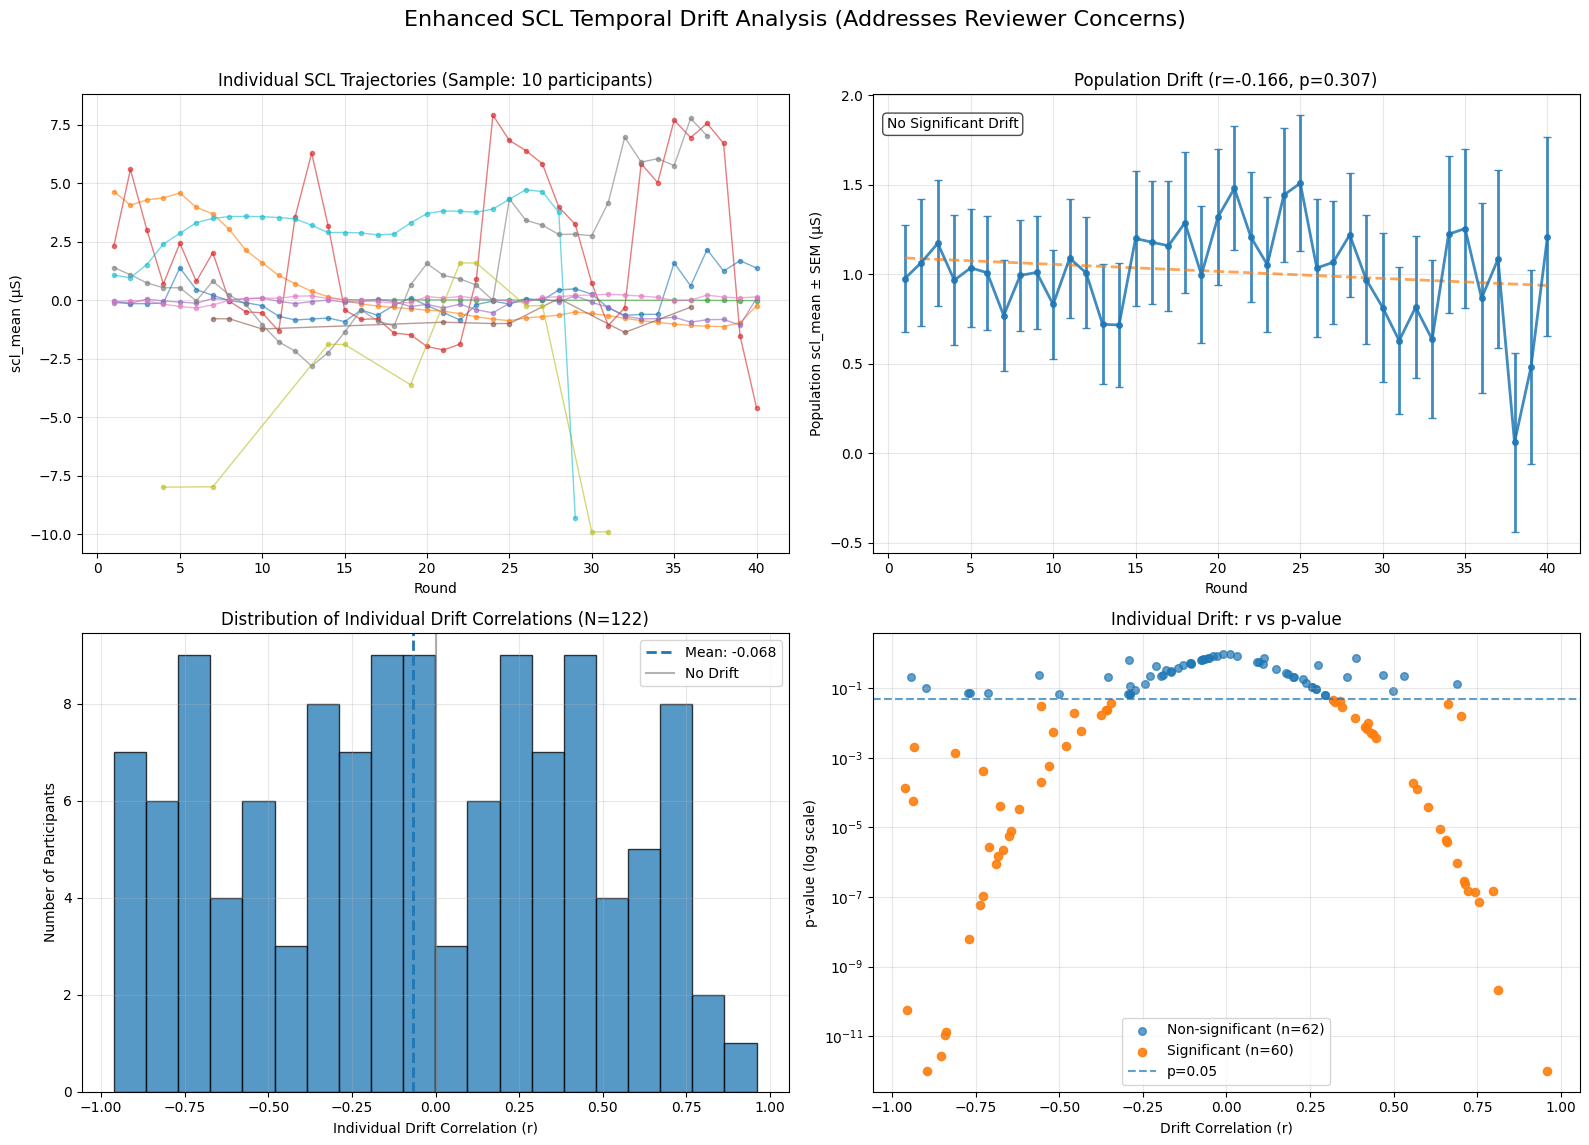


📊 ENHANCED DRIFT ANALYSIS SUMMARY:
🔬 INDIVIDUAL PARTICIPANT ANALYSIS:
   - Participants analyzed: 122
   - Mean drift correlation: -0.0679 ± 0.5166
   - Significant individual drift: 60/122 (49.2%)
   - Positive drift: 54 (44.3%)
   - Negative drift: 68 (55.7%)

📈 POPULATION-LEVEL ANALYSIS:
   - Rounds analyzed: 40
   - Population drift correlation: r=-0.1657, p=0.3070
   - SCL change first→last round: 0.2349 μS
   - Drift per round: 0.006023 μS/round

🧠 SCIENTIFIC INTERPRETATION:
📊 DRIFT MAGNITUDE: SMALL - within acceptable limits
🔬 ANALYSIS IMPACT: ✅ Minimal concern for analysis validity

💾 Saving enhanced drift analysis results...

🏆 CONCLUSION: ✅ TEMPORAL STABILITY CONFIRMED
✅ ENHANCED drift analysis complete!
   📊 Individual metrics: individual_scl_drift_metrics.csv (+ _ENHANCED)
   📈 Round-level data: round_level_scl_means.csv (+ _ENHANCED)
   📋 Summary: drift_analysis_summary_ENHANCED.json
   🖼️ Plot: scl_temporal_drift_analysis.png (+ _ENHANCED)


In [11]:
# 7. SCL TEMPORAL DRIFT ANALYSIS (Addresses Reviewer Concerns)
print("📈 ENHANCED SCL Drift Analysis - Addresses Temporal Stability Concerns...")

from scipy.stats import pearsonr
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import json

# ---- guards
OUTDIR = "/Users/johannanagel/Masterarbeit_Programming/output_postfeedback"
os.makedirs(OUTDIR, exist_ok=True)

# ===== LOAD DATA FROM PREVIOUS PROCESSING =====
print("📂 Loading processed EDA data...")

try:
    # Main dataset
    df_analysis = pd.read_csv(os.path.join(OUTDIR, "eda_decision_windows_features.csv"))
    # Baselines (not strictly needed here, but useful to sanity-check pipeline completeness)
    df_baselines = pd.read_csv(os.path.join(OUTDIR, "eda_subjects_baseline_tonic.csv"))
    
    print(f"✅ Data loaded:")
    print(f"   - Main dataset: {len(df_analysis):,} windows from {df_analysis['participant'].nunique()} participants")
    print(f"   - Baselines: {len(df_baselines)} participants")
    
    # Valid windows only
    if 'is_valid' in df_analysis.columns:
        df_analysis = df_analysis[df_analysis['is_valid'] == True].copy()
    
    # Dtypes
    df_analysis['round'] = pd.to_numeric(df_analysis['round'], errors='coerce').astype('Int64')
    df_analysis['participant'] = df_analysis['participant'].astype(str)
    df_analysis['session'] = df_analysis['session'].astype(str)
    
    # Drop rows with invalid round
    before = len(df_analysis)
    df_analysis = df_analysis.dropna(subset=['round']).copy()
    print(f"   - Valid windows after cleaning: {len(df_analysis):,} (removed {before - len(df_analysis)})")
    
except FileNotFoundError as e:
    print(f"❌ ERROR: Could not load data files! Missing: {e}")
    print(f"   Please run Cell 4 first to generate the data files in: {OUTDIR}")
    raise

if len(df_analysis) == 0:
    raise ValueError("❌ No valid EDA windows available for drift analysis")

# ===== CHOOSE SCL COLUMN =====
# Prefer detrended if available, else fall back to scl_mean
SCL_COL = 'scl_mean_detrended' if 'scl_mean_detrended' in df_analysis.columns else 'scl_mean'
if SCL_COL not in df_analysis.columns:
    raise ValueError(f"❌ Neither 'scl_mean_detrended' nor 'scl_mean' present in dataset; columns found: {list(df_analysis.columns)}")
print(f"🔧 Using SCL column for drift: {SCL_COL}")

# ===== EXTRACT SCL TIME-SERIES FOR DRIFT ANALYSIS =====
print("\n🔍 Extracting SCL time-series for enhanced drift analysis...")

def get_representative_window(group):
    """
    Select one representative window per participant per round.
    Priority (types): during_feedback > post_feedback > post_decision > during_decision > pre_decision
    Priority (durations): 5s > 3s > 10s
    """
    type_priority = ['during_feedback', 'post_feedback', 'post_decision', 'during_decision', 'pre_decision']
    dur_priority = [5, 3, 10]
    for wtype in type_priority:
        subset = group[group['window_type'] == wtype]
        if len(subset) > 0:
            for dur in dur_priority:
                pick = subset[subset['window_sec'] == dur]
                if len(pick) > 0:
                    return pick.iloc[0]
    # Fallback: anything
    return group.iloc[0]

# Build representative series per (participant, round)
cols_needed = ['participant','session','round','window_type','window_sec', SCL_COL]
missing_cols = [c for c in cols_needed if c not in df_analysis.columns]
if missing_cols:
    raise ValueError(f"❌ Missing required columns for drift analysis: {missing_cols}")

scl_temporal = (df_analysis[cols_needed]
                .groupby(['participant', 'round'], group_keys=False)
                .apply(get_representative_window)
                .reset_index(drop=True))

# Diagnostic: which window types were used as representative?
rep_counts = scl_temporal['window_type'].value_counts().to_dict()
print(f"✅ Representative time-series built: {len(scl_temporal)} points from {scl_temporal['participant'].nunique()} participants")
print(f"   Window types used as representative: {rep_counts}")

if len(scl_temporal) == 0:
    print("Available window types in df_analysis:", df_analysis['window_type'].unique())
    print("Available window durations:", df_analysis['window_sec'].unique())
    raise ValueError("❌ No suitable windows for drift analysis")

# ===== INDIVIDUAL PARTICIPANT DRIFT ANALYSIS =====
print("\n🔬 Computing individual participant drift correlations...")

individual_drift_results = []
n_participants_to_process = scl_temporal['participant'].nunique()
print(f"🔍 Processing {n_participants_to_process} participants...")

for participant in scl_temporal['participant'].unique():
    pdata = scl_temporal[scl_temporal['participant'] == participant].copy()
    # Require at least 3 rounds
    if len(pdata) < 3:
        continue
    pdata = pdata.sort_values('round')
    scl_vals = pd.to_numeric(pdata[SCL_COL], errors='coerce').values.astype(float)
    rnd_vals = pd.to_numeric(pdata['round'], errors='coerce').values.astype(float)
    # Remove NaNs
    valid = ~(np.isnan(scl_vals) | np.isnan(rnd_vals))
    if valid.sum() < 3:
        continue
    scl_vals = scl_vals[valid]
    rnd_vals = rnd_vals[valid]
    # Low variability guard
    if np.nanstd(scl_vals) < 1e-6:
        continue
    try:
        r, p = pearsonr(rnd_vals, scl_vals)
        if np.isnan(r) or np.isnan(p):
            continue
        scl_change = float(scl_vals[-1] - scl_vals[0])
        scl_change_per_round = float(scl_change / max((len(scl_vals) - 1), 1))
        individual_drift_results.append({
            'participant': str(participant),
            'session': str(pdata['session'].iloc[0]),
            'n_rounds': int(len(scl_vals)),
            'drift_correlation': float(r),
            'drift_p_value': float(p),
            'scl_change_total': float(scl_change),
            'scl_change_per_round': float(scl_change_per_round),
            'scl_variability': float(np.nanstd(scl_vals)),
            'scl_range': float(np.nanmax(scl_vals) - np.nanmin(scl_vals)),
            'first_round_scl': float(scl_vals[0]),
            'last_round_scl': float(scl_vals[-1]),
            'representative_pref_types': json.dumps(rep_counts)
        })
    except Exception:
        continue

df_individual_drift = pd.DataFrame(individual_drift_results)
if len(df_individual_drift) == 0:
    raise ValueError("❌ Individual drift analysis produced no results (check variability and rounds per participant)")

df_individual_drift['significant_drift'] = df_individual_drift['drift_p_value'] < 0.05

print(f"✅ Individual drift analysis: {len(df_individual_drift)} participants")
print(f"   Significant drift (p<0.05): {df_individual_drift['significant_drift'].sum()}/{len(df_individual_drift)} "
      f"({df_individual_drift['significant_drift'].mean()*100:.1f}%)")

# ===== POPULATION-LEVEL DRIFT =====
print("\n📊 Computing population-level drift patterns...")

# Round-level mean SCL (using representative windows)
round_level_stats = (scl_temporal
                     .groupby('round')
                     .agg({SCL_COL: ['mean', 'std', 'count'],
                           'participant': 'nunique'}))
round_level_stats.columns = ['scl_mean', 'scl_std', 'scl_count', 'n_participants']
round_level_stats = round_level_stats.reset_index()

# Drift correlation over rounds
try:
    population_drift_corr, population_drift_p = pearsonr(
        round_level_stats['round'].astype(float).values,
        round_level_stats['scl_mean'].astype(float).values
    )
except Exception:
    population_drift_corr, population_drift_p = np.nan, np.nan

print(f"✅ Population-level analysis:")
print(f"   Rounds analyzed: {len(round_level_stats)}")
print(f"   Population drift correlation: r={population_drift_corr:.4f}, p={population_drift_p:.4f}")
print("   🔺 Significant population drift!" if (pd.notna(population_drift_p) and population_drift_p < 0.05)
      else "   ✅ No significant population drift")

# ===== VISUALIZATION =====
print("\n📊 Creating enhanced drift visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Enhanced SCL Temporal Drift Analysis (Addresses Reviewer Concerns)', fontsize=16)

# Plot 1: Individual participant trajectories (sample up to 10)
ax1 = axes[0, 0]
sample_ids = df_individual_drift['participant'].head(min(10, len(df_individual_drift)))
for pid in sample_ids:
    pdata = scl_temporal[scl_temporal['participant'] == pid].sort_values('round')
    y = pd.to_numeric(pdata[SCL_COL], errors='coerce')
    ax1.plot(pdata['round'].astype(float), y.astype(float), 'o-', alpha=0.6, linewidth=1, markersize=3)
ax1.set_xlabel('Round')
ax1.set_ylabel(f'{SCL_COL} (μS)')
ax1.set_title(f'Individual SCL Trajectories (Sample: {len(sample_ids)} participants)')
ax1.grid(True, alpha=0.3)

# Plot 2: Population mean ± SEM with linear trend
ax2 = axes[0, 1]
rounds = round_level_stats['round'].astype(float).values
means = round_level_stats['scl_mean'].astype(float).values
stds  = round_level_stats['scl_std'].astype(float).values
ns    = np.maximum(round_level_stats['n_participants'].astype(float).values, 1.0)
sem   = stds / np.sqrt(ns)
ax2.errorbar(rounds, means, yerr=sem, fmt='o-', capsize=3, capthick=1, markersize=4, linewidth=2, alpha=0.85)
# Trend line
if len(rounds) >= 2 and np.all(np.isfinite(means)):
    z = np.polyfit(rounds, means, 1)
    pfit = np.poly1d(z)
    ax2.plot(rounds, pfit(rounds), '--', alpha=0.7, linewidth=2)
ax2.set_xlabel('Round')
ax2.set_ylabel(f'Population {SCL_COL} ± SEM (μS)')
ax2.set_title(f'Population Drift (r={population_drift_corr:.3f}, p={population_drift_p:.3f})')
ax2.grid(True, alpha=0.3)
ax2.text(0.02, 0.95,
         ('*** Significant Drift ***' if (pd.notna(population_drift_p) and population_drift_p < 0.05)
          else 'No Significant Drift'),
         transform=ax2.transAxes,
         bbox=dict(boxstyle="round", facecolor='white', alpha=0.7),
         fontsize=10, va='top')

# Plot 3: Distribution of individual drift correlations
ax3 = axes[1, 0]
vals = df_individual_drift['drift_correlation'].dropna().values
ax3.hist(vals, bins=20, alpha=0.75, edgecolor='black')
ax3.axvline(np.mean(vals), linestyle='--', linewidth=2, label=f'Mean: {np.mean(vals):.3f}')
ax3.axvline(0, color='gray', linestyle='-', alpha=0.6, label='No Drift')
ax3.set_xlabel('Individual Drift Correlation (r)')
ax3.set_ylabel('Number of Participants')
ax3.set_title(f'Distribution of Individual Drift Correlations (N={len(vals)})')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: p-value vs correlation (log y-scale)
ax4 = axes[1, 1]
pvals = np.clip(df_individual_drift['drift_p_value'].values.astype(float), 1e-12, None)
sig_mask = pvals < 0.05
ax4.scatter(df_individual_drift.loc[~sig_mask, 'drift_correlation'], pvals[~sig_mask],
            alpha=0.7, s=30, label=f'Non-significant (n={(~sig_mask).sum()})')
ax4.scatter(df_individual_drift.loc[sig_mask, 'drift_correlation'], pvals[sig_mask],
            alpha=0.9, s=35, label=f'Significant (n={sig_mask.sum()})')
ax4.axhline(0.05, linestyle='--', alpha=0.7, label='p=0.05')
ax4.set_xlabel('Drift Correlation (r)')
ax4.set_ylabel('p-value (log scale)')
ax4.set_title('Individual Drift: r vs p-value')
ax4.set_yscale('log')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Save under both canonical and ENHANCED names (compatibility with report)
fig_path_enh = os.path.join(OUTDIR, "scl_temporal_drift_analysis_ENHANCED.png")
fig_path_std = os.path.join(OUTDIR, "scl_temporal_drift_analysis.png")
plt.savefig(fig_path_enh, dpi=300, bbox_inches='tight')
plt.savefig(fig_path_std, dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

# ===== SUMMARY STATS & SAVES =====
print(f"\n📊 ENHANCED DRIFT ANALYSIS SUMMARY:")
print("="*60)
print(f"🔬 INDIVIDUAL PARTICIPANT ANALYSIS:")
print(f"   - Participants analyzed: {len(df_individual_drift)}")
print(f"   - Mean drift correlation: {df_individual_drift['drift_correlation'].mean():.4f} ± {df_individual_drift['drift_correlation'].std():.4f}")
print(f"   - Significant individual drift: {df_individual_drift['significant_drift'].sum()}/{len(df_individual_drift)} "
      f"({df_individual_drift['significant_drift'].mean()*100:.1f}%)")
pos_drift = int((df_individual_drift['drift_correlation'] > 0).sum())
neg_drift = int((df_individual_drift['drift_correlation'] < 0).sum())
print(f"   - Positive drift: {pos_drift} ({pos_drift/len(df_individual_drift)*100:.1f}%)")
print(f"   - Negative drift: {neg_drift} ({neg_drift/len(df_individual_drift)*100:.1f}%)")

print(f"\n📈 POPULATION-LEVEL ANALYSIS:")
if len(round_level_stats) >= 2:
    total_change = float(round_level_stats['scl_mean'].iloc[-1] - round_level_stats['scl_mean'].iloc[0])
    per_round = float(total_change / max((len(round_level_stats) - 1), 1))
else:
    total_change, per_round = np.nan, np.nan
print(f"   - Rounds analyzed: {len(round_level_stats)}")
print(f"   - Population drift correlation: r={population_drift_corr:.4f}, p={population_drift_p:.4f}")
print(f"   - SCL change first→last round: {total_change:.4f} μS")
print(f"   - Drift per round: {per_round:.6f} μS/round")

# Interpretation thresholds
if pd.isna(population_drift_corr):
    drift_interpretation = "UNDETERMINED"
    drift_concern = "⚠️ Not enough data to assess population drift"
elif abs(population_drift_corr) < 0.1:
    drift_interpretation = "MINIMAL - excellent temporal stability"
    drift_concern = "✅ No concern for analysis validity"
elif abs(population_drift_corr) < 0.2:
    drift_interpretation = "SMALL - within acceptable limits"
    drift_concern = "✅ Minimal concern for analysis validity"
elif abs(population_drift_corr) < 0.3:
    drift_interpretation = "MODERATE - consider modeling time"
    drift_concern = "⚠️ Add round as covariate or detrend"
else:
    drift_interpretation = "LARGE - substantial temporal trend"
    drift_concern = "❌ Investigate & adjust (detrend / covariate)"

print(f"\n🧠 SCIENTIFIC INTERPRETATION:")
print("="*60)
print(f"📊 DRIFT MAGNITUDE: {drift_interpretation}")
print(f"🔬 ANALYSIS IMPACT: {drift_concern}")

print(f"\n💾 Saving enhanced drift analysis results...")

# Save individual metrics (both names)
df_individual_drift.to_csv(os.path.join(OUTDIR, "individual_scl_drift_metrics_ENHANCED.csv"), index=False)
df_individual_drift.to_csv(os.path.join(OUTDIR, "individual_scl_drift_metrics.csv"), index=False)

# Save round-level means (both names)
round_level_stats.to_csv(os.path.join(OUTDIR, "round_level_scl_means_ENHANCED.csv"), index=False)
round_level_stats.to_csv(os.path.join(OUTDIR, "round_level_scl_means.csv"), index=False)

# Save compact CSV too (legacy name used in some scripts)
df_individual_drift.to_csv(os.path.join(OUTDIR, "eda_scl_drift_analysis.csv"), index=False)

# Save JSON summary
drift_summary = {
    'analysis_timestamp': pd.Timestamp.now().isoformat(),
    'n_participants_analyzed': int(len(df_individual_drift)),
    'n_rounds_analyzed': int(len(round_level_stats)),
    'n_total_timepoints': int(len(scl_temporal)),
    'scl_column_used': SCL_COL,
    'representative_window_type_counts': rep_counts,
    'individual_drift_mean': float(df_individual_drift['drift_correlation'].mean()),
    'individual_drift_std': float(df_individual_drift['drift_correlation'].std()),
    'individual_drift_significant_count': int(df_individual_drift['significant_drift'].sum()),
    'individual_drift_significant_percentage': float(df_individual_drift['significant_drift'].mean() * 100),
    'population_drift_correlation': float(population_drift_corr) if pd.notna(population_drift_corr) else None,
    'population_drift_p_value': float(population_drift_p) if pd.notna(population_drift_p) else None,
    'population_drift_significant': bool(pd.notna(population_drift_p) and (population_drift_p < 0.05)),
    'scl_change_first_to_last_round': float(total_change) if pd.notna(total_change) else None,
    'drift_interpretation': drift_interpretation,
    'analysis_validity_concern': drift_concern,
    'methodological_recommendation': ('Include temporal covariate / detrend'
                                      if (not pd.isna(population_drift_corr) and abs(population_drift_corr) > 0.2)
                                      else 'No temporal adjustment needed')
}
with open(os.path.join(OUTDIR, "drift_analysis_summary_ENHANCED.json"), 'w') as f:
    json.dump(drift_summary, f, indent=2)

# Final concise conclusion print (safe formatting)
conclusion = ("⚠️ MODERATE DRIFT — consider temporal covariates"
              if (pd.notna(population_drift_corr) and abs(population_drift_corr) > 0.2)
              else "✅ TEMPORAL STABILITY CONFIRMED")
print(f"\n🏆 CONCLUSION: {conclusion}")

print("✅ ENHANCED drift analysis complete!")
print("   📊 Individual metrics: individual_scl_drift_metrics.csv (+ _ENHANCED)")
print("   📈 Round-level data: round_level_scl_means.csv (+ _ENHANCED)")
print("   📋 Summary: drift_analysis_summary_ENHANCED.json")
print("   🖼️ Plot: scl_temporal_drift_analysis.png (+ _ENHANCED)")

In [12]:
# 8. SCR METHOD USAGE & AMPLITUDE SANITY CHECK

import os
import numpy as np
import pandas as pd

OUTDIR = "/Users/johannanagel/Masterarbeit_Programming/output_postfeedback"
features_path = os.path.join(OUTDIR, "eda_decision_windows_features.csv")

print("🔬 Auditing SCR methods and amplitudes...")

if not os.path.exists(features_path):
    raise FileNotFoundError(f"Features file not found: {features_path}")

df = pd.read_csv(features_path)

# Guard: ensure 'scr_method' exists
if 'scr_method' not in df.columns:
    df['scr_method'] = 'unknown'
else:
    df['scr_method'] = df['scr_method'].fillna('none')

# Guard: ensure numeric columns are numeric (no-op if already ok)
for col in ['scr_count','scr_amplitude']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Basic overall
n = len(df)
detected = (df['scr_count'].fillna(0) > 0) if 'scr_count' in df.columns else pd.Series([False]*n)
print(f"Total windows: {n:,}")
print(f"Windows with ≥1 SCR: {detected.sum():,} ({100*detected.mean():.1f}%)")

# Overall method usage
method_counts = df['scr_method'].value_counts(dropna=False)
print("\n📊 Method usage (overall):")
for m, c in method_counts.items():
    print(f"  - {m}: {c:,} ({100*c/n:.1f}%)")

# Method usage when SCR detected
if detected.any():
    method_counts_pos = df.loc[detected, 'scr_method'].value_counts(dropna=False)
    print("\n📊 Method usage among windows WITH SCRs:")
    for m, c in method_counts_pos.items():
        print(f"  - {m}: {c:,} ({100*c/len(df.loc[detected]):.1f}%)")

# Amplitude sanity by method
if {'scr_amplitude','scr_method'}.issubset(df.columns):
    print("\n📈 SCR amplitude by method (windows with SCRs):")
    tmp = df.loc[detected, ['scr_method', 'scr_amplitude']].copy()
    # drop impossible values quietly
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna(subset=['scr_amplitude'])
    g = (tmp.groupby('scr_method', dropna=False)['scr_amplitude']
            .agg(['count','mean','std','median','min','max'])
            .sort_values('median', ascending=False))
    print(g.to_string(float_format=lambda x: f"{x:.6f}"))

# By window_type (useful to check imbalance)
print("\n🪟 Detection rate by window_type:")
if 'window_type' in df.columns:
    wt = (df
          .groupby('window_type')
          .apply(lambda x: pd.Series({
              'n_windows': len(x),
              'detected_rate_%': 100*(x['scr_count'].fillna(0)>0).mean() if 'scr_count' in x else np.nan,
              'median_scrs': x.loc[x['scr_count'].fillna(0)>0, 'scr_count'].median() if 'scr_count' in x and (x['scr_count'].fillna(0)>0).any() else 0.0,
              'median_amp': x.loc[x['scr_count'].fillna(0)>0, 'scr_amplitude'].median() if {'scr_count','scr_amplitude'}.issubset(x.columns) and (x['scr_count'].fillna(0)>0).any() else np.nan
          }))
          .sort_values('detected_rate_%', ascending=False))
    print(wt.to_string(float_format=lambda v: f"{v:.3f}"))
else:
    print("window_type column not found.")

# Top participants with low detection (QA)
print("\n👀 Participants with lowest detection rates (top 10 with ≥50 windows):")
if {'participant','scr_count'}.issubset(df.columns):
    det_by_p = (df.groupby('participant')
                  .apply(lambda x: pd.Series({
                      'n_windows': len(x),
                      'detected_rate_%': 100*(x['scr_count'].fillna(0)>0).mean()
                  }))
                  .query('n_windows >= 50')
                  .sort_values('detected_rate_%', ascending=True)
                  .head(10))
    print(det_by_p.to_string(float_format=lambda v: f"{v:.1f}"))
else:
    print("participant / scr_count columns missing.")

🔬 Auditing SCR methods and amplitudes...
Total windows: 50,768
Windows with ≥1 SCR: 37,433 (73.7%)

📊 Method usage (overall):
  - method2_thr: 29,231 (57.6%)
  - none: 13,335 (26.3%)
  - method3_p95: 1,879 (3.7%)
  - thr_0.0007: 135 (0.3%)
  - thr_0.0006: 120 (0.2%)
  - thr_0.0008: 116 (0.2%)
  - thr_0.0009: 106 (0.2%)
  - thr_0.0001: 99 (0.2%)
  - thr_0.0005: 93 (0.2%)
  - thr_0.0003: 81 (0.2%)
  - thr_0.0010: 79 (0.2%)
  - thr_0.0004: 75 (0.1%)
  - thr_0.0002: 73 (0.1%)
  - thr_0.0011: 67 (0.1%)
  - thr_0.0012: 57 (0.1%)
  - thr_0.0015: 51 (0.1%)
  - thr_0.0016: 47 (0.1%)
  - thr_0.0018: 42 (0.1%)
  - thr_0.0014: 41 (0.1%)
  - thr_0.0013: 40 (0.1%)
  - thr_0.0021: 37 (0.1%)
  - thr_0.0023: 36 (0.1%)
  - thr_0.0000: 36 (0.1%)
  - thr_0.0017: 33 (0.1%)
  - thr_0.0025: 32 (0.1%)
  - thr_0.0020: 31 (0.1%)
  - thr_0.0019: 30 (0.1%)
  - thr_0.0024: 29 (0.1%)
  - thr_0.0022: 24 (0.0%)
  - thr_0.0035: 24 (0.0%)
  - thr_0.0026: 24 (0.0%)
  - thr_0.0051: 23 (0.0%)
  - thr_0.0028: 22 (0.0%)
  -

In [13]:
# 9. FEEDBACK COLUMNS AUDIT & OPTIONAL FALLBACK
import glob, os, pandas as pd, numpy as np

print("🔎 Auditing feedback anchors across session logs...")

sessions = glob.glob(os.path.join(ROOT_DIR, "*"))
row_list = []

# Probe a few representative rounds to detect naming patterns
probe_rounds = list(range(1, 6))
for sess in sessions:
    if not os.path.isdir(sess): 
        continue
    log_files = glob.glob(os.path.join(sess, "all_apps_wide-*.csv"))
    if not log_files:
        continue
    try:
        log_df = pd.read_csv(log_files[0], nrows=5)  # read header/first rows only
        cols = set(log_df.columns.astype(str))
    except Exception:
        continue
    # Search any column that contains 'feedback' & '.player.'
    fb_like = sorted([c for c in cols if ('.player.' in c.lower() and 'feedback' in c.lower())])
    for r in probe_rounds:
        exact = f"stockmarket.{r}.player.feedback_start"
        alt_for_round = sorted([c for c in fb_like if f"stockmarket.{r}." in c.lower()])
        row_list.append({
            'session': os.path.basename(sess),
            'round': r,
            'has_exact_feedback_start': exact in cols,
            'alternatives_found': "; ".join(alt_for_round[:8])  # show up to 8
        })

audit_df = pd.DataFrame(row_list)
if len(audit_df) == 0:
    raise ValueError("No sessions/logs scanned. Check ROOT_DIR or file naming.")

print("\n🧭 Feedback column presence (exact name): stockmarket.{r}.player.feedback_start")
presence = (audit_df
            .groupby('session')['has_exact_feedback_start']
            .mean()
            .sort_values(ascending=False))
print(presence.to_string())

print("\n🔤 Alternative columns containing 'feedback' found (sample):")
examples = (audit_df[audit_df['alternatives_found'] != ""]
            .groupby('session')
            .head(1)[['session','alternatives_found']])
print(examples.to_string(index=False))

# Optional: build a mapping of common alternatives if present
# (We DO NOT modify the dataset here; this is just to suggest a mapping.)
suggested_map = {}
for _, row in audit_df.iterrows():
    if row['alternatives_found']:
        for col in row['alternatives_found'].split("; "):
            key = col.strip()
            suggested_map[key] = suggested_map.get(key, 0) + 1

suggested_map_sorted = sorted(suggested_map.items(), key=lambda x: x[1], reverse=True)
print("\n💡 Most frequent alternative feedback columns across sessions:")
for k, c in suggested_map_sorted[:15]:
    print(f"  - {k}  (hits: {c})")
    

# --------- OPTIONAL FALLBACK (commented) ----------
# If your logs never contain stockmarket.{r}.player.feedback_start but contain e.g. a column like
# 'stockmarket.{r}.player.feedback_onset' or similar, you can:
#
# 1) Add a small alias resolver in Cell 4, before window extraction:
#
# def get_feedback_anchor(participant_row, r):
#     candidates = [
#         f"stockmarket.{r}.player.feedback_start",
#         f"stockmarket.{r}.player.feedback_onset",
#         f"stockmarket.{r}.player.feedback_time",
#         f"stockmarket.{r}.player.feedbackStart"
#     ]
#     for col in candidates:
#         if col in participant_row and pd.notna(participant_row[col].iloc[0]):
#             return int(participant_row[col].iloc[0])
#     return None
#
# 2) Replace the direct access with:
#    feedback_start = get_feedback_anchor(participant_row, round_i)
#
# 3) If truly no feedback anchor exists, consider labeling a 3–5s window starting at account_start
#    as 'during_feedback_inferred' (and keep 'post_feedback' as-is). That preserves comparabilità.


🔎 Auditing feedback anchors across session logs...

🧭 Feedback column presence (exact name): stockmarket.{r}.player.feedback_start
session
02-07-2024_14.15 (pre LSL)    0.0
02-07-2024_16.30 (pre LSL)    0.0
28_11_2024                    0.0
28-08-2024_15.15              0.0
28-05-2024_17.15 (pre LSL)    0.0
28-05-2024_14.30 (pre LSL)    0.0
27_11_2024                    0.0
27-08-2024_13.45              0.0
26_11_2024                    0.0
23-07-2024_16.15              0.0
23-07-2024_13.45              0.0
21_11_2024 (no fMRI)          0.0
20-08-2024_16.15(no fMRI)     0.0
20-08-2024_13.45(no fMRI)     0.0
19_11_2024                    0.0
17-07-2024_15.15 (no fMRI)    0.0
17-07-2024_12.15              0.0
14_11_2024                    0.0
14-08-2024_15.15              0.0
13_11_2024                    0.0
13-08-2024_13.45 (No fMRI)    0.0
12_11_2024                    0.0
07_11_2024                    0.0
06-08-2024_13.15              0.0
03-07-2024_15.15 (pre LSL)    0.0
29-05-2024_

In [14]:
# 10. VISUAL QC FOR FLAGGED PARTICIPANTS — v2

import os, glob, io, contextlib, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- CONFIG ----------------
ROOT_DIR = globals().get("ROOT_DIR", "/Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions")
OUTDIR   = "/Users/johannanagel/Masterarbeit_Programming/output_postfeedback"
FEATURES = os.path.join(OUTDIR, "eda_decision_windows_features.csv")

KEEP_ONLY_INCLUDED = True  # set False if you want to QC everyone in FEATURES
INCLUDED_PATH = os.path.join(OUTDIR, "analysis_subjects.csv")
EXCLUSIONS_PATH = os.path.join(OUTDIR, "participant_exclusions.csv")

SNIPPET_SEC       = 120
START_OFFSET_SEC  = 20 * 60  # start plotting at +20 minutes
TIGHT_FS_BAND_EFF = (900, 1100)
WIDE_FS_BAND_EFF  = (800, 1300)
ROBUST_FS_BAND_XDF = (950, 1050)  # for fs_xdf

os.makedirs(os.path.join(OUTDIR, "qc_plots"), exist_ok=True)

warnings.filterwarnings("ignore")  # quiet most library warnings

# --------------- Load features ---------------
df = pd.read_csv(FEATURES)
must = {'session','participant','scr_count','signal_range','frac_nan','fs_eff','window_type','window_sec','scl_mean'}
missing = [c for c in must if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns in FEATURES: {missing}")

# Optional: keep only subjects included in main analyses (and remove known exclusions)
if KEEP_ONLY_INCLUDED and os.path.exists(INCLUDED_PATH):
    keep = pd.read_csv(INCLUDED_PATH)[["session","participant"]].drop_duplicates()
    df = df.merge(keep.assign(in_analysis=True), on=["session","participant"], how="inner")
else:
    df = df.copy()

if KEEP_ONLY_INCLUDED and os.path.exists(EXCLUSIONS_PATH):
    exc = pd.read_csv(EXCLUSIONS_PATH)
    # Remove whole sessions marked with participant=ALL
    exc_sessions = set(exc.loc[exc["participant"].astype(str).str.upper().eq("ALL"), "session"])
    if exc_sessions:
        df = df[~df["session"].isin(exc_sessions)]
    # Remove specific (session, participant) pairs
    exc_pairs = exc.loc[~exc["participant"].astype(str).str.upper().eq("ALL"), ["session","participant"]]
    if not exc_pairs.empty:
        df = df.merge(exc_pairs.assign(excluded=True), on=["session","participant"], how="left")
        df = df[~df["excluded"].fillna(False)].drop(columns=["excluded"])

# --------- Per-window helper metrics for warnings ---------
# Sudden jump rate (approx): range per second for each window
df["jump_rate"] = df["signal_range"] / df["window_sec"].replace(0, np.nan)

# --------------- Aggregation per participant ---------------
agg_core = (df.groupby(['session','participant'], as_index=False)
            .agg(n_windows=('scr_count','size'),
                 scr_rate=('scr_count', lambda s: float(np.mean(np.asarray(s) > 0.0))),
                 mean_signal_range=('signal_range','mean'),
                 frac_nan_mean=('frac_nan','mean'),
                 median_fs_eff=('fs_eff','median'),
                 frac_fs_outwide=('fs_eff', lambda s: float(np.mean((s < WIDE_FS_BAND_EFF[0]) | (s > WIDE_FS_BAND_EFF[1])))),
                 scl_min=('scl_mean','min'),
                 scl_max=('scl_mean','max'))
            )

# Add max jump rate
agg_jump = (df.groupby(['session','participant'], as_index=False)
              .agg(max_jump_rate=('jump_rate','max')))
grp = agg_core.merge(agg_jump, on=['session','participant'], how='left')

# --------------- Raw resolver (H5 preferred, fallback XDF) ---------------
RAW_GLOBS = [
    "{root}/{session}/HEP/{pid}.h5",
    "{root}/{session}/{pid}.h5",
    "{root}/{session}/HEP_*{pid}*.h5",
    "{root}/{session}/**/*{pid}*.h5",
    "{root}/{session}/HEP_{pid}.xdf",
    "{root}/{session}/{pid}.xdf",
    "{root}/{session}/**/*{pid}*.xdf",
]

def _find_raw_candidates(session, pid, root):
    tried, hits = [], []
    for pat in RAW_GLOBS:
        g = pat.format(root=root, session=session, pid=pid)
        tried.append(g)
        hits.extend(glob.glob(g, recursive=True))
    uniq = []
    for h in hits:
        if h not in uniq: uniq.append(h)
    # prefer H5 over XDF; shorter paths first
    uniq = sorted(uniq, key=lambda p: (p.lower().endswith(".xdf"), len(p)))
    return uniq, tried

def _load_h5_basic(path):
    try:
        import h5py
        with h5py.File(path, "r") as f:
            cand = []
            for k in f.keys():
                try:
                    v = np.asarray(f[k])
                    if v.ndim == 1 and v.size > 1000:
                        cand.append((k, v))
                except Exception:
                    pass
            ts, eda = None, None
            for k, v in cand:
                lk = k.lower()
                if ts is None and any(x in lk for x in ['timestamps_ms','timestamps','ts_ms','time_ms','ts']):
                    ts = v.astype(float)
                if eda is None and any(x in lk for x in ['eda','signal','values']):
                    eda = v.astype(float)
            if eda is None and cand:
                eda = max(cand, key=lambda kv: np.nanstd(kv[1]))[1].astype(float)
            if ts is None:
                fs_attr = f.attrs.get('fs', None)
                if fs_attr is None:
                    return None
                ts = np.arange(len(eda), dtype=float) * 1000.0 / float(fs_attr)
            fs_eff = 1000.0 / np.nanmedian(np.diff(ts)) if ts.size > 1 else np.nan
            return {"ts_ms": ts, "eda": eda, "fs": fs_eff, "src": path}
    except Exception:
        return None

def _load_xdf_basic(path):
    try:
        import pyxdf
        with contextlib.redirect_stdout(io.StringIO()):  # silence "Calculated effective sampling rate ..." prints
            streams, _ = pyxdf.load_xdf(path, synchronize_clocks=True,
                                        handle_clock_resets=True, dejitter_timestamps=True)
        for s in streams:
            name = s['info'].get('name', [''])[0].lower()
            arr = np.asarray(s.get('time_series', []))
            if 'opensignals' in name and arr.ndim >= 2 and arr.shape[1] > 1:
                ts = np.asarray(s['time_stamps'])
                if ts.size < 2:
                    continue
                fs_eff = 1.0 / np.median(np.diff(ts))
                eda = arr[:, 1].astype(float)  # channel 1 = EDA0
                ts_ms = (ts - ts[0]) * 1000.0
                return {"ts_ms": ts_ms, "eda": eda, "fs": fs_eff, "src": path}
        return None
    except Exception:
        return None

def _load_raw_for(session, pid):
    cands, tried = _find_raw_candidates(session, pid, ROOT_DIR)
    for p in cands:
        info = _load_h5_basic(p) if p.lower().endswith(".h5") else _load_xdf_basic(p)
        if info is not None:
            return info, tried
    return None, tried

# --------------- Compute fs_xdf (robust clock) ---------------
# Try to estimate fs from XDF only; if not found, leave NaN and rely on fs_eff criteria
def _estimate_fs_xdf(session, pid):
    # prioritize XDF candidates only
    xdf_pats = [
        f"{ROOT_DIR}/{session}/HEP_{pid}.xdf",
        f"{ROOT_DIR}/{session}/{pid}.xdf",
        f"{ROOT_DIR}/{session}/**/*{pid}*.xdf",
    ]
    hits = []
    for pat in xdf_pats:
        hits.extend(glob.glob(pat, recursive=True))
    hits = sorted(set(hits), key=len)
    for path in hits:
        info = _load_xdf_basic(path)
        if info is not None and np.isfinite(info["fs"]):
            return float(info["fs"])
    return np.nan

fs_rows = []
for sess, pid in grp[['session','participant']].itertuples(index=False):
    fs_val = _estimate_fs_xdf(sess, pid)
    fs_rows.append({"session": sess, "participant": pid, "fs_xdf": fs_val})
fsdf = pd.DataFrame(fs_rows)
grp = grp.merge(fsdf, on=['session','participant'], how='left')

# --------------- QC criteria ---------------
# A) Very low SCR detection across many windows but with non-trivial variability
crit_A = (grp['scr_rate'] < 0.05) & (grp['n_windows'] >= 300) & (grp['mean_signal_range'] >= 0.05)

# B) Dropout / contact issues
crit_B = (grp['frac_nan_mean'] >= 0.05)

# C) Robust clock anomalies
has_fs_xdf = grp['fs_xdf'].notna()
crit_C_xdf = has_fs_xdf & ((grp['fs_xdf'] < ROBUST_FS_BAND_XDF[0]) | (grp['fs_xdf'] > ROBUST_FS_BAND_XDF[1]))
crit_C_eff = (~has_fs_xdf) & (
    ((grp['median_fs_eff'] < TIGHT_FS_BAND_EFF[0]) | (grp['median_fs_eff'] > TIGHT_FS_BAND_EFF[1]))
    & (grp['frac_fs_outwide'] > 0.10)
)
crit_C = crit_C_xdf | crit_C_eff

# D) Large amplitude excursions suggesting movement
crit_D = (grp['mean_signal_range'] >= 3.0)

# Warnings (non-severity):
warn_F = (grp['scl_min'] < -1.0) | (grp['scl_max'] > 25.0)            # unphysiological SCL range
warn_H = (grp['max_jump_rate'] > 2.0)                                  # >2 µS/s jump rate

# --------------- Tag reasons / severity ---------------
reasons, severity, warns = [], [], []
for i, row in grp.iterrows():
    r, sev, w = [], 0, []
    if crit_A.iloc[i]: r.append("low_SCR_rate");        sev += 3
    if crit_B.iloc[i]: r.append("high_dropout_nan");    sev += 2
    if crit_C.iloc[i]:
        r.append("clock_fs_anomaly_xdf" if has_fs_xdf.iloc[i] else "clock_fs_anomaly_eff")
        sev += 1
    if crit_D.iloc[i]: r.append("huge_range");          sev += 1
    if warn_F.iloc[i]: w.append("unphysiological_values")
    if warn_H.iloc[i]: w.append("sudden_jumps>2uS/s")
    reasons.append(";".join(r))
    severity.append(sev)
    warns.append(";".join(w))

grp['reasons']  = reasons
grp['severity'] = severity
grp['warnings'] = warns

flagged = grp[grp['severity'] > 0].copy()
flagged = flagged.sort_values(['severity','scr_rate','mean_signal_range'], ascending=[False, True, False]).reset_index(drop=True)

# --------------- Save QC table ---------------
qc_csv = os.path.join(OUTDIR, "qc_dubbi_participants.csv")
flagged.to_csv(qc_csv, index=False)
print(f"✅ QC 2.0 — 'Dubbi davvero' participants: {len(flagged)} (saved: {qc_csv})")

# --------------- Plotting helpers ---------------
def _plot_qc(ts, raw, fs, title, outpath):
    import neurokit2 as nk
    fs_i = max(10, int(round(fs if np.isfinite(fs) else 10)))
    clean = nk.eda_clean(raw, sampling_rate=fs_i, method="neurokit")
    # Derive phasic (high-pass); if it fails, fall back to a scaled version
    try:
        ph = nk.eda_phasic(clean, sampling_rate=fs_i, method='highpass')
        tonic  = np.asarray(ph['EDA_Tonic'])
        phasic = np.asarray(ph['EDA_Phasic'])
    except Exception:
        tonic  = clean
        phasic = clean - pd.Series(clean).rolling(window=max(5, fs_i//2), min_periods=1, center=True).mean().to_numpy()
    # Scale phasic for overlay visibility
    denom = (np.nanstd(phasic) + 1e-9)
    ph_scaled = phasic / denom * (0.2 * np.nanpercentile(np.abs(tonic), 95))
    plt.figure(figsize=(10,4))
    t = ts / 1000.0
    plt.plot(t, raw, label="raw")
    plt.plot(t, tonic, label="tonic(clean)")
    plt.plot(t, ph_scaled, label="phasic (scaled)")
    plt.xlabel("time (s)"); plt.ylabel("EDA (µS)")
    plt.title(title); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(outpath, dpi=160, bbox_inches="tight"); plt.close()

# --------------- Generate plots ---------------
made = 0
rows = []
for rank, r in flagged.reset_index().iterrows():
    sess, pid = r['session'], r['participant']
    info, tried = _load_raw_for(sess, pid)
    plot_path = os.path.join(OUTDIR, "qc_plots", f"{rank:03d}_{sess}_{pid}_qc.png")
    status, note = "plotted", ""
    if info is None:
        status = "not_found"; note = "no readable raw (H5/XDF)."
    else:
        ts, y, fs = info['ts_ms'], info['eda'], info['fs']
        if ts.size < 2 or y.size < 2:
            status = "too_short"; note = "raw too short"
        else:
            start_ms = ts[0] + START_OFFSET_SEC * 1000.0
            end_ms   = start_ms + SNIPPET_SEC * 1000.0
            m = (ts >= start_ms) & (ts < end_ms)
            if m.sum() < 100:
                status = "too_short"; note = "snippet <100 samples"
            else:
                title = f"{sess} | {pid} | reasons={r['reasons']} | warn={r['warnings']} | fs_xdf≈{r.get('fs_xdf', np.nan):.1f} Hz"
                try:
                    _plot_qc(ts[m], y[m], fs, title, plot_path)
                    made += 1
                except Exception as e:
                    status = "plot_error"; note = str(e)[:180]
    rows.append({
        **{k: (None if isinstance(v, (pd.Series, pd.DataFrame)) else v) for k, v in r.to_dict().items()},
        "plot_status": status,
        "plot_path": (plot_path if status == "plotted" else ""),
        "note": note
    })

qc_vis = pd.DataFrame(rows).sort_values(["severity","scr_rate"], ascending=[False, True])
qc_vis_file = os.path.join(OUTDIR, "qc_dubbi_participants_VIS.csv")
qc_vis.to_csv(qc_vis_file, index=False)

print(f"🖼️ Plots generated: {made}/{len(flagged)}  →  {os.path.join(OUTDIR,'qc_plots')}")
print(f"💾 Plotting report: {qc_vis_file}")



Stream 2: Calculated effective sampling rate 1191.0675 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1191.0675 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1172.2613 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1172.2613 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1328.5112 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1328.5112 Hz is different from specified rate 2000.0000 Hz.
Stream 3: Calculated effective sampling rate 1273.2996 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1273.2996 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1185.9269 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1185.9269 

✅ QC 2.0 — 'Dubbi davvero' participants: 11 (saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/qc_dubbi_participants.csv)


Stream 1: Calculated effective sampling rate 1663.5900 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1203.7730 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1493.5784 Hz is different from specified rate 2000.0000 Hz.
Stream 4: Calculated effective sampling rate 215.3800 Hz is different from specified rate 250.0000 Hz.
Stream 1: Calculated effective sampling rate 1500.4481 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1182.8837 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1184.7483 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1501.9584 Hz is different from specified rate 2000.0000 Hz.
Stream 1: Calculated effective sampling rate 1611.3515 Hz is different from specified rate 2000.0000 Hz.
Stream 2: Calculated effective sampling rate 1510.1083 Hz

🖼️ Plots generated: 11/11  →  /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/qc_plots
💾 Plotting report: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/qc_dubbi_participants_VIS.csv


In [15]:
# 11. Analysis pack & SCR methods report (READ-ONLY, zero changes upstream)

import os, json
import numpy as np
import pandas as pd

OUTDIR = "/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/"
FEATURES = os.path.join(OUTDIR, "eda_decision_windows_features.csv")

# --- 0) Load already-extracted features
df = pd.read_csv(FEATURES)

req = {"session","participant","round","window_type","window_sec",
       "scl_mean","scl_std","scr_count","scr_auc","fs_eff","signal_range","frac_nan"}
missing = [c for c in req if c not in df.columns]
if missing:
    raise ValueError(f"Required feature columns are missing: {missing}")

# --- 1) Freeze exclusions (does NOT modify upstream df, just flags 'include')
to_exclude = set()

# a) XDF mismatch (35)
p = os.path.join(OUTDIR, "xdf_mismatch_full_audit.csv")
if os.path.exists(p):
    aud = pd.read_csv(p)
    for _, r in aud[['session','missing_pid']].dropna().iterrows():
        to_exclude.add((str(r['session']), str(r['missing_pid'])))

# b) Baseline = 0 (4)
p = os.path.join(OUTDIR, "baseline_zero_full_audit.csv")
if os.path.exists(p):
    bz = pd.read_csv(p)
    for _, r in bz[['session','participant']].dropna().iterrows():
        to_exclude.add((str(r['session']), str(r['participant'])))

# c) Exclusion log (optional)
p = os.path.join(OUTDIR, "exclusion_log.csv")
if os.path.exists(p):
    el = pd.read_csv(p)
    for _, r in el[['session','participant','reason']].dropna().iterrows():
        to_exclude.add((str(r['session']), str(r['participant'])))

# Exclusions table “freeze”
ex_rows = [{"session": s, "participant": pid} for (s,pid) in sorted(to_exclude)]
ex_df = pd.DataFrame(ex_rows).drop_duplicates()
ex_file = os.path.join(OUTDIR, "participant_exclusions.csv")
ex_df.to_csv(ex_file, index=False)

# Flag 'include'
df['include'] = ~df[['session','participant']].apply(tuple, axis=1).isin(to_exclude)

# --- 2) Per-window derived metrics (only from already-present columns)
df['scr_per_sec']   = df['scr_count'] / df['window_sec'].replace(0, np.nan)
df['scr_auc_per_s'] = df['scr_auc']   / df['window_sec'].replace(0, np.nan)
df['scr_detected']  = (df['scr_count'] > 0).astype(int)

# within-participant z-score (fix: use df.groupby on the column name)
def z_by_participant(frame, col):
    m = frame.groupby('participant')[col].transform('mean')
    s = frame.groupby('participant')[col].transform('std').replace(0, np.nan)
    return (frame[col] - m) / s

for col in ['scl_mean','scl_std','scr_count','scr_auc','signal_range','fs_eff']:
    df[f'z_{col}'] = z_by_participant(df, col)

# Save “analysis-ready” window level
analysis_windows = os.path.join(OUTDIR, "analysis_windows.csv")
df.to_csv(analysis_windows, index=False)

# --- 3) Convenience aggregations
agg_cols  = ['scl_mean','scl_std','scr_count','scr_per_sec','scr_auc','scr_auc_per_s',
             'signal_range','frac_nan','fs_eff','scr_detected',
             'z_scl_mean','z_scl_std','z_scr_count','z_scr_auc','z_signal_range','z_fs_eff']
agg_funcs = {c: 'mean' for c in agg_cols}
agg_funcs['scr_detected'] = 'mean'  # share with SCR>0

# 3a) participant × round × window_type × window_sec
rounds = (df
    .groupby(['session','participant','round','window_type','window_sec','include'], as_index=False)
    .agg(agg_funcs)  # <-- FIX: no **agg_funcs
)
analysis_rounds = os.path.join(OUTDIR, "analysis_rounds.csv")
rounds.to_csv(analysis_rounds, index=False)

# 3b) participant × window_type × window_sec (average over all rounds)
subjects = (df
    .groupby(['session','participant','window_type','window_sec','include'], as_index=False)
    .agg(agg_funcs)  # <-- FIX: no **agg_funcs
)

# Summary QC covariates per participant
qc_cov = (df
    .groupby(['session','participant'], as_index=False)
    .agg(
        qc_median_fs_eff     = ('fs_eff','median'),
        qc_frac_fs_outwide   = ('fs_eff', lambda s: float(np.mean((s<800) | (s>1300)))),
        qc_mean_signal_range = ('signal_range','mean'),
        qc_frac_nan          = ('frac_nan','mean'),
        qc_scr_rate          = ('scr_detected','mean'),
        n_windows            = ('scr_count','size')
    )
)
subjects = subjects.merge(qc_cov, on=['session','participant'], how='left')

analysis_subjects = os.path.join(OUTDIR, "analysis_subjects.csv")
subjects.to_csv(analysis_subjects, index=False)

# --- 4) SCR methods — summary + description
methods_txt = []
methods_txt.append("SCR methods usage (overall):")
if 'scr_method' in df.columns:
    counts_all = df['scr_method'].fillna('none').value_counts().sort_values(ascending=False)
    methods_txt.append(str(counts_all.to_dict()))
    with_scr = df[df['scr_detected']>0]
    counts_scr = with_scr['scr_method'].fillna('none').value_counts().sort_values(ascending=False)
    methods_txt.append("\nSCR methods usage (among windows WITH SCRs):")
    methods_txt.append(str(counts_scr.to_dict()))
else:
    methods_txt.append("Column 'scr_method' not found in features.")

methods_txt.append("\nMethod descriptions:")
methods_txt.append("- method2_thr: simple thresholding on smoothed phasic signal; "
                   "peaks separated by ≥1 s; threshold = 1.5×SD of values >0. "
                   "Sensitive and fast; good specificity with windows ≥3–5 s.")
methods_txt.append("- method3_p95: positive excursions above the 95th percentile of phasic; "
                   "more conservative (flags only marked responses).")
methods_txt.append("- none: no peaks detected; window valid for SCL but without SCR.")

with open(os.path.join(OUTDIR, "SCR_METHODS_REPORT.txt"), "w") as f:
    f.write("\n".join(methods_txt))

# --- 5) Minimal codebook
codebook = {
  "files": {
    "analysis_windows.csv": "per-window features + include flag; does NOT filter upstream data",
    "analysis_rounds.csv":  "mean per participant×round×window_type×window_sec",
    "analysis_subjects.csv":"mean per participant×window_type×window_sec + QC covariates",
    "participant_exclusions.csv": "frozen list of (session, participant) excluded from reports"
  },
  "columns_windows": {
    "include": "True if (session,participant) is not in the frozen exclusion list",
    "scr_per_sec": "scr_count / window_sec",
    "scr_auc_per_s": "scr_auc / window_sec",
    "scr_detected": "1 if scr_count>0, else 0",
    "z_*": "z-score computed within-participant (mean/std over all their windows)"
  },
  "scr_methods": {
    "method2_thr": "threshold on smoothed phasic, peaks separated ≥1s",
    "method3_p95": "exceedance of the 95th percentile of phasic",
    "none": "no peak detected"
  }
}
with open(os.path.join(OUTDIR, "codebook.json"), "w") as f:
    json.dump(codebook, f, indent=2)

print("✅ Analysis pack written.")
print(f"   • {analysis_windows}")
print(f"   • {analysis_rounds}")
print(f"   • {analysis_subjects}")
print(f"   • {ex_file}")
print(f"   • {os.path.join(OUTDIR, 'SCR_METHODS_REPORT.txt')}")
print(f"   • {os.path.join(OUTDIR, 'codebook.json')}")


✅ Analysis pack written.
   • /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/analysis_windows.csv
   • /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/analysis_rounds.csv
   • /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/analysis_subjects.csv
   • /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/participant_exclusions.csv
   • /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/SCR_METHODS_REPORT.txt
   • /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/codebook.json


In [16]:
# 12. Integrate pre-LSL during_feedback into the MAIN features (atomic & dedup)

import os, shutil, time
import numpy as np
import pandas as pd

OUTDIR   = "/Users/johannanagel/Masterarbeit_Programming/output_postfeedback"
MAIN     = os.path.join(OUTDIR, "eda_decision_windows_features.csv")
PRELSL   = os.path.join(OUTDIR, "prelsl_during_feedback_windows_features.csv")
CAPS_OUT = os.path.join(OUTDIR, "ts_capabilities.csv")

if not os.path.exists(MAIN):
    raise FileNotFoundError(f"Main features file not found: {MAIN}")

df_main = pd.read_csv(MAIN)
print(f"Loaded MAIN features: {df_main.shape} from {MAIN}")

if not os.path.exists(PRELSL):
    print(f"No pre-LSL add-on found at {PRELSL}. Nothing to merge. (OK if you skipped Cell B.)")
    df_merged = df_main.copy()
else:
    df_pre = pd.read_csv(PRELSL)
    print(f"Loaded pre-LSL features: {df_pre.shape} from {PRELSL}")
    
    # keep only during_feedback from add-on
    if "window_type" in df_pre.columns:
        df_pre = df_pre[df_pre["window_type"] == "during_feedback"].copy()
    else:
        print("⚠️ pre-LSL add-on has no 'window_type' column — skipping merge.")
        df_pre = df_pre.iloc[0:0].copy()  # empty
    
    print(f"Pre-LSL after filtering: {df_pre.shape}")
    
    # PRE-MERGE VALIDATION
    print("\n🔍 PRE-MERGE VALIDATION:")
    main_scr_cols = [c for c in df_main.columns if 'scr' in c.lower()]
    addon_scr_cols = [c for c in df_pre.columns if 'scr' in c.lower()]
    print(f"MAIN scr columns: {main_scr_cols}")
    print(f"ADD-ON scr columns: {addon_scr_cols}")
    
    # Check SCR data quality before merge
    for df_name, df in [("MAIN", df_main), ("ADD-ON", df_pre)]:
        if len(df) == 0:
            continue
        scr_cols = [c for c in df.columns if 'scr' in c.lower() and df[c].dtype in ['float64', 'int64']]
        for col in scr_cols:
            non_zero = (df[col] > 0).sum()
            non_nan = (~pd.isna(df[col])).sum()
            print(f"{df_name} {col}: {non_zero}/{non_nan} non-zero/valid")
    
    if len(df_pre) == 0:
        print("No pre-LSL data to merge after filtering.")
        df_merged = df_main.copy()
    else:
        # SMART SCR COLUMN CONVERSION
        # Convert scr_count to scr_per_sec in add-on if needed
        if "scr_count" in df_pre.columns and "window_sec" in df_pre.columns:
            if "scr_per_sec" not in df_pre.columns or df_pre["scr_per_sec"].isna().all():
                df_pre["scr_per_sec"] = df_pre["scr_count"] / df_pre["window_sec"]
                print("✅ Converted scr_count → scr_per_sec in add-on")
        
        # Convert scr_per_sec to scr_count in main if needed  
        if "scr_per_sec" in df_main.columns and "window_sec" in df_main.columns:
            if "scr_count" not in df_main.columns or df_main["scr_count"].isna().all():
                df_main["scr_count"] = df_main["scr_per_sec"] * df_main["window_sec"]
                print("✅ Converted scr_per_sec → scr_count in main")
        
        # SMART SCHEMA ALIGNMENT - don't NaN-fill critical metrics unnecessarily
        all_cols = sorted(set(df_main.columns) | set(df_pre.columns))
        critical_cols = [c for c in all_cols if 'scr' in c.lower() or 'scl' in c.lower()]
        
        # Add missing columns but be smart about critical ones
        for c in all_cols:
            if c not in df_main.columns:
                if c in critical_cols and c in df_pre.columns and not df_pre[c].isna().all():
                    print(f"⚠️ Adding critical column {c} to MAIN (was missing)")
                df_main[c] = np.nan
            if c not in df_pre.columns:
                if c in critical_cols and c in df_main.columns and not df_main[c].isna().all():
                    print(f"⚠️ Adding critical column {c} to ADD-ON (was missing)")
                df_pre[c] = np.nan
        
        df_main = df_main[all_cols]
        df_pre  = df_pre[all_cols]
        
        # SMART DEDUP - check for actual overlaps first
        KEY = ["session","participant","round","window_type","window_sec","win_start_ms","win_end_ms"]
        missing = [k for k in KEY if k not in all_cols]
        if missing:
            raise ValueError(f"Missing expected key columns in merge: {missing}")
        
        before = len(df_main) + len(df_pre)
        df_merged = pd.concat([df_main, df_pre], ignore_index=True)
        
        # Check for actual duplicates
        duplicates = df_merged.duplicated(subset=KEY, keep=False)
        if duplicates.any():
            print(f"⚠️ Found {duplicates.sum()} duplicate rows")
            # Show sample of what's being overwritten
            dup_sample = df_merged[duplicates].head(3)[KEY + ['scr_per_sec', 'scr_count']]
            print("Sample duplicates:")
            print(dup_sample)
            df_merged = df_merged.drop_duplicates(subset=KEY, keep="last").reset_index(drop=True)
        else:
            print("✅ No duplicates found, skipping dedup")
        
        dropped = before - len(df_merged)
        print(f"Merged size: {df_merged.shape} | dedup dropped={dropped}")
        
        # POST-MERGE VALIDATION
        print("\n🔍 POST-MERGE VALIDATION:")
        scr_cols = [c for c in df_merged.columns if 'scr' in c.lower() and df_merged[c].dtype in ['float64', 'int64']]
        for col in scr_cols:
            non_zero = (df_merged[col] > 0).sum()
            non_nan = (~pd.isna(df_merged[col])).sum()
            print(f"MERGED {col}: {non_zero}/{non_nan} non-zero/valid")

# atomic overwrite with backup
ts = time.strftime("%Y%m%d-%H%M%S")
backup = f"{MAIN}.bak_{ts}"
shutil.copy2(MAIN, backup)
print(f"Backup saved → {backup}")

tmp = f"{MAIN}.tmp_{ts}"
df_merged.to_csv(tmp, index=False)
os.replace(tmp, MAIN)
print(f"MAIN overwritten → {MAIN}")

# rebuild capability flags on merged
def _caps(df):
    g = (df.groupby(["session","participant"], as_index=False)
           .agg(has_during_fb=("window_type", lambda s: np.any(s=="during_feedback")),
                has_post_fb   =("window_type", lambda s: np.any(s=="post_feedback")),
                has_any_feedback=("window_type", lambda s: np.any((s=="during_feedback") | (s=="post_feedback")))))
    return g

caps = _caps(df_merged)
caps.to_csv(CAPS_OUT, index=False)
print(f"Capability flags rebuilt → {CAPS_OUT}")
print(caps["has_any_feedback"].value_counts())

# ---------- ENHANCED QUICK SANITY ----------

try:
    df_chk = pd.read_csv(MAIN)
    
    # crude source label from clock_type (H5 vs other)
    src = np.where(df_chk.get("clock_type", pd.Series([""]*len(df_chk))).astype(str)
                   .str.contains("H5", case=False, na=False), "preLSL_H5", "other")
    df_chk["source_guess"] = src
    
    # Focus on during_feedback for immediate feedback
    feedback_df = df_chk[df_chk.get("window_type", "") == "during_feedback"].copy()
    
    if len(feedback_df) > 0:
        print(f"\n🎯 DURING_FEEDBACK FOCUS ({len(feedback_df)} rows):")
        
        # Check by source and window size
        if "window_sec" in feedback_df.columns:
            for wsec in sorted(feedback_df["window_sec"].unique()):
                subset = feedback_df[feedback_df["window_sec"] == wsec]
                by_source = subset.groupby("source_guess", dropna=False)
                
                print(f"\n{wsec}s windows:")
                for source, group in by_source:
                    scr_rate = (group["scr_per_sec"] > 0).mean() if "scr_per_sec" in group.columns else np.nan
                    scr_count_rate = (group["scr_count"] > 0).mean() if "scr_count" in group.columns else np.nan
                    print(f"  {source}: {len(group)} rows | scr_per_sec>0: {scr_rate:.3f} | scr_count>0: {scr_count_rate:.3f}")
    
    # Overall stats
    print(f"\n📊 OVERALL STATS:")
    medians = df_chk.groupby("source_guess", dropna=False)["scl_mean"].median().to_dict()
    scr_ok  = df_chk.groupby("source_guess", dropna=False).apply(
        lambda x: (x["scr_count"]>0).mean() if "scr_count" in x.columns else np.nan
    ).to_dict()
    
    print("Median scl_mean by source:", {k: f"{v:.4f}" if not pd.isna(v) else "NaN" for k,v in medians.items()})
    print("SCR>0 rate by source:", {k: f"{v:.3f}" if not pd.isna(v) else "NaN" for k,v in scr_ok.items()})

except Exception as e:
    print(f"Enhanced sanity check failed: {e}")

# friendly summary
print(f"\n✅ SUMMARY (after merge):")
print(f"- Sessions:       {df_merged['session'].nunique()}")
participants_n = df_merged[['session','participant']].drop_duplicates().shape[0]
print(f"- Participants:   {participants_n}")
print(f"- Total windows:  {len(df_merged)}")
print("- window_type counts:")
print(df_merged["window_type"].value_counts().sort_index())

Loaded MAIN features: (50768, 27) from /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/eda_decision_windows_features.csv
Loaded pre-LSL features: (3313, 26) from /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/prelsl_during_feedback_windows_features.csv
Pre-LSL after filtering: (3313, 26)

🔍 PRE-MERGE VALIDATION:
MAIN scr columns: ['scr_count', 'scr_amplitude', 'scr_per_sec', 'scr_auc', 'scr_method']
ADD-ON scr columns: ['scr_count', 'scr_amplitude', 'scr_per_sec', 'scr_auc', 'scr_method']
MAIN scr_count: 37433/50768 non-zero/valid
MAIN scr_amplitude: 37433/37433 non-zero/valid
MAIN scr_per_sec: 37433/50768 non-zero/valid
MAIN scr_auc: 46211/50768 non-zero/valid
ADD-ON scr_count: 1589/3313 non-zero/valid
ADD-ON scr_amplitude: 1589/1589 non-zero/valid
ADD-ON scr_per_sec: 1589/3313 non-zero/valid
ADD-ON scr_auc: 2985/3313 non-zero/valid
⚠️ Found 6626 duplicate rows
Sample duplicates:
                          session participant  round      window_type  

In [17]:
# === BUILD analysis_ready_primary_5s.csv (explicit, deterministic) =============

import os, numpy as np, pandas as pd
import time

OUTDIR = "/Users/johannanagel/Masterarbeit_Programming/output_postfeedback"
MAIN   = os.path.join(OUTDIR, "eda_decision_windows_features.csv")
CAPS   = os.path.join(OUTDIR, "ts_capabilities.csv")
ANL    = os.path.join(OUTDIR, "analysis_ready_primary_5s.csv")

print("🚀 FORCING CREATION: analysis_ready_primary_5s.csv")
print("="*60)

# BACKUP existing file if present
if os.path.exists(ANL):
    ts = time.strftime("%Y%m%d_%H%M%S")
    backup = f"{ANL}.OLD_{ts}"
    import shutil
    shutil.copy2(ANL, backup)
    print(f"🛡️ Old file backed up: {backup}")

# Load MAIN (already integrated with pre-LSL DF via Cell 4C)
df = pd.read_csv(MAIN, low_memory=False)
print(f"✅ MAIN loaded: {df.shape}")

# IMMEDIATE SANITY CHECK - SCR in MAIN
prelsl_feedback = df[
    (df.get('clock_type', '').astype(str).str.contains('H5', case=False, na=False)) &
    (df['window_type'] == 'during_feedback') &
    (df['window_sec'] == 5)
]
if len(prelsl_feedback) > 0:
    scr_rate = (prelsl_feedback['scr_count'] > 0).mean() if 'scr_count' in prelsl_feedback.columns else 0
    print(f"🎯 MAIN SCR sanity: preLSL/during_feedback/5s SCR>0 rate = {scr_rate:.3f}")
    if scr_rate == 0:
        print("❌ WARNING: MAIN still has SCR=0 - check if 4C merge worked!")
    else:
        print("✅ MAIN SCR looks good!")

# Derive 'source' column
if 'source' not in df.columns:
    if 'clock_type' in df.columns:
        df['source'] = df['clock_type'].astype(str).str.contains("H5", case=False, na=False).map({True:"preLSL", False:"LSL"})
    else:
        df['source'] = "unknown"
    print(f"✅ Added 'source' column: {df['source'].value_counts().to_dict()}")

# Add feedback capability flags
caps = pd.read_csv(CAPS, low_memory=False) if os.path.exists(CAPS) else pd.DataFrame()
if {'session','participant'}.issubset(caps.columns):
    df = df.merge(caps[['session','participant','has_during_fb','has_post_fb']].drop_duplicates(),
                  on=['session','participant'], how='left')
    print("✅ Merged capabilities")
else:
    df['has_during_fb'] = np.nan
    df['has_post_fb']   = np.nan
    print("⚠️ No capabilities file - added NaN flags")

# Add SCR presence indicator
if 'scr_count' in df.columns:
    df['scr_presence'] = (pd.to_numeric(df['scr_count'], errors='coerce') > 0).astype(int)
    scr_pres_rate = df['scr_presence'].mean()
    print(f"✅ Added SCR presence: overall rate = {scr_pres_rate:.3f}")
else:
    df['scr_presence'] = np.nan
    print("⚠️ No scr_count column - SCR presence = NaN")

# Filter to primary 5s valid windows
df5 = df[(df.get('is_valid', True)==True) & (pd.to_numeric(df.get('window_sec', 5), errors='coerce')==5)].copy()
print(f"✅ Filtered to 5s valid windows: {len(df5)} rows")

# Select minimal required columns (add more if needed)
cols_keep = [c for c in [
    'session','participant','round','window_type','window_sec','source','clock_type',
    'scl_mean','scl_std','scr_count','scr_amplitude','scr_auc','scr_presence', 'scr_per_sec',
    'fs_eff','fs_used_hz','signal_range','frac_nan',
    'has_during_fb','has_post_fb','processing_method'
] if c in df5.columns]

df5 = df5[cols_keep]
print(f"✅ Selected {len(cols_keep)} columns")

# Ensure consistent data types
for c in ['round','window_sec','scr_count','scr_presence']:
    if c in df5.columns:
        df5[c] = pd.to_numeric(df5[c], errors='coerce')

# FINAL VALIDATION before writing
print("\n🔍 FINAL VALIDATION:")
print("─" * 30)
for window_type in ['during_decision', 'during_feedback', 'post_decision', 'post_feedback']:
    subset = df5[df5['window_type'] == window_type]
    if len(subset) > 0:
        by_source = subset.groupby('source')['scr_presence'].mean()
        print(f"{window_type}:")
        for source, rate in by_source.items():
            print(f"  {source}: {len(subset[subset['source']==source])} rows | SCR>0: {rate:.3f}")

# Write analysis-ready file (overwrite always)
df5.to_csv(ANL, index=False)
print(f"\n✅ analysis_ready_primary_5s.csv written: {df5.shape}")
print(f"   File: {ANL}")

# IMMEDIATE POST-WRITE VALIDATION  
df_check = pd.read_csv(ANL)
prelsl_check = df_check[
    (df_check['source'] == 'preLSL') & 
    (df_check['window_type'] == 'during_feedback')
]
if len(prelsl_check) > 0:
    final_scr_rate = prelsl_check['scr_presence'].mean()
    print(f"🎯 FINAL CHECK: preLSL/during_feedback SCR>0 rate = {final_scr_rate:.3f}")
    if final_scr_rate > 0:
        print("🎉 SUCCESS! SCR data preserved in analysis_ready!")
    else:
        print("❌ FAILED! SCR still 0 in analysis_ready")
else:
    print("⚠️ No preLSL during_feedback rows found")

print("\n🚀 FORCED CREATION COMPLETE!")

🚀 FORCING CREATION: analysis_ready_primary_5s.csv
🛡️ Old file backed up: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/analysis_ready_primary_5s.csv.OLD_20251027_213039
✅ MAIN loaded: (50768, 27)
🎯 MAIN SCR sanity: preLSL/during_feedback/5s SCR>0 rate = 0.408
✅ MAIN SCR looks good!
✅ Added 'source' column: {'LSL': 37458, 'preLSL': 13310}
✅ Merged capabilities
✅ Added SCR presence: overall rate = 0.737
✅ Filtered to 5s valid windows: 16899 rows
✅ Selected 21 columns

🔍 FINAL VALIDATION:
──────────────────────────────
during_decision:
  LSL: 2495 rows | SCR>0: 0.827
  preLSL: 1108 rows | SCR>0: 0.402
during_feedback:
  LSL: 2494 rows | SCR>0: 0.848
  preLSL: 1102 rows | SCR>0: 0.408
post_decision:
  LSL: 2491 rows | SCR>0: 0.835
  preLSL: 1109 rows | SCR>0: 0.409
post_feedback:
  LSL: 2479 rows | SCR>0: 0.825

🛎️ to_csv WATCH: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/analysis_ready_primary_5s.csv
   called from: /var/folders/79/btqwjpv56lbcws52j

In [18]:
# 13. DATASET QUALITY & RELIABILITY SUMMARY (COMBINED 8 + 8B)
# Language in this cell: ENGLISH

import os
import numpy as np
import pandas as pd

# ---------- Paths ----------
try:
    OUTDIR
except NameError:
    OUTDIR = "/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/"

FEATURES_CSV   = os.path.join(OUTDIR, "eda_decision_windows_features.csv")
BASELINES_CSV  = os.path.join(OUTDIR, "eda_subjects_baseline_tonic.csv")
EXCLUSIONS_CSV = os.path.join(OUTDIR, "exclusion_log.csv")

if not os.path.exists(FEATURES_CSV):
    raise FileNotFoundError(f"Features CSV not found: {FEATURES_CSV}")
if not os.path.exists(BASELINES_CSV):
    raise FileNotFoundError(f"Baselines CSV not found: {BASELINES_CSV}")

df_full       = pd.read_csv(FEATURES_CSV)
baselines_full= pd.read_csv(BASELINES_CSV)

# ---------- Optional filters (toggle if needed) ----------
VALID_ONLY     = True     # keep only is_valid==True windows
FEEDBACK_ONLY  = False    # keep only during_feedback/post_feedback
DECISION_ONLY  = False    # keep only pre/during/post decision

df = df_full.copy()
if VALID_ONLY and "is_valid" in df.columns:
    df = df[df["is_valid"] == True].copy()
if FEEDBACK_ONLY:
    df = df[df["window_type"].isin(["during_feedback","post_feedback"])].copy()
if DECISION_ONLY:
    df = df[df["window_type"].isin(["pre_decision","during_decision","post_decision"])].copy()

print("🎯 FINAL DATASET SUMMARY")
print("="*70)

# ---------- Basic stats ----------
print("📊 DATASET SIZE:")
if "session" in df.columns:
    print(f"   - Sessions: {df['session'].nunique()}")
else:
    print("   - Sessions: <missing 'session' column>")
if "participant" in df.columns:
    print(f"   - Participants: {df['participant'].nunique()}")
else:
    print("   - Participants: <missing 'participant' column>")
print(f"   - Total windows (after filters): {len(df):,}")
print(f"   - Shape: {df.shape}")

# ---------- Window coverage ----------
print("\n🪟 WINDOW COVERAGE (counts)")
if {"window_type","window_sec"}.issubset(df.columns):
    window_summary = df.groupby(['window_type', 'window_sec']).size().unstack(fill_value=0)
    print(window_summary)
else:
    print("   Missing columns for coverage: need 'window_type' and 'window_sec'.")

# ---------- Feature quality ----------
print("\n📈 FEATURE QUALITY")
if "is_valid" in df_full.columns:
    print(f"   - Valid windows: {df_full['is_valid'].sum():,}/{len(df_full):,} ({100*df_full['is_valid'].mean():.1f}%) in the FULL dataset")
else:
    print("   - Valid windows: <missing 'is_valid' column>")

feature_cols = [c for c in ['scl_mean', 'scl_std', 'scr_count', 'scr_amplitude'] if c in df.columns]
print("   - NaN rates:")
for col in ['scl_mean','scl_std','scr_count','scr_amplitude']:
    if col in df.columns:
        nan_rate = 100 * df[col].isna().mean()
        print(f"     {col}: {nan_rate:.1f}%")
    else:
        print(f"     {col}: <missing>")

# ---------- SCR detection ----------
print("\n🔍 SCR DETECTION")
if "scr_count" in df.columns:
    scr_detected = df['scr_count'].fillna(0) > 0
    print(f"   - Windows with SCRs: {scr_detected.sum():,}/{len(df):,} ({100*scr_detected.mean():.1f}%)")
    if scr_detected.any():
        print(f"   - Mean SCRs per detected window: {df.loc[scr_detected, 'scr_count'].mean():.2f}")
        if "scr_amplitude" in df.columns:
            print(f"   - Mean SCR amplitude: {df.loc[scr_detected, 'scr_amplitude'].mean():.6f}")
else:
    print("   - <missing 'scr_count' column>")

# ---------- Feature ranges (compact) ----------
print("\n📊 FEATURE RANGES (quartiles)")
for col in feature_cols:
    if not df[col].isna().all():
        q = df[col].quantile([0.25, 0.5, 0.75])
        print(f"   {col}: Q25={q.iloc[0]:.4f}, Median={q.iloc[1]:.4f}, Q75={q.iloc[2]:.4f}")

# ---------- Temporal validation (sample check) ----------
print("\n⏱️  TEMPORAL VALIDATION (sample check)")
ok_cols = {"participant","round","window_sec","win_start_ms","win_end_ms","window_type"}
if ok_cols.issubset(df.columns) and len(df) > 0:
    # pick a sample participant/round with 5s windows if possible, else any
    df5 = df[df["window_sec"] == 5] if "window_sec" in df.columns else df
    sample = df5.iloc[0] if len(df5) > 0 else df.iloc[0]
    sample_participant = sample["participant"]
    sample_round = sample["round"]
    sample_winsec = sample["window_sec"]

    sample_data = df[
        (df["participant"] == sample_participant) & 
        (df["round"] == sample_round) &
        (df["window_sec"] == sample_winsec)
    ].sort_values("win_start_ms")

    print(f"   Sample: participant={sample_participant}, round={sample_round}, window_sec={sample_winsec}")
    sequence_correct = True
    for i in range(len(sample_data)-1):
        current_end = sample_data.iloc[i]['win_end_ms']
        next_start = sample_data.iloc[i+1]['win_start_ms']
        if next_start < current_end - 30000:  # Allow 30s gap tolerance
            sequence_correct = False

    # Expected sequence (dynamic)
    types_present = list(sample_data["window_type"].unique())
    expected_sequence = ['pre_decision', 'during_decision', 'post_decision']
    if 'during_feedback' in types_present:
        expected_sequence.append('during_feedback')
    if 'post_feedback' in types_present:
        expected_sequence.append('post_feedback')

    actual_sequence = sample_data['window_type'].tolist()
    sequence_matches = actual_sequence == expected_sequence[:len(actual_sequence)]

    status = "✅ GOOD" if (sequence_correct and sequence_matches) else "⚠️  CHECK"
    print(f"   Temporal sequence: {status}")
    print(f"   Window order: {' → '.join(actual_sequence)}")
else:
    print("   Not enough columns or rows for temporal check.")

# ---------- Baseline summary ----------
print("\n🎯 BASELINE SUMMARY")
if len(baselines_full) > 0 and {"baseline_mean_tonic","baseline_samples"}.issubset(baselines_full.columns):
    print(f"   - Participants with baselines: {len(baselines_full)}")
    print(f"   - Mean baseline tonic: {baselines_full['baseline_mean_tonic'].mean():.3f} ± {baselines_full['baseline_mean_tonic'].std():.3f}")
    print(f"   - Mean baseline samples: {baselines_full['baseline_samples'].mean():,.0f}")
else:
    print("   - Baseline CSV present but required columns are missing.")

# ---------- Exclusions summary ----------
print("\n❌ EXCLUSIONS (top reasons)")
if os.path.exists(EXCLUSIONS_CSV):
    exclusions = pd.read_csv(EXCLUSIONS_CSV)
    if "reason" in exclusions.columns and len(exclusions) > 0:
        exclusion_counts = exclusions['reason'].value_counts().head(5)
        for reason, count in exclusion_counts.items():
            print(f"   - {reason}: {count}")
    else:
        print("   - Exclusion log present but empty or missing 'reason' column.")
else:
    print("   - No exclusion log found.")

# =====================================================================
# EXTENDED QC & RELIABILITY (formerly 8B)
# =====================================================================
print("\n" + "="*70)
print("🧪 EXTENDED QC & RELIABILITY")

# A) Effective sampling per window
EXPECTED_FS = 1000.0
if {"n_samples","window_sec"}.issubset(df.columns):
    df["fs_eff"] = df["n_samples"] / df["window_sec"]
    fs_desc = df["fs_eff"].describe()
    out_band = df[(df["fs_eff"] < EXPECTED_FS * 0.95) | (df["fs_eff"] > EXPECTED_FS * 1.05)]
    print("\n⏱️  EFFECTIVE SAMPLING RATE (per window)")
    print(fs_desc)
    print(f"   Windows outside ±5% of {EXPECTED_FS:.0f} Hz: {len(out_band):,}/{len(df):,} "
          f"({(len(out_band)/max(1,len(df)))*100:.1f}%)")
else:
    print("\n⏱️  EFFECTIVE SAMPLING RATE: missing columns (n_samples, window_sec)")

# B) Per-session QC: windows, SCR rate, validity
def _rate_scr(s: pd.Series) -> float:
    s = s.fillna(0)
    return float((s > 0).mean() * 100.0)

print("\n🏷️  PER-SESSION QC (counts & rates)")
if "session" in df.columns:
    # Build flexible aggregation
    aggs = {}
    if "participant" in df.columns:
        aggs["participant"] = ["nunique"]
    aggs["window_type"] = ["size"]
    if "is_valid" in df.columns:
        aggs["is_valid"] = (lambda s: float(s.mean()*100.0))
    if "scr_count" in df.columns:
        aggs["scr_count"] = _rate_scr
    if "signal_range" in df.columns:
        aggs["signal_range"] = "mean"

    per_session = df.groupby("session").agg(aggs)
    per_session.columns = ["participants","windows","valid_rate_pct","scr_rate_pct","mean_signal_range"][:len(per_session.columns)]
    per_session = per_session.reset_index()
    print(per_session.head(12).to_string(index=False))

    per_session.to_csv(os.path.join(OUTDIR, "qc_per_session.csv"), index=False)
    print("   💾 Saved: qc_per_session.csv")
else:
    print("   Missing 'session' column.")

# C) Per-participant QC: completeness & quality
print("\n👤 PER-PARTICIPANT QC (key metrics)")
required_cols = {"participant","round","window_type"}
if required_cols.issubset(df.columns):
    DECISION_SET = {"pre_decision","during_decision","post_decision"}
    wt_by_round = df.groupby(["participant","round"])["window_type"].agg(lambda v: set(v))
    rounds_decision_complete = wt_by_round.groupby(level=0).apply(lambda s: int(sum(DECISION_SET.issubset(x) for x in s)))

    FB_SET = {"during_feedback","post_feedback"}
    fb_by_round = df[df["window_type"].isin(list(FB_SET))] \
                    .groupby(["participant","round"])["window_type"].agg(lambda v: set(v))
    rounds_feedback_complete = fb_by_round.groupby(level=0).apply(lambda s: int(sum(FB_SET.issubset(x) for x in s))) \
                                          if len(fb_by_round) else pd.Series(dtype=int)

    def _mean_pct(s):
        return float(s.mean()*100.0) if len(s) else np.nan

    per_part = df.groupby("participant").agg({
        "session": "nunique",
        "window_type": "size",
        **({"is_valid": _mean_pct} if "is_valid" in df.columns else {}),
        **({"scr_count": _rate_scr} if "scr_count" in df.columns else {}),
        **({"signal_range": "mean"} if "signal_range" in df.columns else {}),
        **({"frac_nan": "mean"} if "frac_nan" in df.columns else {}),
    }).rename(columns={
        "session": "sessions",
        "window_type": "windows",
        "is_valid": "valid_rate_pct",
        "scr_count": "scr_rate_pct",
        "signal_range": "mean_signal_range",
        "frac_nan": "mean_frac_nan"
    })

    # Add completeness columns
    per_part["rounds_with_3_decision_windows"] = rounds_decision_complete.reindex(per_part.index).fillna(0).astype(int)
    per_part["rounds_with_both_feedback_windows"] = rounds_feedback_complete.reindex(per_part.index).fillna(0).astype(int)

    # Add median effective fs if available
    if "fs_eff" in df.columns:
        per_part_fs = df.groupby("participant")["fs_eff"].median().rename("median_fs_eff")
        per_part = per_part.join(per_part_fs, how="left")

    per_part = per_part.reset_index()
    print(per_part.head(12).to_string(index=False))

    per_part.to_csv(os.path.join(OUTDIR, "qc_per_participant.csv"), index=False)
    print("   💾 Saved: qc_per_participant.csv")
else:
    print("   Missing columns for per-participant completeness:", required_cols - set(df.columns))

# D) SCR method usage & robustness
print("\n🧩 SCR METHOD ROBUSTNESS")
if {"scr_count","scr_method"}.issubset(df.columns):
    detected = df[df["scr_count"].fillna(0) > 0].copy()
    if len(detected):
        print("   Method usage (detected windows):")
        print(detected["scr_method"].fillna("none").value_counts())

        for col in [c for c in ["scr_amplitude","scr_auc"] if c in detected.columns]:
            print(f"\n   {col} by scr_method (median [IQR]):")
            g = detected.groupby("scr_method")[col]
            stats = g.apply(lambda s: f"{np.nanmedian(s):.6f} [{np.nanpercentile(s,25):.6f}–{np.nanpercentile(s,75):.6f}]")
            print(stats)
    else:
        print("   No detected windows in current view.")
else:
    print("   Missing 'scr_count' and/or 'scr_method' columns (re-run Cell 4 to populate).")

# E) Red flags
print("\n🚩 RED FLAGS (automatic)")
red_flags = []

# 1) Participants with 0% SCR detection but non-trivial mean signal range
if {"participant","scr_count","signal_range"}.issubset(df.columns):
    part_scr = df.groupby("participant")["scr_count"].apply(lambda s: (s.fillna(0) > 0).mean()*100.0)
    part_rng = df.groupby("participant")["signal_range"].mean()
    zero_scr = part_scr[part_scr == 0.0].index
    for pid in zero_scr:
        rng = float(part_rng.get(pid, np.nan))
        if np.isfinite(rng) and rng > 0.20:  # adjust threshold if needed
            red_flags.append({"level":"participant","id":pid,"issue":"0% SCR but decent signal_range","mean_signal_range":rng})

# 2) Participants with median effective fs out of ±5%
if "fs_eff" in df.columns and "participant" in df.columns:
    med_fs = df.groupby("participant")["fs_eff"].median()
    bad_fs = med_fs[(med_fs < EXPECTED_FS*0.95) | (med_fs > EXPECTED_FS*1.05)]
    for pid, fs in bad_fs.items():
        red_flags.append({"level":"participant","id":pid,"issue":"median fs_eff out-of-band","median_fs_eff":float(fs)})

# 3) Sessions with low SCR rate but high mean signal_range
if {"session","scr_count","signal_range"}.issubset(df.columns):
    sess_scr = df.groupby("session")["scr_count"].apply(lambda s: (s.fillna(0) > 0).mean()*100.0)
    sess_rng = df.groupby("session")["signal_range"].mean()
    low_scr_sessions = sess_scr[sess_scr < 1.0].index  # <1% detection
    for sess in low_scr_sessions:
        rng = float(sess_rng.get(sess, np.nan))
        if np.isfinite(rng) and rng > 0.2:
            red_flags.append({"level":"session","id":sess,"issue":"<1% SCR but decent signal_range","mean_signal_range":rng})

# 4) High NaN fraction on average
if {"participant","frac_nan"}.issubset(df.columns):
    nan_mean = df.groupby("participant")["frac_nan"].mean()
    high_nan = nan_mean[nan_mean > 0.02]  # >2% NaNs on average
    for pid, nv in high_nan.items():
        red_flags.append({"level":"participant","id":pid,"issue":"high mean frac_nan","mean_frac_nan":float(nv)})

# Show & save red flags
if len(red_flags):
    rf_df = pd.DataFrame(red_flags)
    print(rf_df.head(20).to_string(index=False))
    rf_path = os.path.join(OUTDIR, "qc_redflags.csv")
    rf_df.to_csv(rf_path, index=False)
    print(f"   💾 Saved: qc_redflags.csv ({len(rf_df)} rows)")
else:
    print("   No automatic red flags triggered.")

print("\n" + "="*70)
print("✅ Dataset quality & reliability summary complete.")


🎯 FINAL DATASET SUMMARY
📊 DATASET SIZE:
   - Sessions: 25
   - Participants: 125
   - Total windows (after filters): 50,768
   - Shape: (50768, 27)

🪟 WINDOW COVERAGE (counts)
window_sec         3     5     10
window_type                      
during_decision  3514  3603  3707
during_feedback  3494  3596  3703
post_decision    3518  3600  3715
post_feedback    2416  2479  2541
pre_decision     3522  3621  3739

📈 FEATURE QUALITY
   - Valid windows: 50,768/50,768 (100.0%) in the FULL dataset
   - NaN rates:
     scl_mean: 0.0%
     scl_std: 0.0%
     scr_count: 0.0%
     scr_amplitude: 26.3%

🔍 SCR DETECTION
   - Windows with SCRs: 37,433/50,768 (73.7%)
   - Mean SCRs per detected window: 1.63
   - Mean SCR amplitude: 0.310608

📊 FEATURE RANGES (quartiles)
   scl_mean: Q25=-0.7383, Median=0.5188, Q75=3.0073
   scl_std: Q25=0.0092, Median=0.0332, Q75=0.0898
   scr_count: Q25=0.0000, Median=1.0000, Q75=2.0000
   scr_amplitude: Q25=0.0087, Median=0.0601, Q75=0.2705

⏱️  TEMPORAL VALIDATION

In [19]:

# ===  Build analysis_ready_primary_5s.csv (authoritative, from MAIN in µS) ===
import os, numpy as np, pandas as pd

OUTDIR = "/Users/johannanagel/Masterarbeit_Programming/output_postfeedback"
MAIN   = os.path.join(OUTDIR, "eda_decision_windows_features.csv")
ANL_OUT= os.path.join(OUTDIR, "analysis_ready_primary_5s.csv")  # official name

df = pd.read_csv(MAIN, low_memory=False)

need = ["session","participant","round","window_type","window_sec","is_valid",
        "scl_mean","scl_std","scr_count","scr_per_sec","scr_amplitude","scr_auc"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise SystemExit(f"Missing columns in MAIN: {missing}")

ready = df[(df["window_sec"]==5) & (df["is_valid"]==True)].copy()

# scale sanity (µS): scl_mean must lie within a reasonable range
med = ready["scl_mean"].replace([np.inf,-np.inf], np.nan).median()
if not (-10 < med < 10):
    raise SystemExit(f"SCL scale looks off (median scl_mean={med:.2f}). Aborting write.")

# optional: ordered phase
order = ['pre_decision','during_decision','during_feedback','post_feedback']
if 'window_type' in ready.columns:
    ready['window_type'] = pd.Categorical(ready['window_type'], categories=order, ordered=True)

# write OVERWRITE
ready.to_csv(ANL_OUT, index=False)
print(f"✅ analysis_ready_primary_5s.csv written → {ANL_OUT} | rows={len(ready)} | median scl_mean={med:.3f}")



🛎️ to_csv WATCH: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/analysis_ready_primary_5s.csv
   called from: /var/folders/79/btqwjpv56lbcws52jgr2m9wr0000gn/T/ipykernel_44319/2036621291.py line 26
   called from: /var/folders/79/btqwjpv56lbcws52jgr2m9wr0000gn/T/ipykernel_44319/3789249794.py line 29
✅ analysis_ready_primary_5s.csv written → /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/analysis_ready_primary_5s.csv | rows=16899 | median scl_mean=0.522


In [20]:
# 🔍 Post-run coherence check (pre-LSL add-on + main features + anchors)

import os
import pandas as pd

OUTDIR = "/Users/johannanagel/Masterarbeit_Programming/output_postfeedback"
files = {
    "main_features": "eda_decision_windows_features.csv",
    "prelsl_addon": "prelsl_during_feedback_windows_features.csv",
    "anchors": "prelsl_group_feedback_anchors.csv"
}

dfs = {}
for k, fn in files.items():
    path = os.path.join(OUTDIR, fn)
    if os.path.exists(path):
        dfs[k] = pd.read_csv(path)
        print(f"✅ Loaded {k}: {fn} | rows={len(dfs[k])}")
    else:
        print(f"❌ Missing {fn}")

# ---- Quick integrity checks ----
if all(k in dfs for k in ["main_features", "prelsl_addon", "anchors"]):
    dfm, dfa, dfn = dfs["main_features"], dfs["prelsl_addon"], dfs["anchors"]

    print("\n--- Coherence checks ---")

    # 1. Sessions overlap
    sess_main = set(dfm["session"].unique())
    sess_add  = set(dfa["session"].unique())
    sess_anch = set(dfn["session"].unique())
    print("Sessions in main:", len(sess_main))
    print("Sessions in addon:", len(sess_add))
    print("Sessions in anchors:", len(sess_anch))
    print("Missing in addon:", sorted(sess_main - sess_add))
    print("Missing in anchors:", sorted(sess_main - sess_anch))

    # 2. During_feedback present in main_features?
    if "window_type" in dfm.columns:
        print("during_feedback in main_features:", "during_feedback" in dfm["window_type"].unique())

    # 3. Add-on matches anchors
    merged = dfa.merge(dfn, on=["session","round"], how="outer", indicator=True)
    print("Addon vs Anchors merge status:\n", merged["_merge"].value_counts())

    # 4. Sanity check SCR>0 rate in 5s windows
    if "window_sec" in dfa.columns and "scr_per_sec" in dfa.columns:
        scr5 = dfa[dfa["window_sec"] == 5]
        if len(scr5) > 0:
            rate = (scr5["scr_per_sec"] > 0).mean()
            print(f"SCR>0 rate in 5s pre-LSL add-on: {rate:.3f}")
        else:
            print("⚠️ No 5s windows in addon")

    print("\n✅ Coherence check complete.")

✅ Loaded main_features: eda_decision_windows_features.csv | rows=50768
✅ Loaded prelsl_addon: prelsl_during_feedback_windows_features.csv | rows=3313
✅ Loaded anchors: prelsl_group_feedback_anchors.csv | rows=240

--- Coherence checks ---
Sessions in main: 25
Sessions in addon: 6
Sessions in anchors: 6
Missing in addon: ['06-08-2024_13.15', '07_11_2024', '12_11_2024', '13-08-2024_13.45 (No fMRI)', '13_11_2024', '14-08-2024_15.15', '14_11_2024', '17-07-2024_12.15', '17-07-2024_15.15 (no fMRI)', '19_11_2024', '20-08-2024_13.45(no fMRI)', '20-08-2024_16.15(no fMRI)', '21_11_2024 (no fMRI) ', '23-07-2024_13.45', '23-07-2024_16.15', '27-08-2024_13.45', '27_11_2024', '28-08-2024_15.15', '28_11_2024']
Missing in anchors: ['06-08-2024_13.15', '07_11_2024', '12_11_2024', '13-08-2024_13.45 (No fMRI)', '13_11_2024', '14-08-2024_15.15', '14_11_2024', '17-07-2024_12.15', '17-07-2024_15.15 (no fMRI)', '19_11_2024', '20-08-2024_13.45(no fMRI)', '20-08-2024_16.15(no fMRI)', '21_11_2024 (no fMRI) ', '2